# Regresor

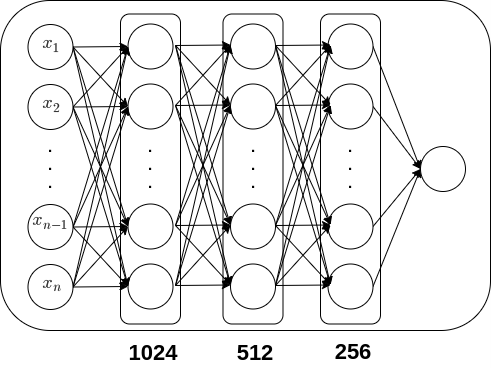

## Validación cruzada con los datos de Natalia
- [x] Agregar la métrica de RMSE.
- [x] Cambiar las gráficas para que se distingan por marcadores y solo con los puntos discretos.
- [x] Probar con los datos GKM.
- [x] Cambiar ReLu por Swish.
- [x] Graficar la función de pérdida.
- [x] Variar el número de capas ocultas (1 a 4 capas, (relu), (relu, sigmoid), (relu, tanh, sigmoid), (relu, relu, tanh, sigmoid).
- [x] Hacer una prueba con la función de pérdida MSE, (RMSE).
- [ ] Recortar el historial de peŕdida (200~300, hasta el final)
- [ ] $\mu$ (eje y) vs. hidden layers number (eje x), para todos los escenarios (B2B, 0dBm, 9dBm), 3 gráficas (una para cada métrica) 
- [ ] Para la evaluación de la función de pérdida (MSE vs. MAE) cambiar el eje y para usar $\mu$ y el eje x, se separan los escenarios (poner 3 índices y luego cambiarles la apariencia).
- [ ] Buscar si sumar MAE con RMSE y promediar es pecado.
- [ ] Demodular usando redes neuronales (empezar con pocas neuronas y una sola capa oculta).

In [2]:
#Librerías
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from time import time

%store -r

In [101]:
def estimation_model(input_dim, layers_props_lst, loss_fn):
    model = ker.Sequential()
    # Capas ocultas
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regresor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    # Compilar modelo
    model.compile(loss=loss_fn, optimizer="adam")

    return model


def crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks):
    # Para calcular el tiempo que tarda
    t0 = time()

    # Diccionario donde se almacenarán los puntajes
    scores = {}
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    scores["rmse"] = {"train": [], "test": []}
    
    # Se hace un K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estandarización de las variables de entrada
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props, loss_fn)
        # Guardar la pérdida escalar de prueba (Test scalar loss)
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Se predice con los datos de entrenamiento
        predictions_train = model.predict(X_train)
        # Se predice con los datos de prueba
        predictions_test = model.predict(X_test_kf)

        # Se crea un dataframe con los resultados para visualizarlos mejor
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Cálculo del MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Cálculo de R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
         
        # Cálculo de RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )

        # Anexo a las listas
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_model(data, n_splits, max_neurons, activations, loss_fn="mean_absolute_error"):
    """ Probar un modelo con parámetros establecidos. """
    variables = 17

    # Separando variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Etiquetas
    y = np.array(data[:, 19:20]).T
    
    # Propiedades de las capas
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=100, mode="min", restore_best_weights=True)
    ]
    
    return crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks)


def plot_neurons_scores(scores, max_neurons, scenario):
    score_names = ["mae", "r2", "rmse"]
    markers = ["*", "x", "^", "+"]
    data_type = ["train", "test"]
    
    # Graficar pérdida
    fig_loss = plt.figure(figsize=(20, 4*len(max_neurons)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    i = 0
    for score, neurons in zip(scores, max_neurons):
        for k, loss in enumerate(score["loss"]):
            plt.subplot(len(max_neurons), len(score["loss"]), i+1)
            plt.plot(loss.history["loss"], label=f"k = {k+1}")
            # plt.axvline(x=np.argmin(loss.history["loss"]), color="red", linestyle="--",
            #             label="min")
            plt.title(f"{neurons} Max neurons")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(loc="upper right")
            i += 1
    plt.show()
    
    # Graficar puntajes
    fig_scores = plt.figure(figsize=(16, 4*len(scores)), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(len(score_names), len(data_type), i+1)
            for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], label=f"n = {neurons}, µ = {np.mean(points):.3f}",
                               s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1
    plt.show()

    
def plot_activations_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    markers = ["o", "v", "X", "P"]
    data_type = ["train", "test"]
    
    # Graficar pérdida
    fig_loss = plt.figure(figsize=(20, 4*len(max_neurons)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    i = 0
    for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
        for k, loss in enumerate(score["loss"]):
            plt.subplot(len(max_neurons), len(score["loss"]), i+1)
            plt.plot(loss.history["loss"], label=f"k = {k+1}")
            # plt.axvline(x=np.argmin(loss.history["loss"]), color="red", linestyle="--",
            #             label="min")
            plt.title(f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(loc="upper right")
            i += 1
    plt.show()
            
    # Graficar puntajes
    fig_scores = plt.figure(figsize=(16, 4*len(scores)), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(len(score_names), len(data_type), i+1)
            for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], 
                            label=f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}, µ = {np.mean(points):.3f}",
                            s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1
    plt.show()
    
    
def plot_layers_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    hidden_layers = [str(n + 1) for n in range(4)]
    markers = ["D", "H", "s", "2"]
    data_type = ["train", "test"]
    
    # Graficar pérdida
    fig_loss = plt.figure(figsize=(20, 4*len(max_neurons)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    i = 0
    for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
        for k, loss in enumerate(score["loss"]):
            plt.subplot(len(max_neurons), len(score["loss"]), i+1)
            plt.plot(loss.history["loss"], label=f"k = {k+1}")
            # plt.axvline(x=np.argmin(loss.history["loss"]), color="red", linestyle="--",
            #             label="min")
            plt.title(f"{hidden_layers[j]} hidden layers.")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(loc="upper right")
            i += 1
    plt.show()
            
    # Graficar puntajes
    fig_scores = plt.figure(figsize=(16, 4*len(scores)), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(len(score_names), len(data_type), i+1)
            for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], 
                            label=f"{hidden_layers[j]} hidden layers, µ = {np.mean(points):.3f}",
                            s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1
    plt.show()    
    
    
def plot_loss_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    markers = [".", "<", ">", "s", "*", "x"]
    data_type = ["train", "test"]
    
    # Graficar pérdida
    fig_loss = plt.figure(figsize=(20, 4*len(max_neurons)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    i = 0
    for j, score in enumerate(scores):
        for k, loss in enumerate(score["loss"]):
            plt.subplot(len(markers), len(score["loss"]), i+1)
            plt.plot(loss.history["loss"], label=f"k = {k+1}")
            # plt.axvline(x=np.argmin(loss.history["loss"]), color="red", linestyle="--",
            #             label="min")
            plt.title(f"{'MAE' if j%2==0 else 'MSE'} {'B2B' if j<2 else 'optical fiber at ' + ('0' if j<4 else '9') + ' dBm'}")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(loc="upper right")
            i += 1
    plt.show()
            
    # Graficar puntajes
    fig_scores = plt.figure(figsize=(16, 4*len(scores)), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        for dt in data_type:
            plt.subplot(len(score_names), len(data_type), i+1)
            for j, score in enumerate(scores):
                points = score[sn][dt]

                k = np.arange(len(points), dtype = np.uint8) + 1
                 
                plt.scatter(k, points, marker=markers[j], 
                            label=f"{'MAE' if j%2==0 else 'MSE'} {'B2B' if j<2 else 'optical fiber at ' + ('0' if j<4 else '9') + ' dBm'}, µ = {np.mean(points):.3f}",
                            s = 100)
                
            plt.title(f"{'Train' if dt == 'train' else 'Test'}")
            plt.xlabel("k-fold")
            plt.xticks(k)
            plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
            plt.grid(True)
            plt.legend(loc="upper right")
            i += 1
    plt.show()    
    
    
def calc_once(varname, fn, args):
    """ Calcular una variable una sola vez. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

## FCM

In [4]:
# Para leer los datos
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_FCM_B2B = df_FCM[0:987, :]
# Datos con fibra óptica a 0dBm
df_FCM_fiber0 = df_FCM[988:1520, :]
# Datos con fibra óptica a 9dBm
df_FCM_fiber9 = df_FCM[1521:, :]

### Crosvalidación para FCM B2B variando el número de neuronas por capa

In [5]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_B2B = calc_once("scores_FCM_1024_B2B", test_model, args)

In [6]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_B2B = calc_once("scores_FCM_512_B2B", test_model, args)

In [7]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_B2B = calc_once("scores_FCM_256_B2B", test_model, args)

In [8]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_B2B = calc_once("scores_FCM_128_B2B", test_model, args)

In [9]:
%store scores_FCM_1024_B2B
%store scores_FCM_512_B2B 
%store scores_FCM_256_B2B
%store scores_FCM_128_B2B

Stored 'scores_FCM_1024_B2B' (dict)
Stored 'scores_FCM_512_B2B' (dict)
Stored 'scores_FCM_256_B2B' (dict)
Stored 'scores_FCM_128_B2B' (dict)


#### Gráficas de puntajes (FCM B2B)

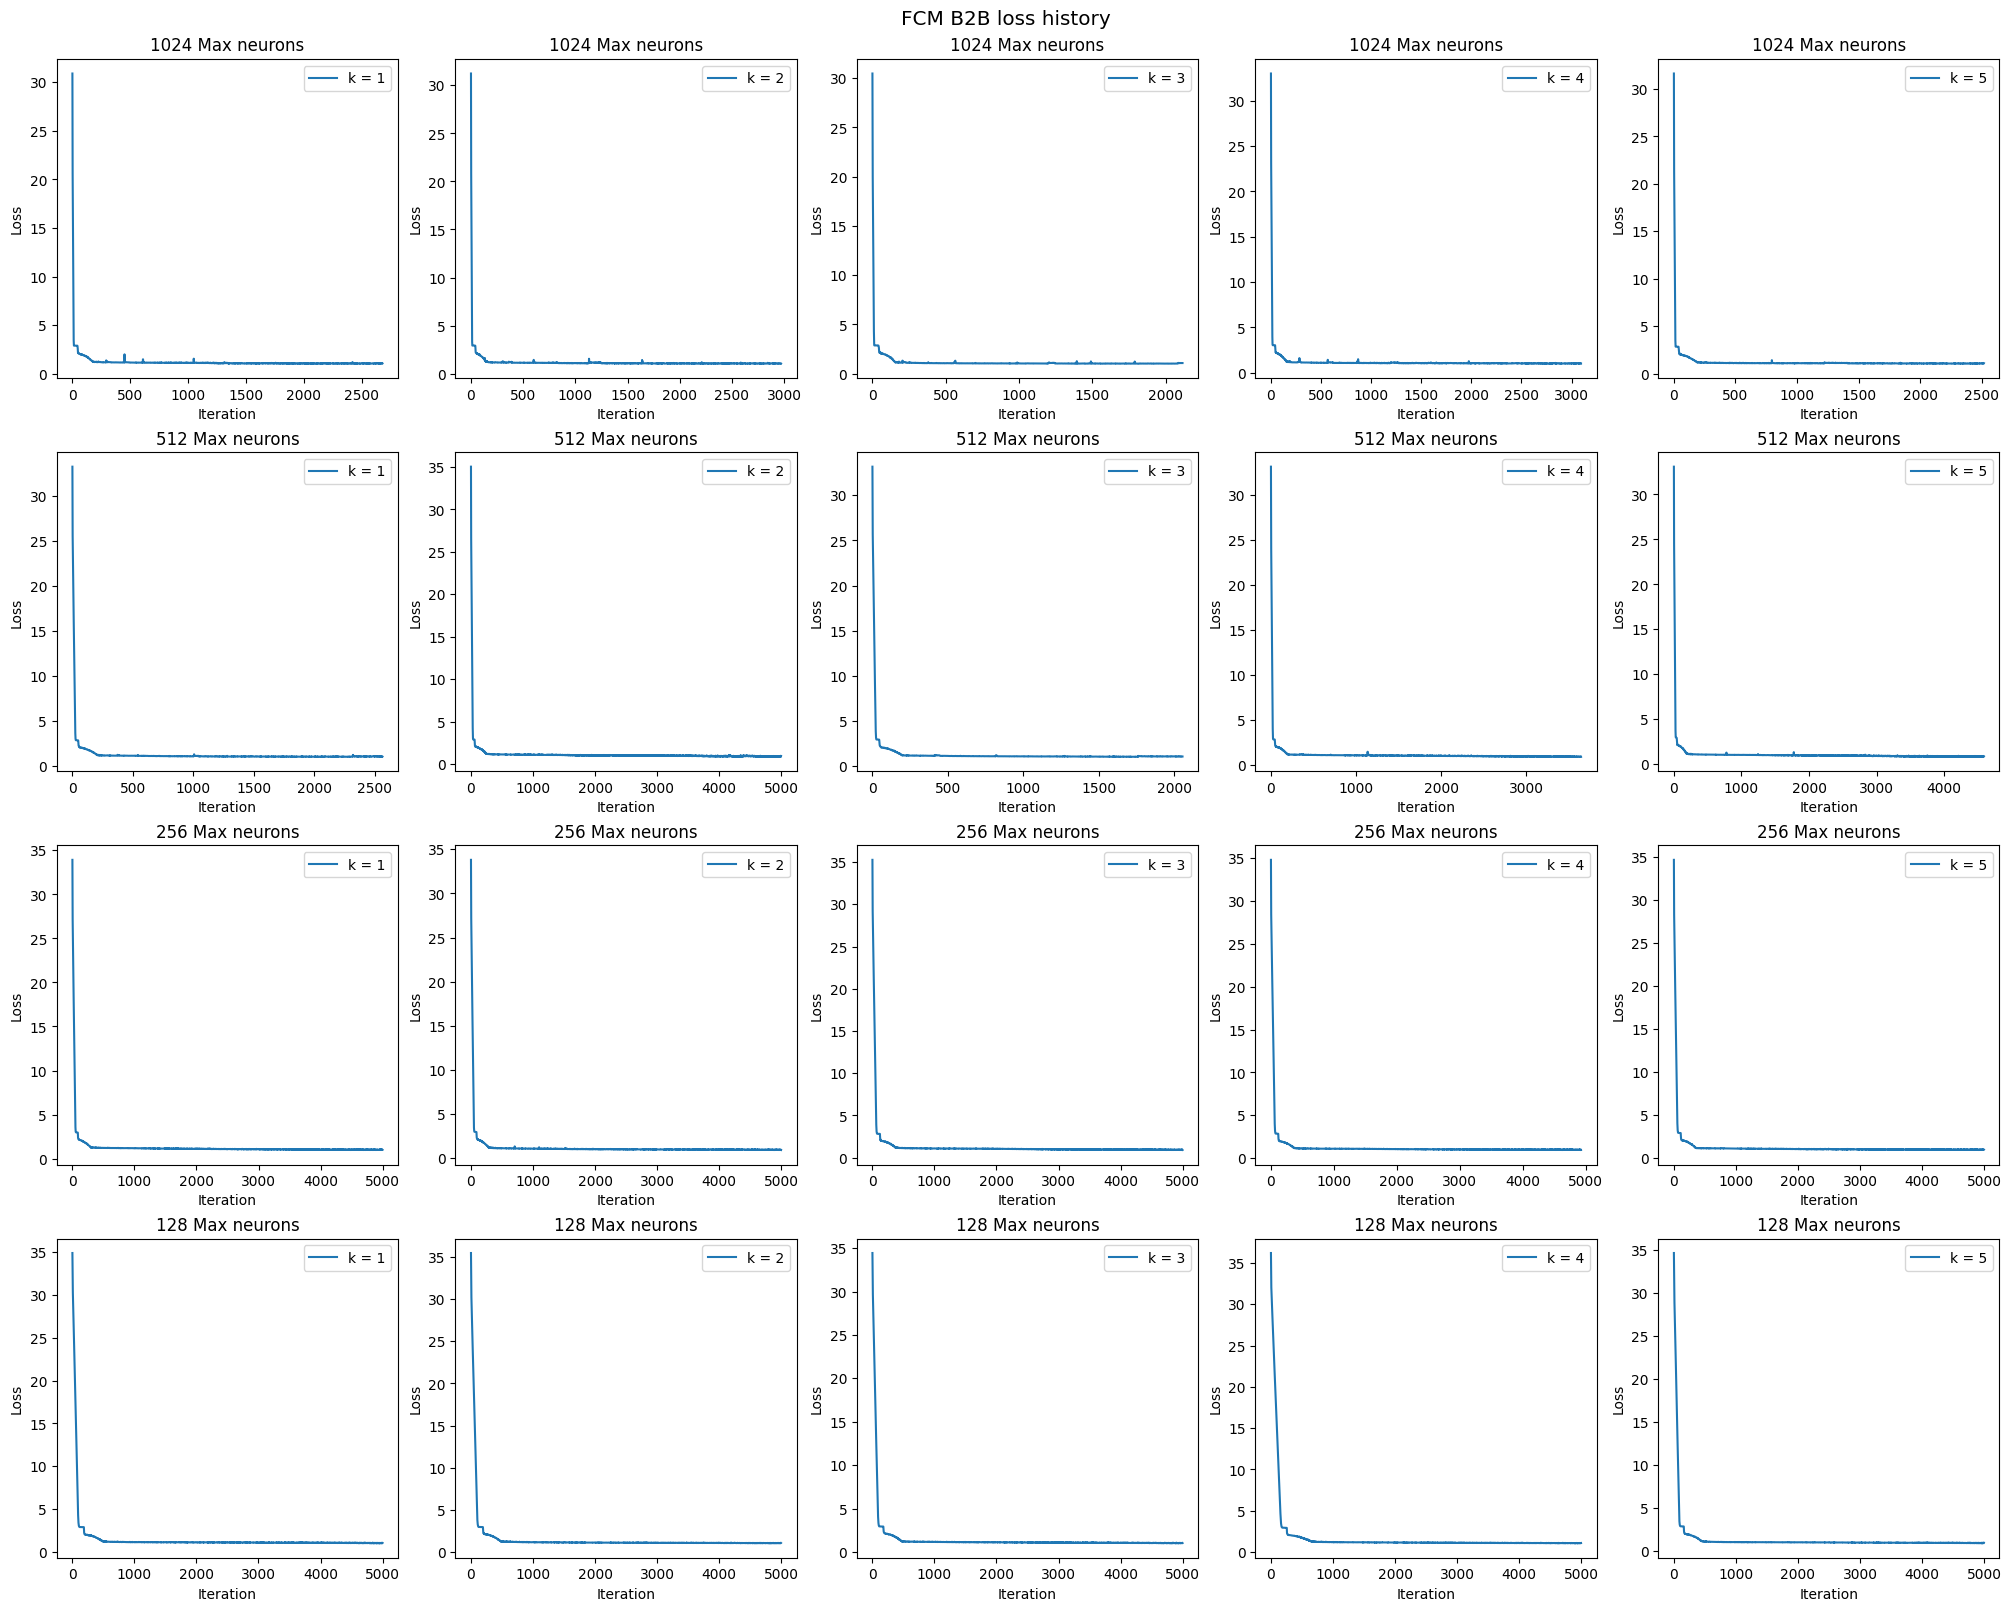

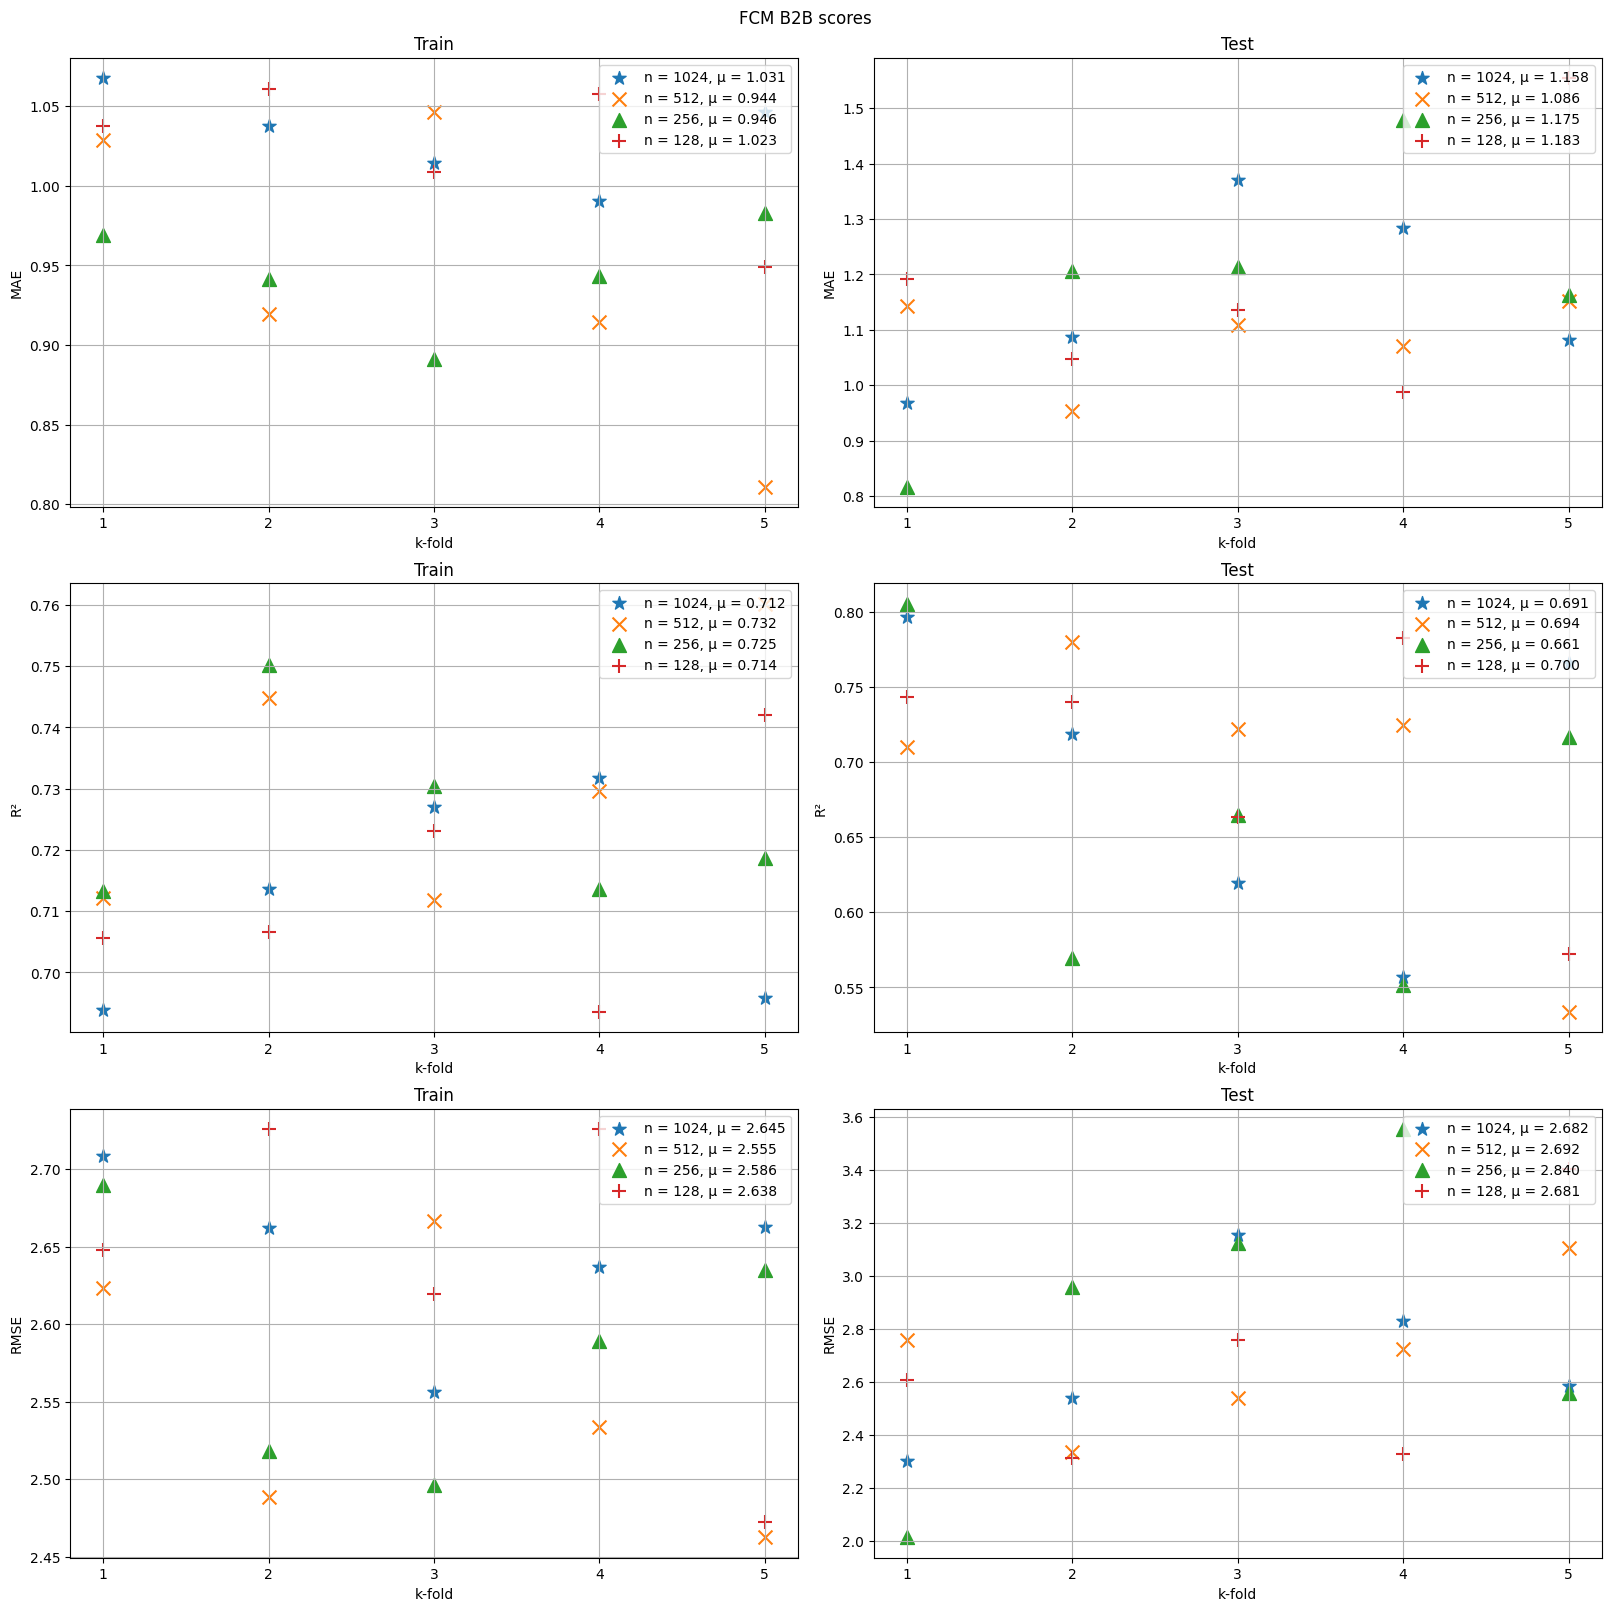

In [10]:
scores = [scores_FCM_1024_B2B, scores_FCM_512_B2B, scores_FCM_256_B2B, scores_FCM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM B2B")

### Crosvalidación para FCM con fibra óptica a 0dBm variando el número de neuronas por capa

In [11]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber0 = calc_once("scores_FCM_1024_fiber0", test_model, args)

In [12]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber0 = calc_once("scores_FCM_512_fiber0", test_model, args)

In [13]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber0 = calc_once("scores_FCM_256_fiber0", test_model, args)

In [14]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber0 = calc_once("scores_FCM_128_fiber0", test_model, args)

In [15]:
%store scores_FCM_1024_fiber0 
%store scores_FCM_512_fiber0 
%store scores_FCM_256_fiber0 
%store scores_FCM_128_fiber0

Stored 'scores_FCM_1024_fiber0' (dict)
Stored 'scores_FCM_512_fiber0' (dict)
Stored 'scores_FCM_256_fiber0' (dict)
Stored 'scores_FCM_128_fiber0' (dict)


#### Gráficas de puntajes (FCM con fibra óptica a 0dBm)

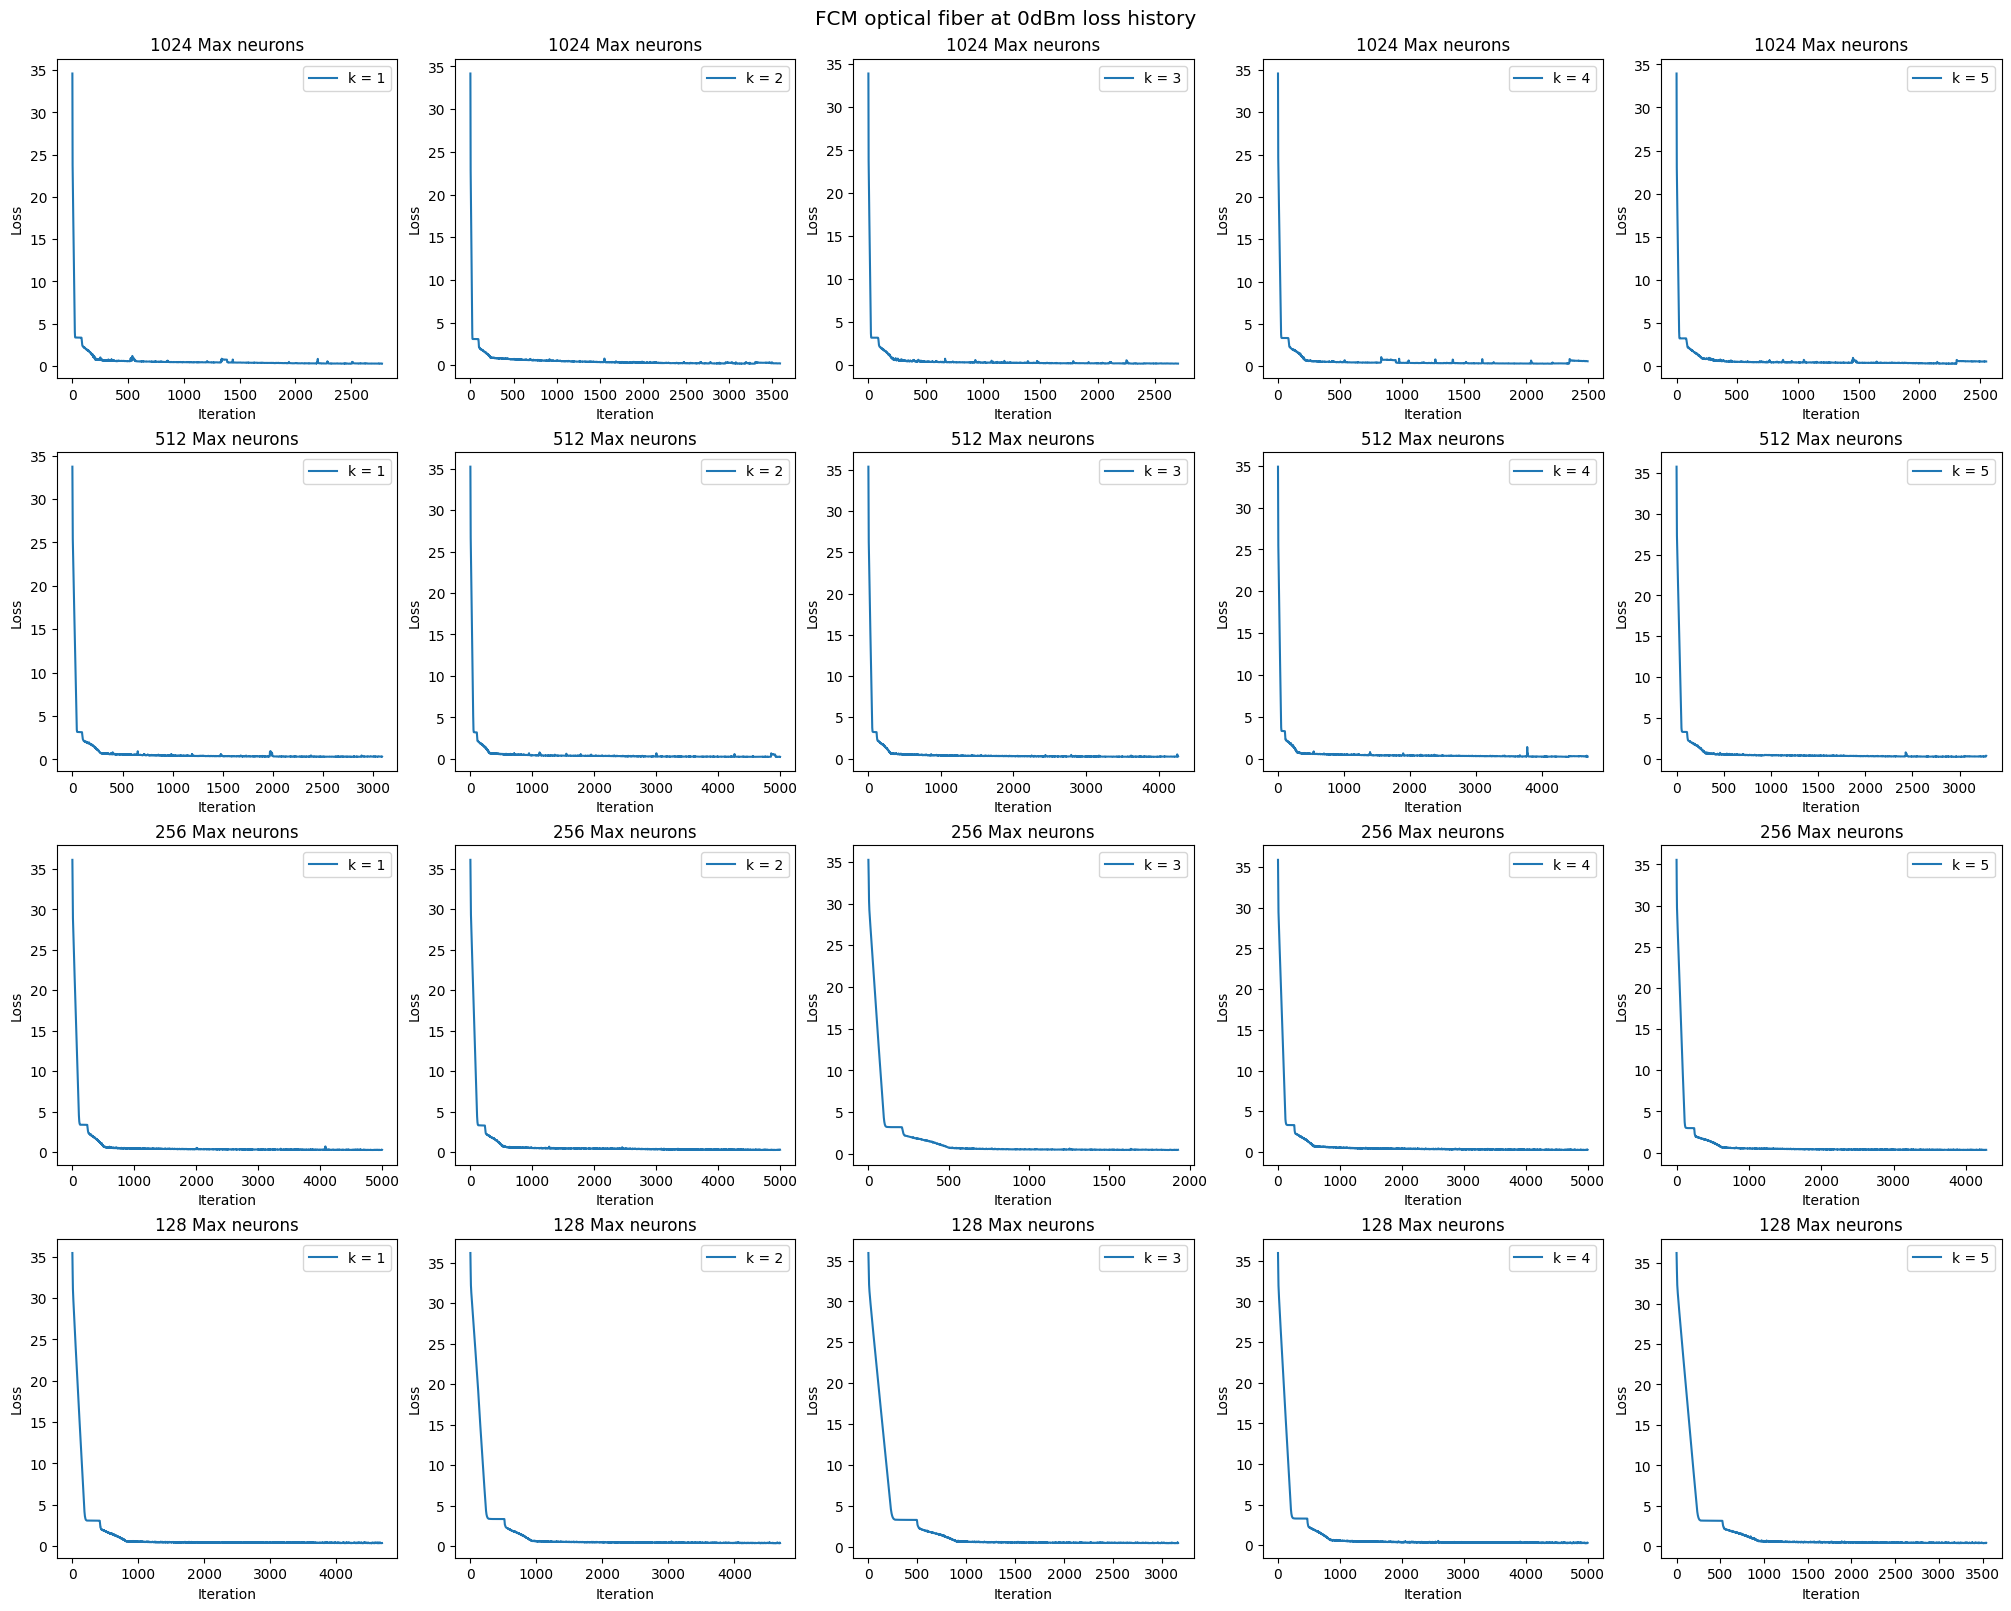

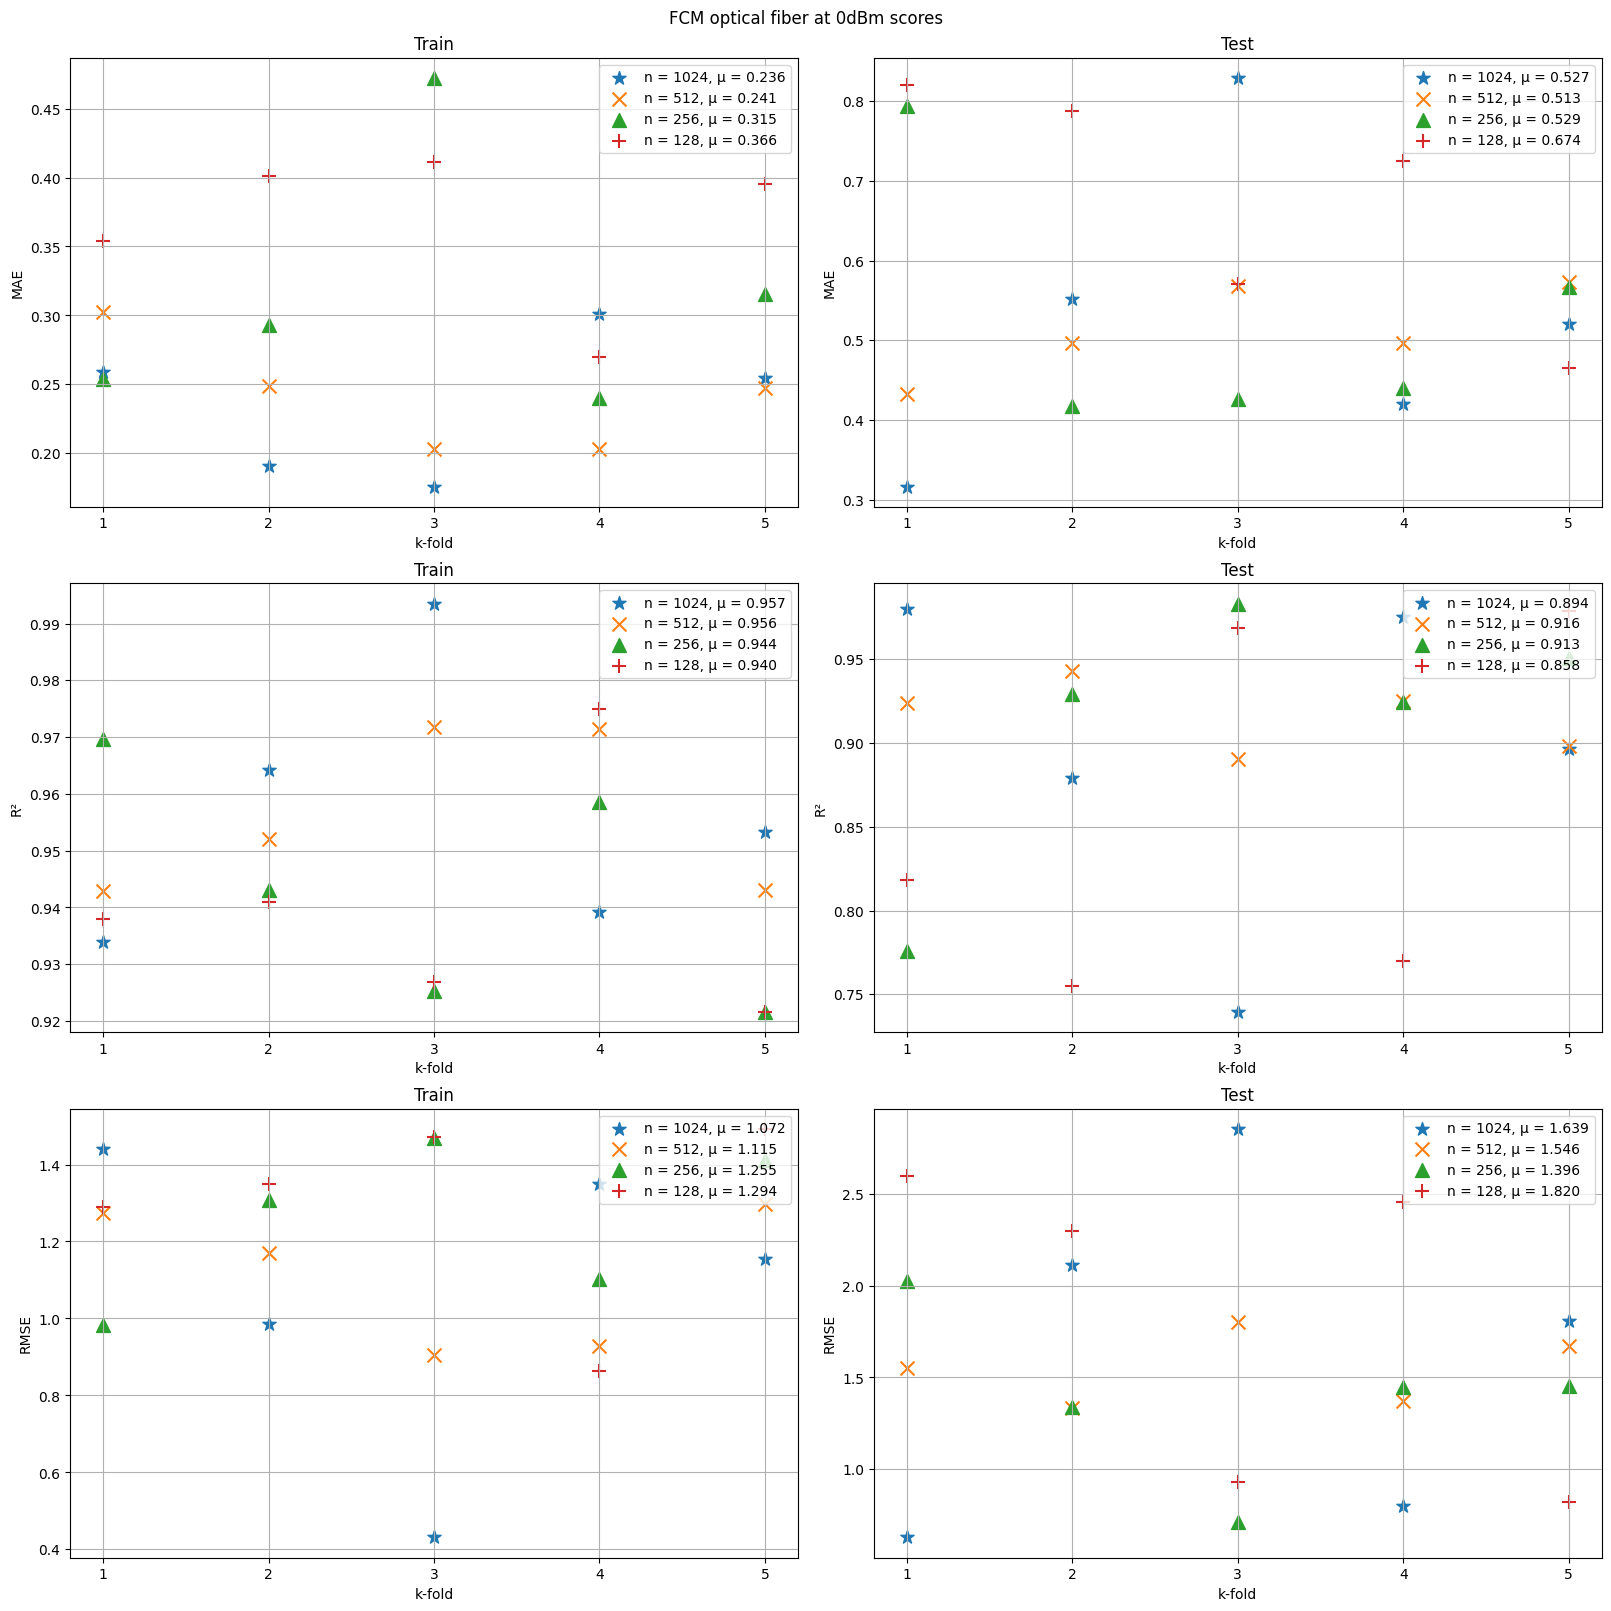

In [16]:
scores = [scores_FCM_1024_fiber0, scores_FCM_512_fiber0, scores_FCM_256_fiber0, scores_FCM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 0dBm")

### Crosvalidación para FCM con fibra óptica a 9dBm variando el número de neuronas por capa

In [17]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber9 = calc_once("scores_FCM_1024_fiber9", test_model, args)

In [18]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber9 = calc_once("scores_FCM_512_fiber9", test_model, args)

In [19]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber9 = calc_once("scores_FCM_256_fiber9", test_model, args)

In [20]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber9 = calc_once("scores_FCM_128_fiber9", test_model, args)

In [21]:
%store scores_FCM_1024_fiber9
%store scores_FCM_512_fiber9 
%store scores_FCM_256_fiber9 
%store scores_FCM_128_fiber9

Stored 'scores_FCM_1024_fiber9' (dict)
Stored 'scores_FCM_512_fiber9' (dict)
Stored 'scores_FCM_256_fiber9' (dict)
Stored 'scores_FCM_128_fiber9' (dict)


#### Gráficas de puntajes (FCM con fibra óptica a 9dBm)

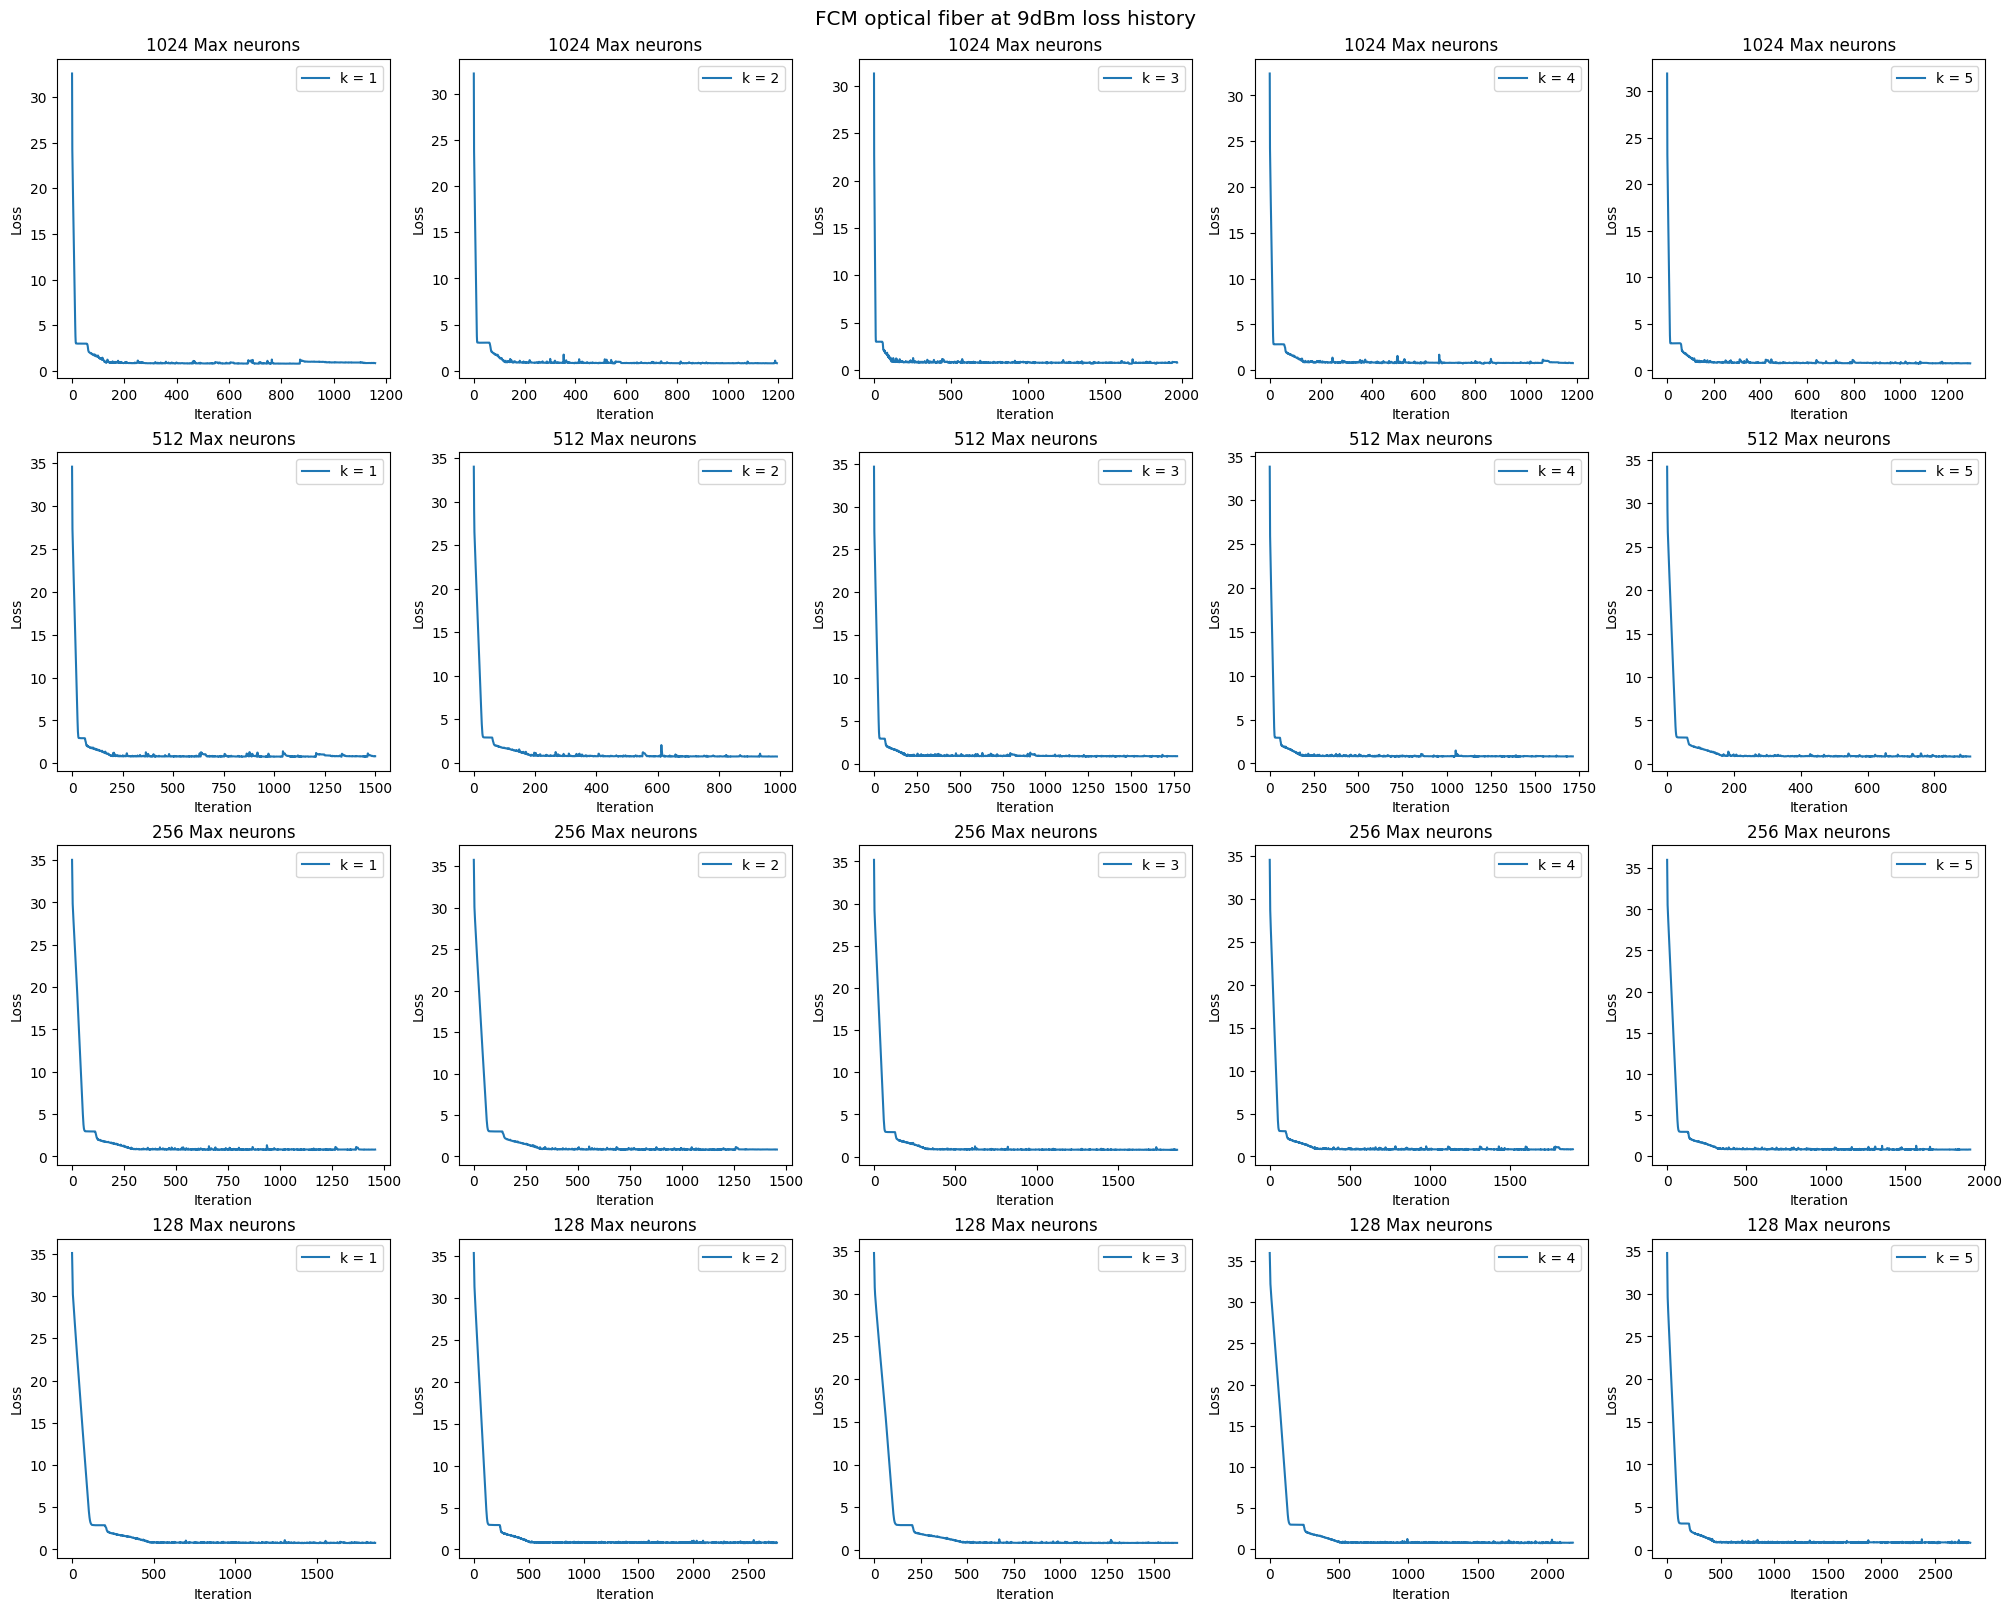

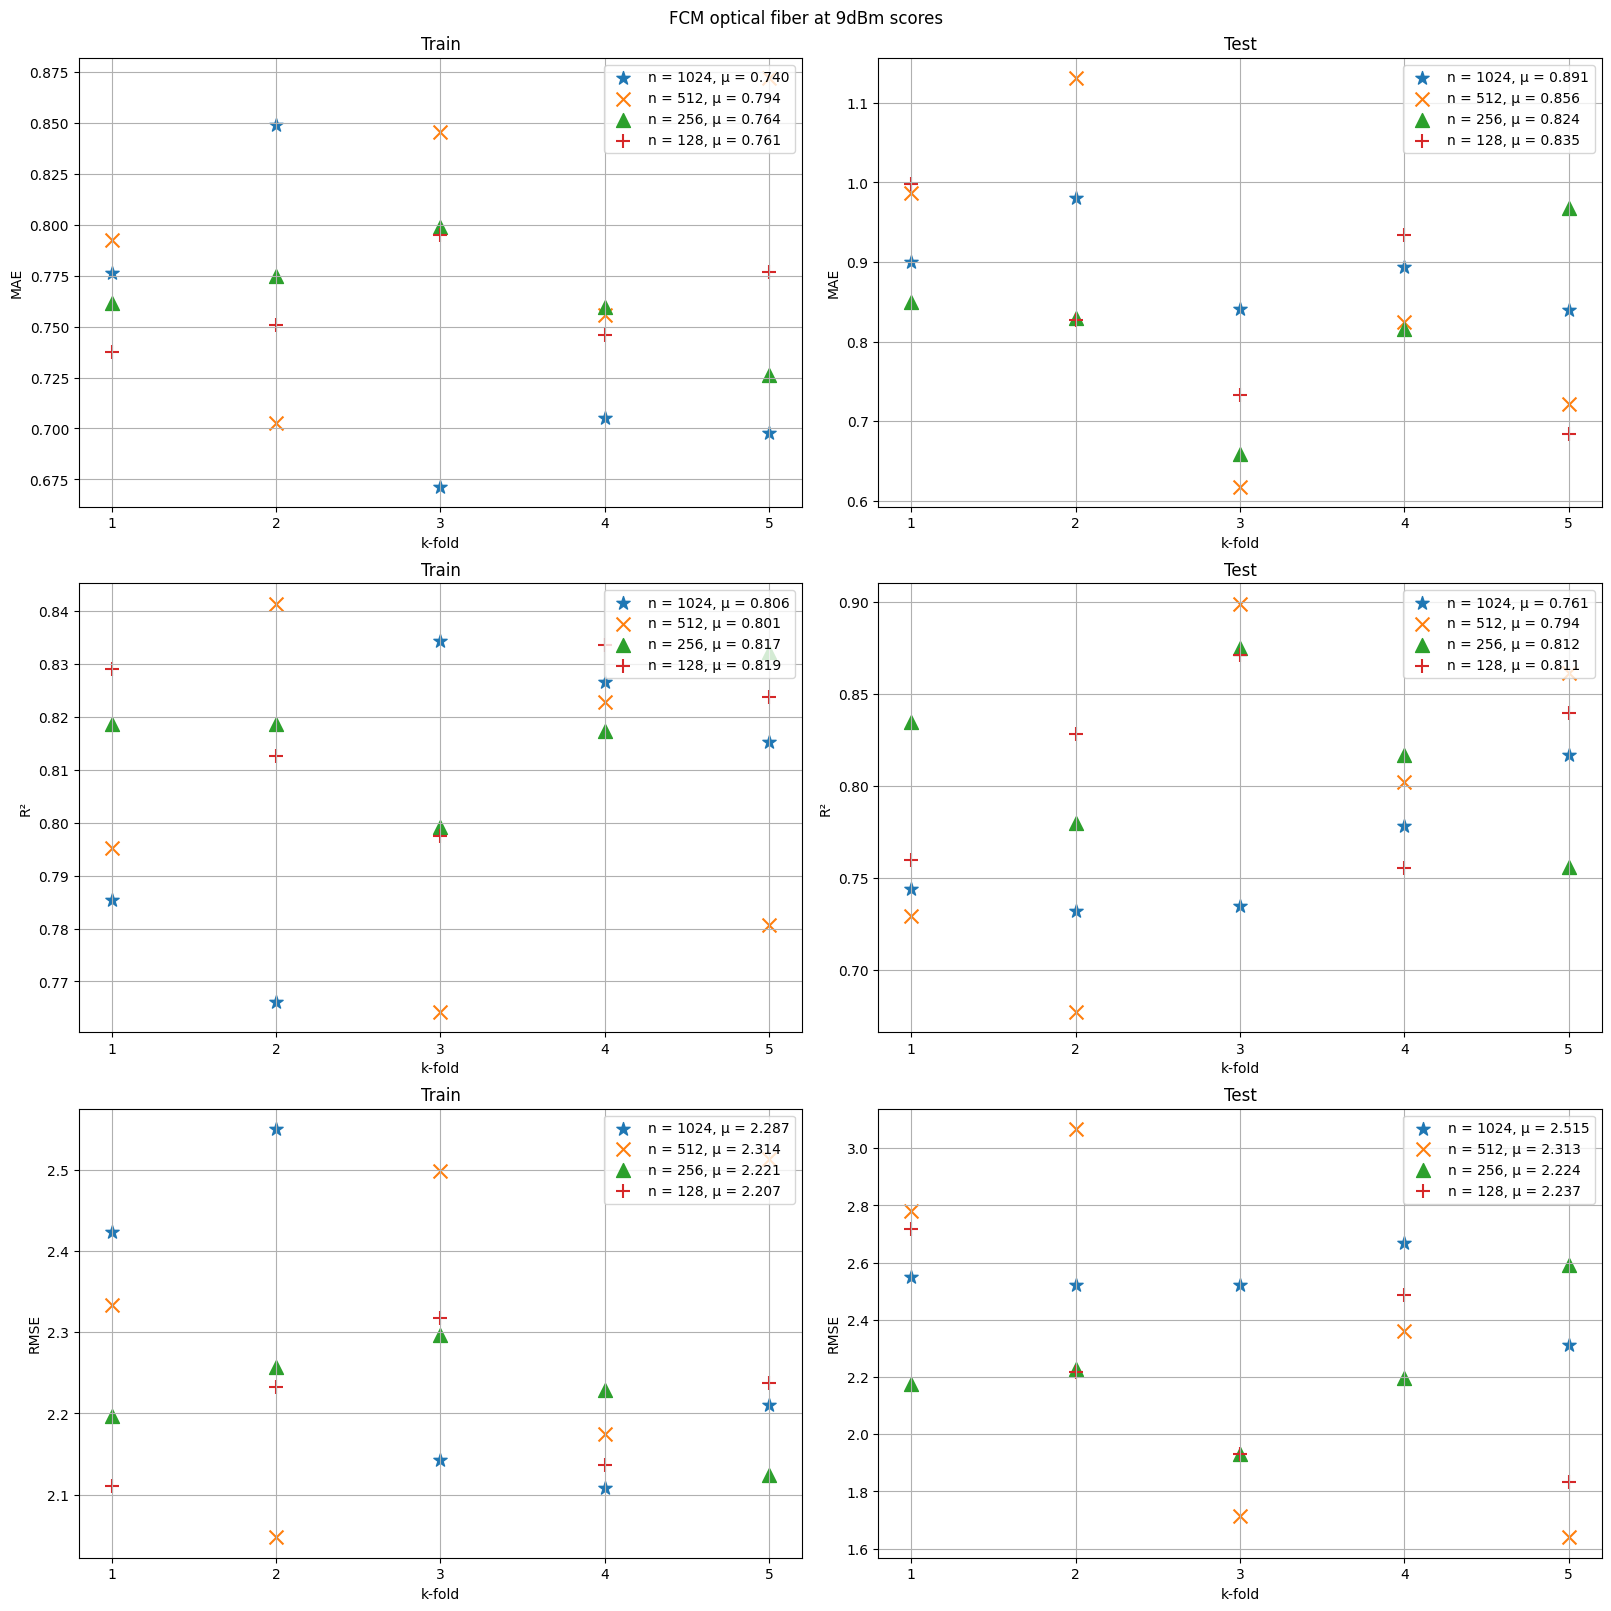

In [22]:
scores = [scores_FCM_1024_fiber9, scores_FCM_512_fiber9, scores_FCM_256_fiber9, scores_FCM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 9dBm")

## GKM

In [23]:
# Para leer los datos
data_file_GKM = "../Databases/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Separación por escenarios
# Datos sin fibra (B2B)
df_GKM_B2B = df_GKM[0:987, :]
# Datos con fibra óptica a 0dBm
df_GKM_fiber0 = df_GKM[988:1520, :]
# Datos con fibra óptica a 9dBm
df_GKM_fiber9 = df_GKM[1521:, :]

### Crosvalidación para GKM B2B variando el número de neuronas por capa

In [24]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_B2B = calc_once("scores_GKM_1024_B2B", test_model, args)

In [25]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_B2B = calc_once("scores_GKM_512_B2B", test_model, args)

In [26]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_B2B = calc_once("scores_GKM_256_B2B", test_model, args)

In [27]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_B2B = calc_once("scores_GKM_128_B2B", test_model, args)

In [28]:
%store scores_GKM_1024_B2B
%store scores_GKM_512_B2B
%store scores_GKM_256_B2B
%store scores_GKM_128_B2B

Stored 'scores_GKM_1024_B2B' (dict)
Stored 'scores_GKM_512_B2B' (dict)
Stored 'scores_GKM_256_B2B' (dict)
Stored 'scores_GKM_128_B2B' (dict)


#### Gráficas de puntajes (GKM B2B)

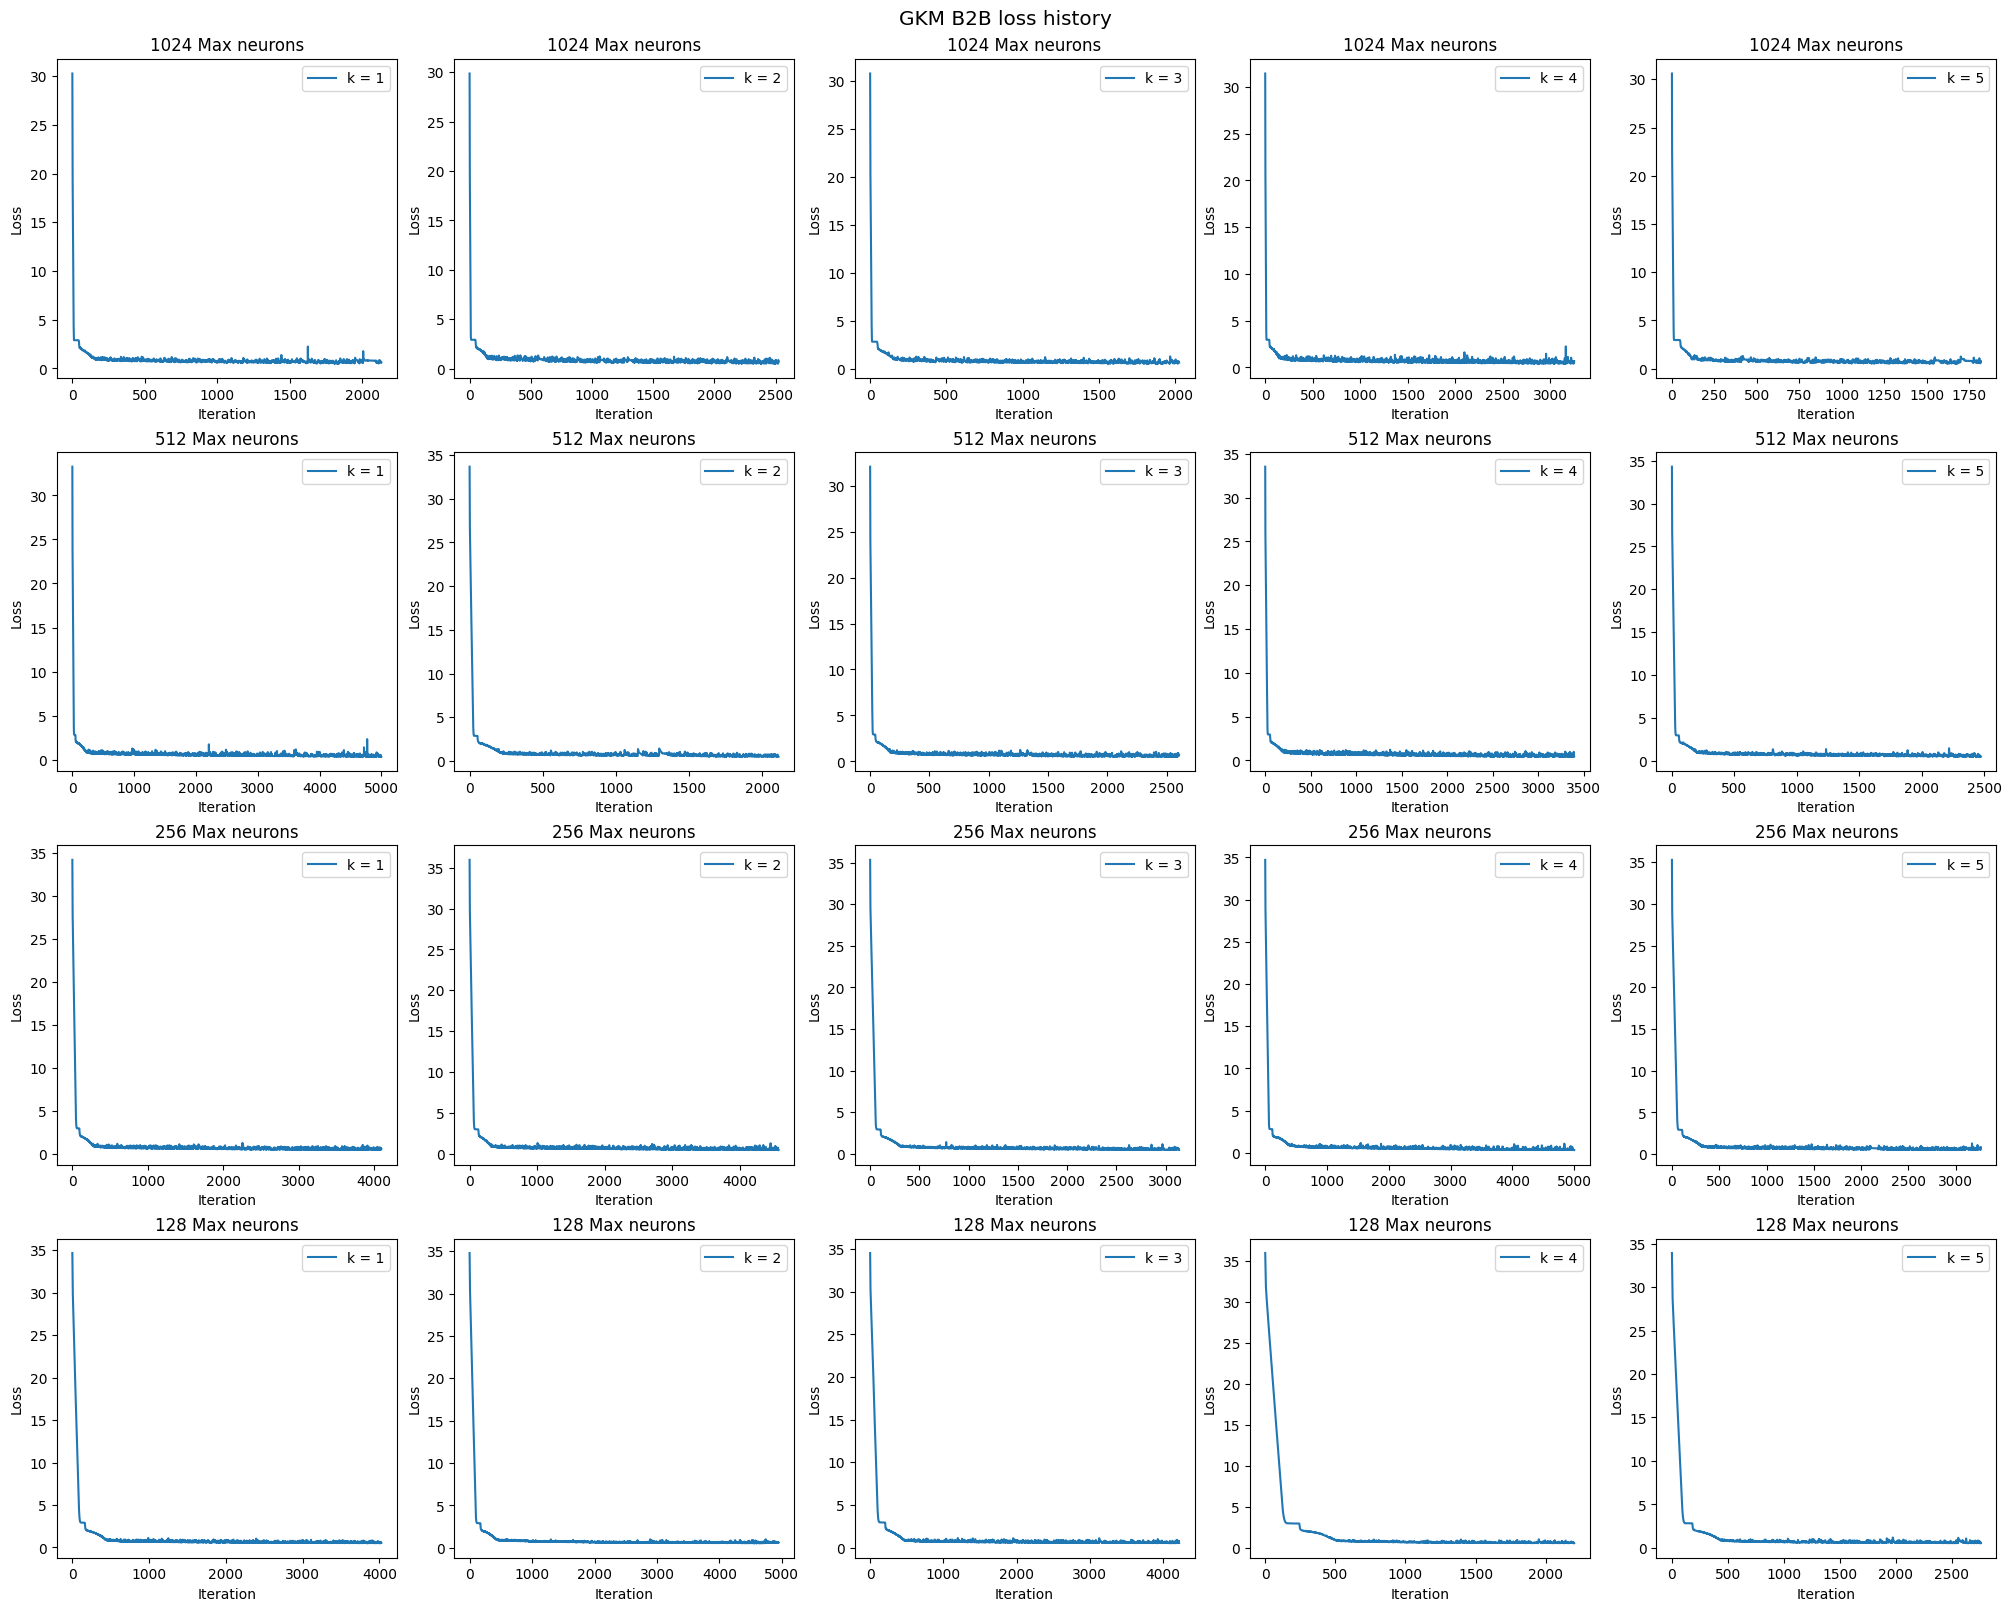

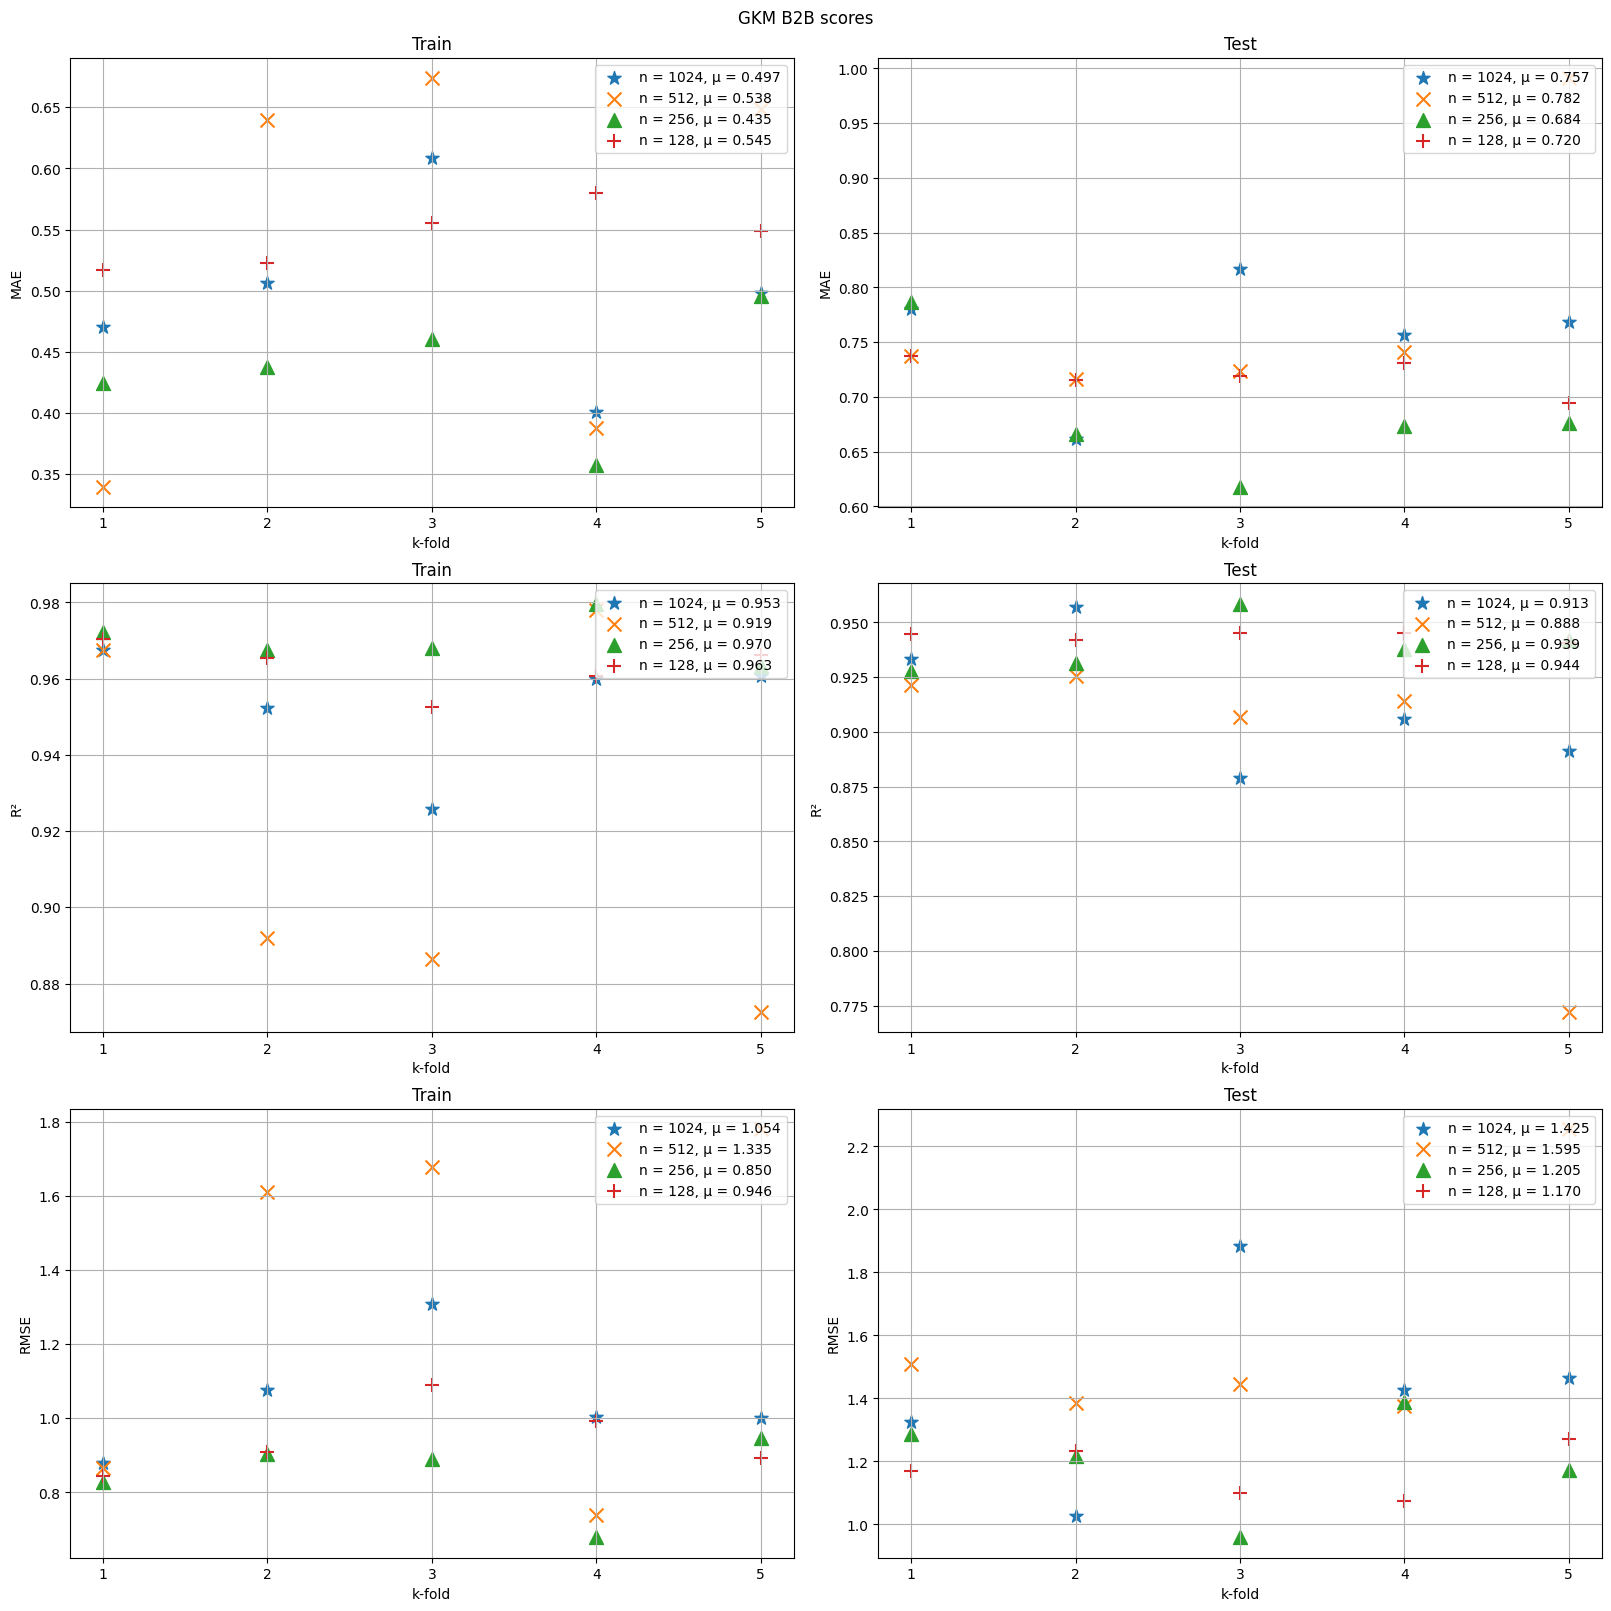

In [29]:
scores = [scores_GKM_1024_B2B, scores_GKM_512_B2B, scores_GKM_256_B2B, scores_GKM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM B2B")

### Crosvalidación para GKM con fibra óptica a 0dBm variando el número de neuronas por capa

In [30]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber0 = calc_once("scores_GKM_1024_fiber0", test_model, args)

In [31]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber0 = calc_once("scores_GKM_512_fiber0", test_model, args)

In [32]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber0 = calc_once("scores_GKM_256_fiber0", test_model, args)

In [33]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber0 = calc_once("scores_GKM_128_fiber0", test_model, args)

In [34]:
%store scores_GKM_1024_fiber0
%store scores_GKM_512_fiber0
%store scores_GKM_256_fiber0
%store scores_GKM_128_fiber0

Stored 'scores_GKM_1024_fiber0' (dict)
Stored 'scores_GKM_512_fiber0' (dict)
Stored 'scores_GKM_256_fiber0' (dict)
Stored 'scores_GKM_128_fiber0' (dict)


#### Gráficas de puntajes (GKM con fibra óptica a 0dBm)

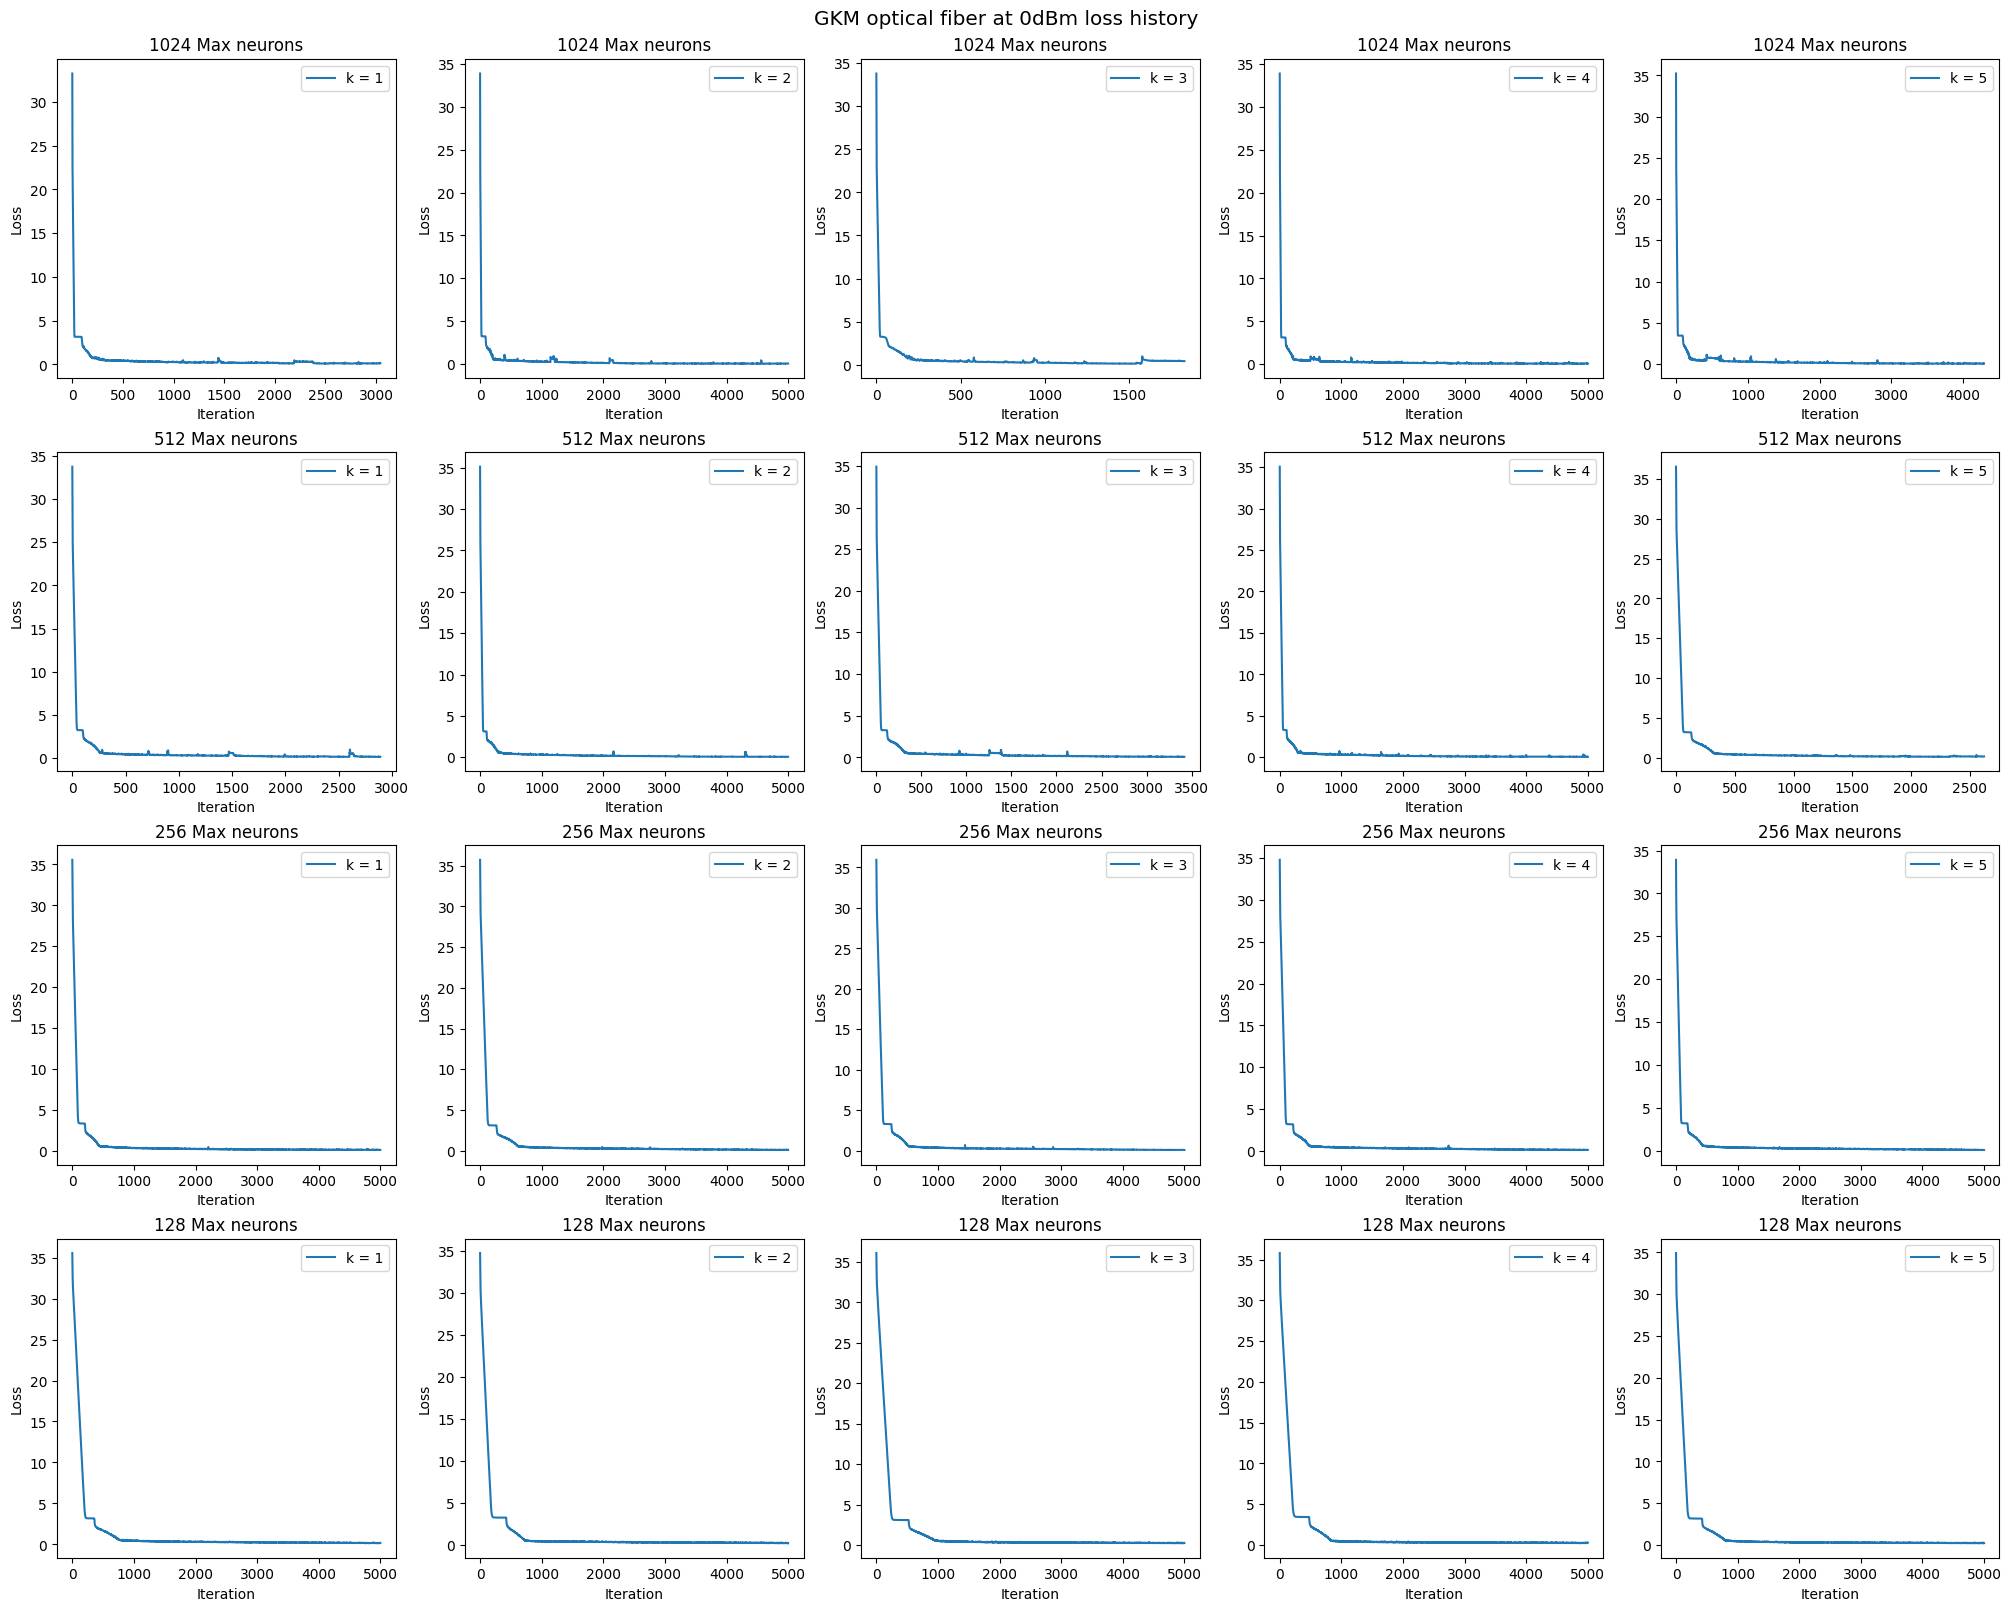

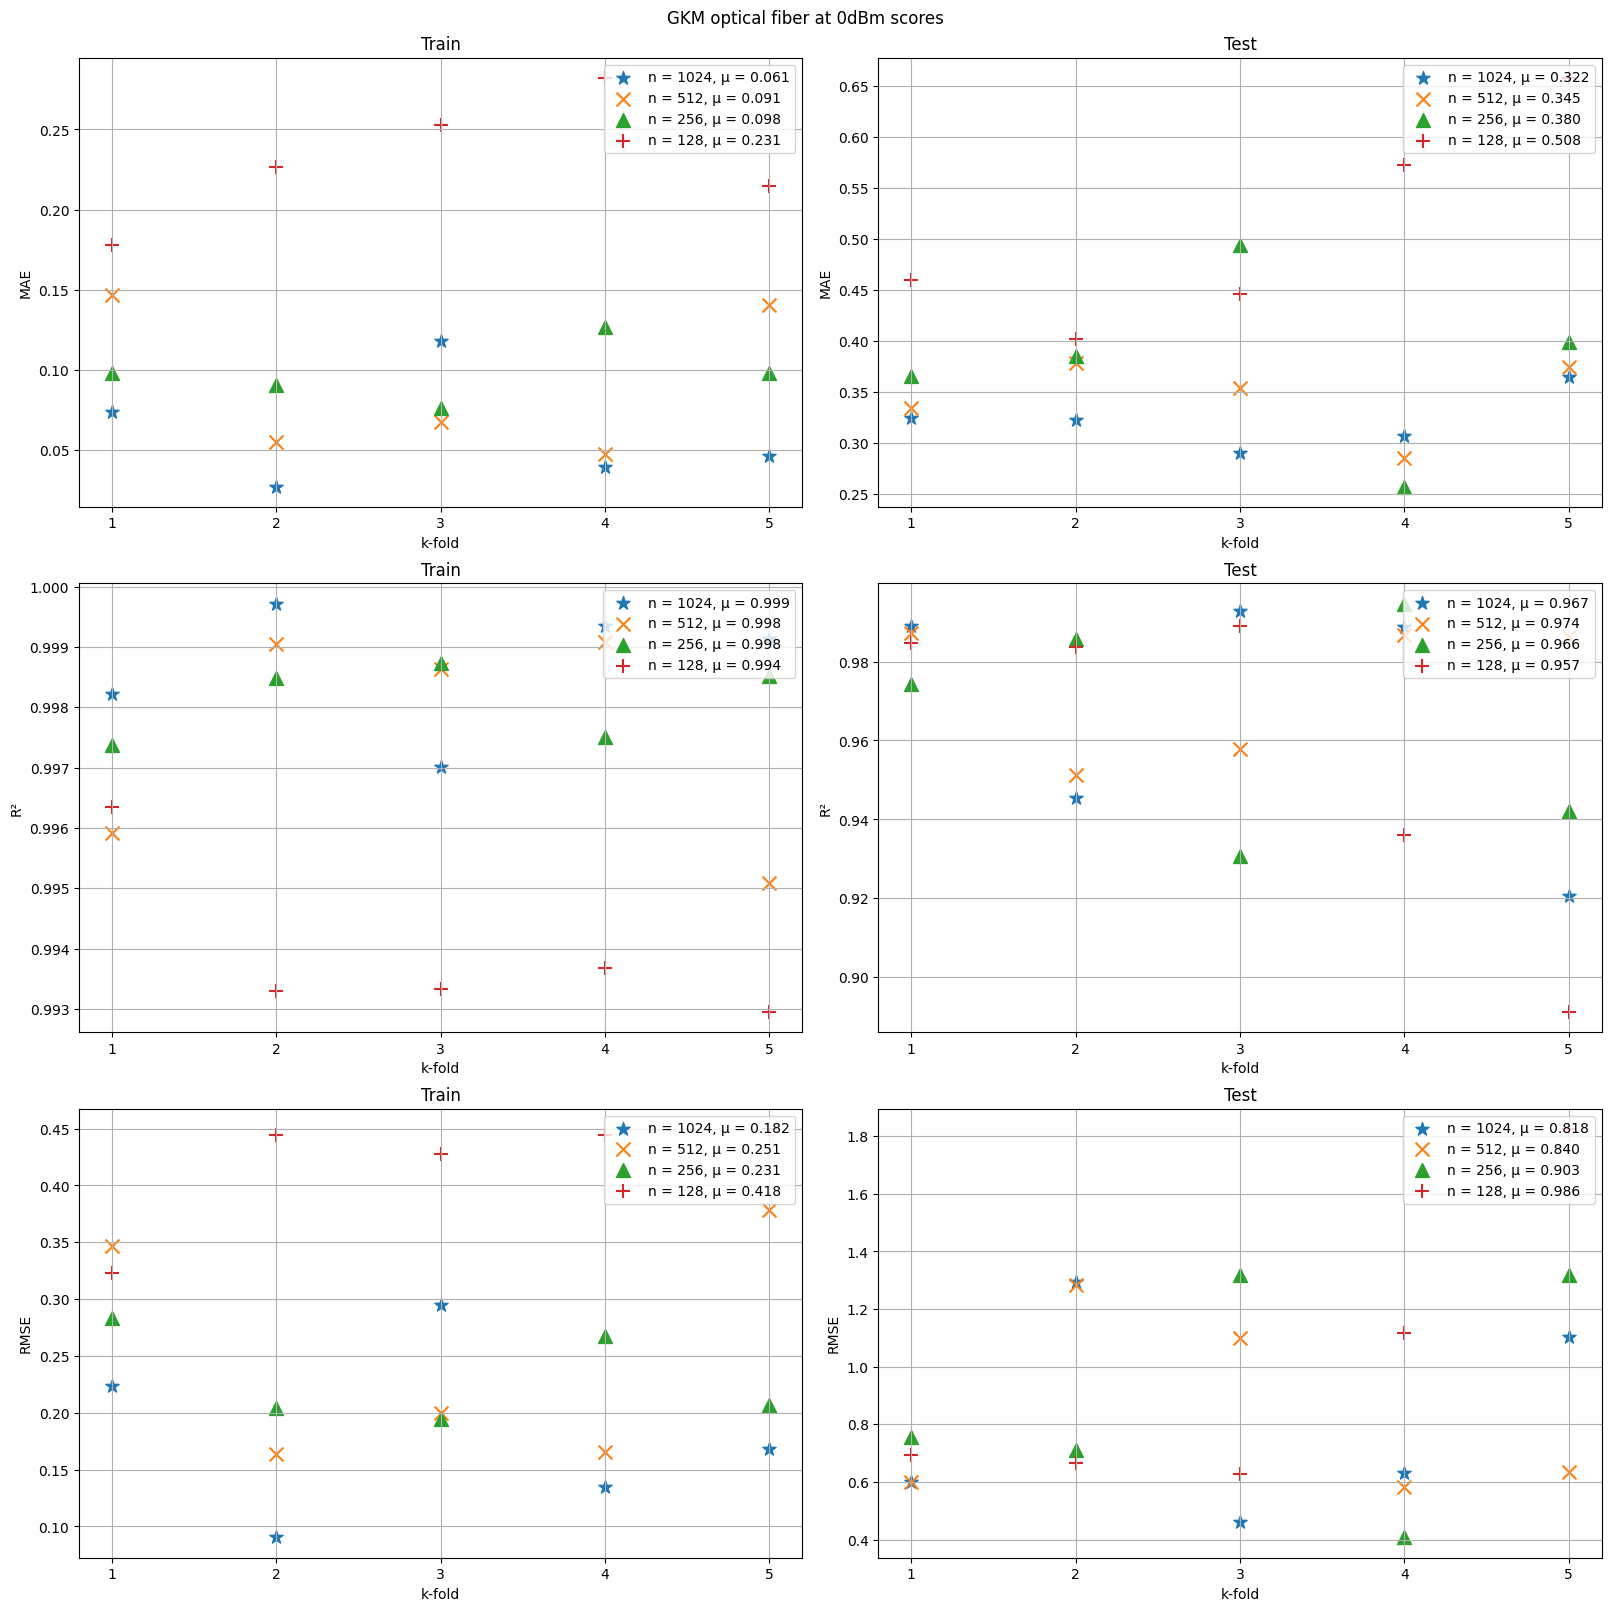

In [35]:
scores = [scores_GKM_1024_fiber0, scores_GKM_512_fiber0, scores_GKM_256_fiber0, scores_GKM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 0dBm")

### Crosvalidación para GKM con fibra óptica a 9dBm variando el número de neuronas por capa

In [36]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber9 = calc_once("scores_GKM_1024_fiber9", test_model, args)

In [37]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber9 = calc_once("scores_GKM_512_fiber9", test_model, args)

In [38]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber9 = calc_once("scores_GKM_256_fiber9", test_model, args)

In [39]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber9 = calc_once("scores_GKM_128_fiber9", test_model, args)

In [40]:
%store scores_GKM_1024_fiber9
%store scores_GKM_512_fiber9
%store scores_GKM_256_fiber9
%store scores_GKM_128_fiber9

Stored 'scores_GKM_1024_fiber9' (dict)
Stored 'scores_GKM_512_fiber9' (dict)
Stored 'scores_GKM_256_fiber9' (dict)
Stored 'scores_GKM_128_fiber9' (dict)


#### Gráficas de puntajes (GKM con fibra óptica a 9dBm)

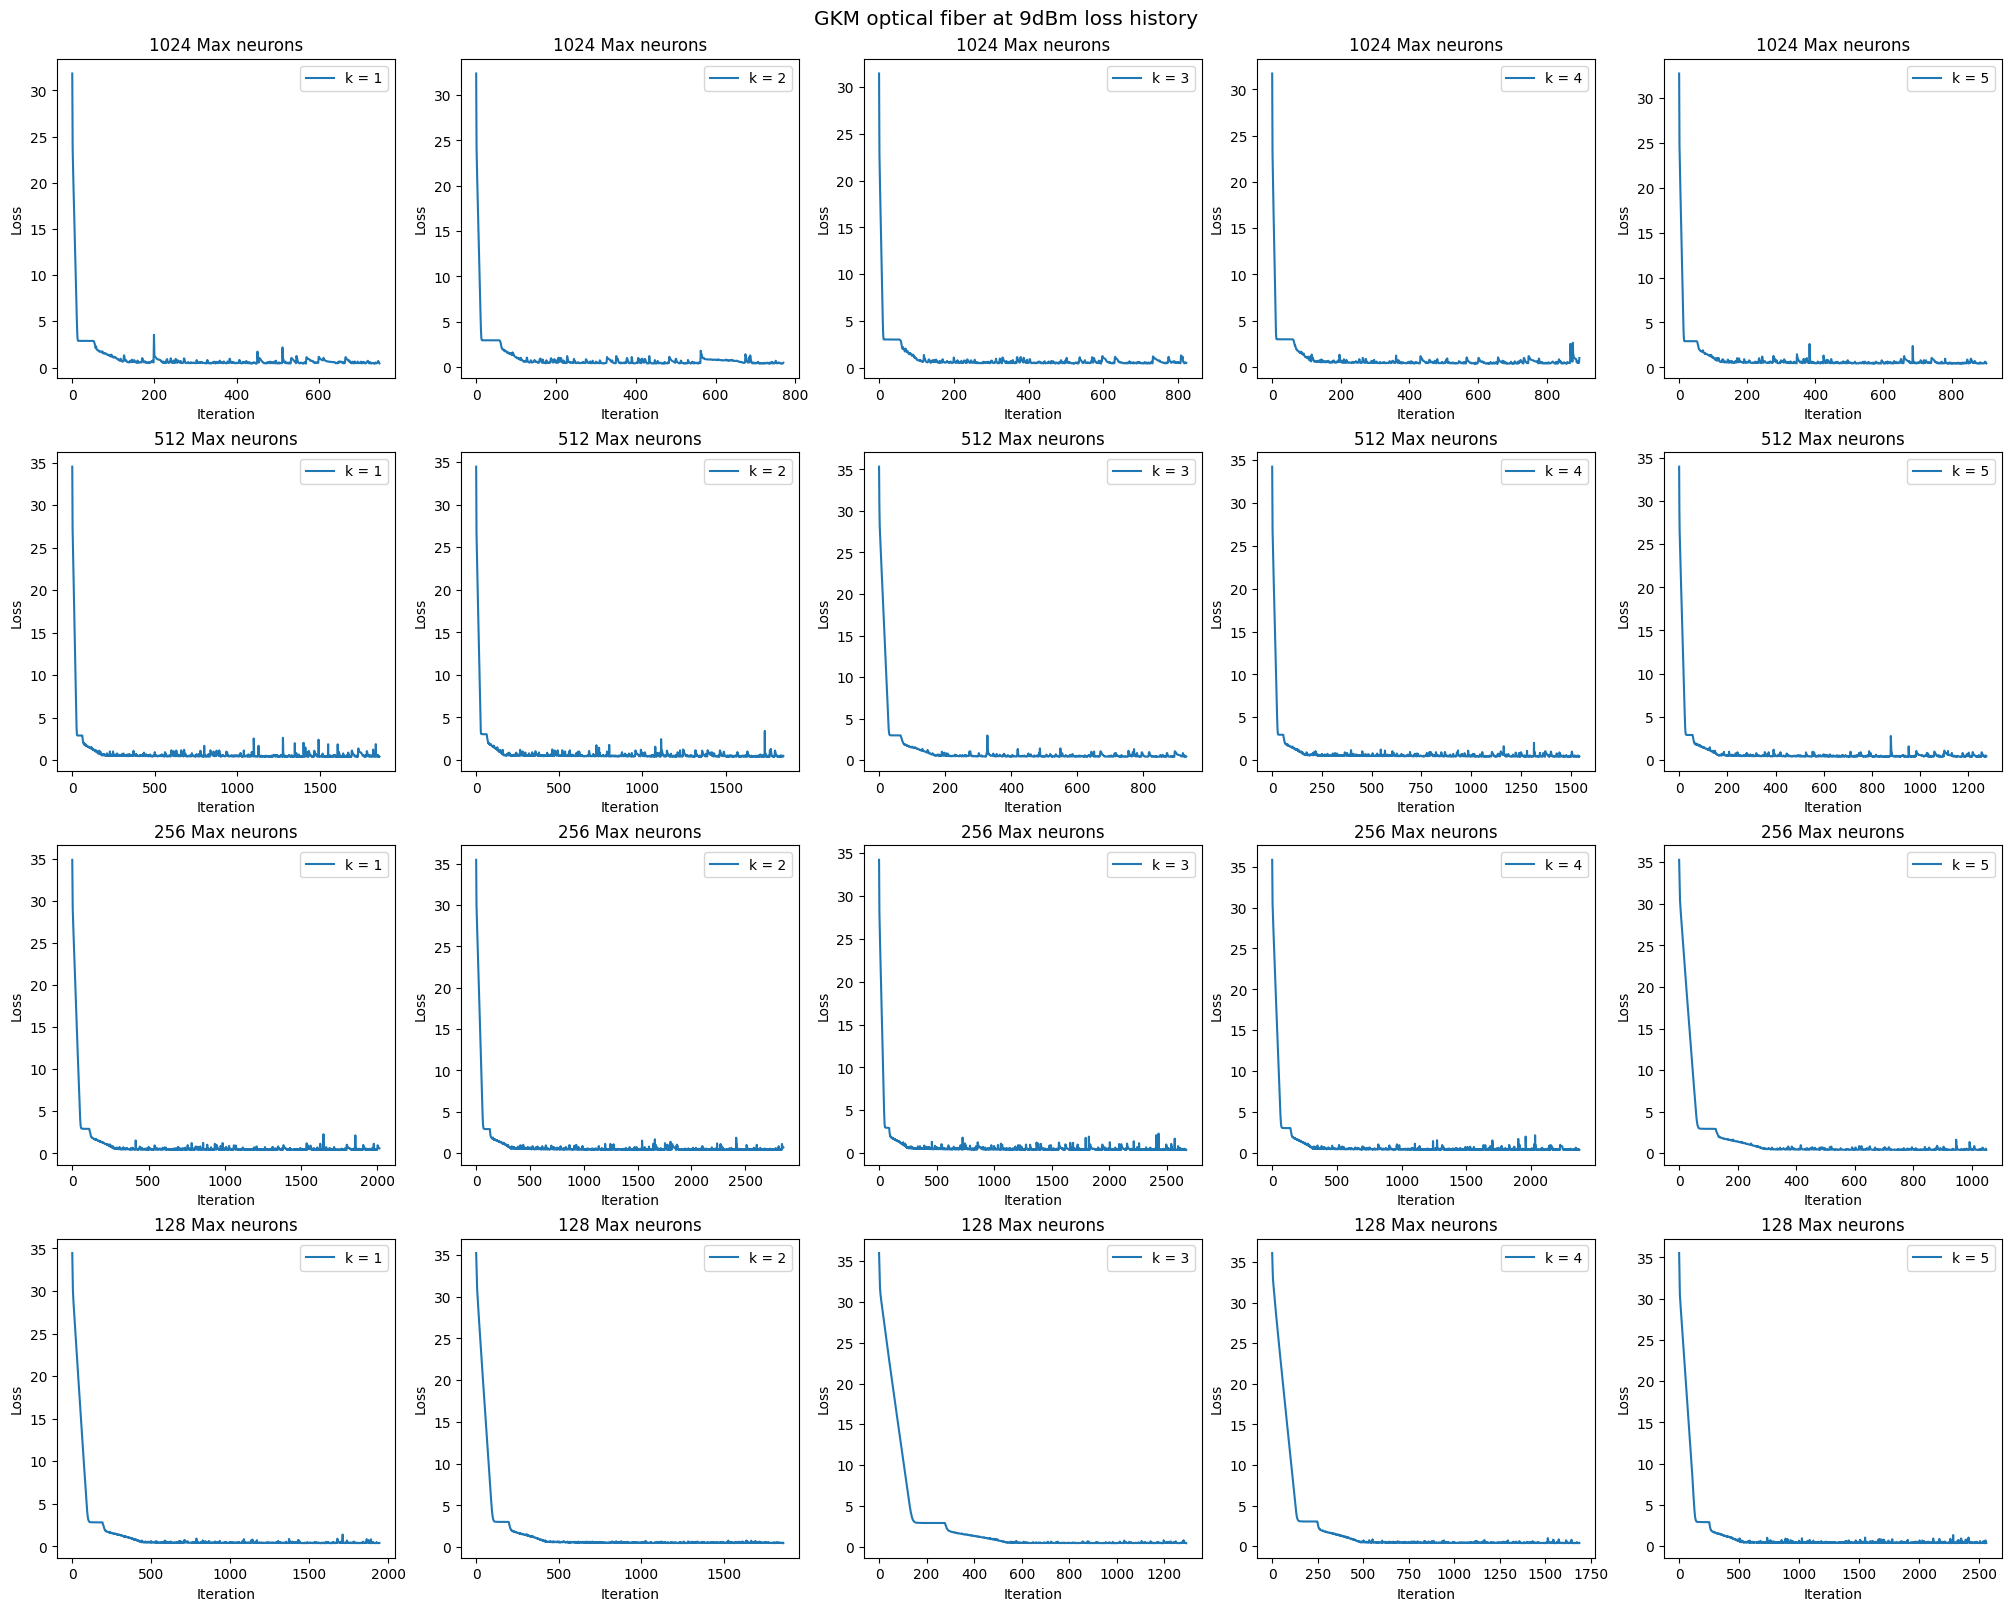

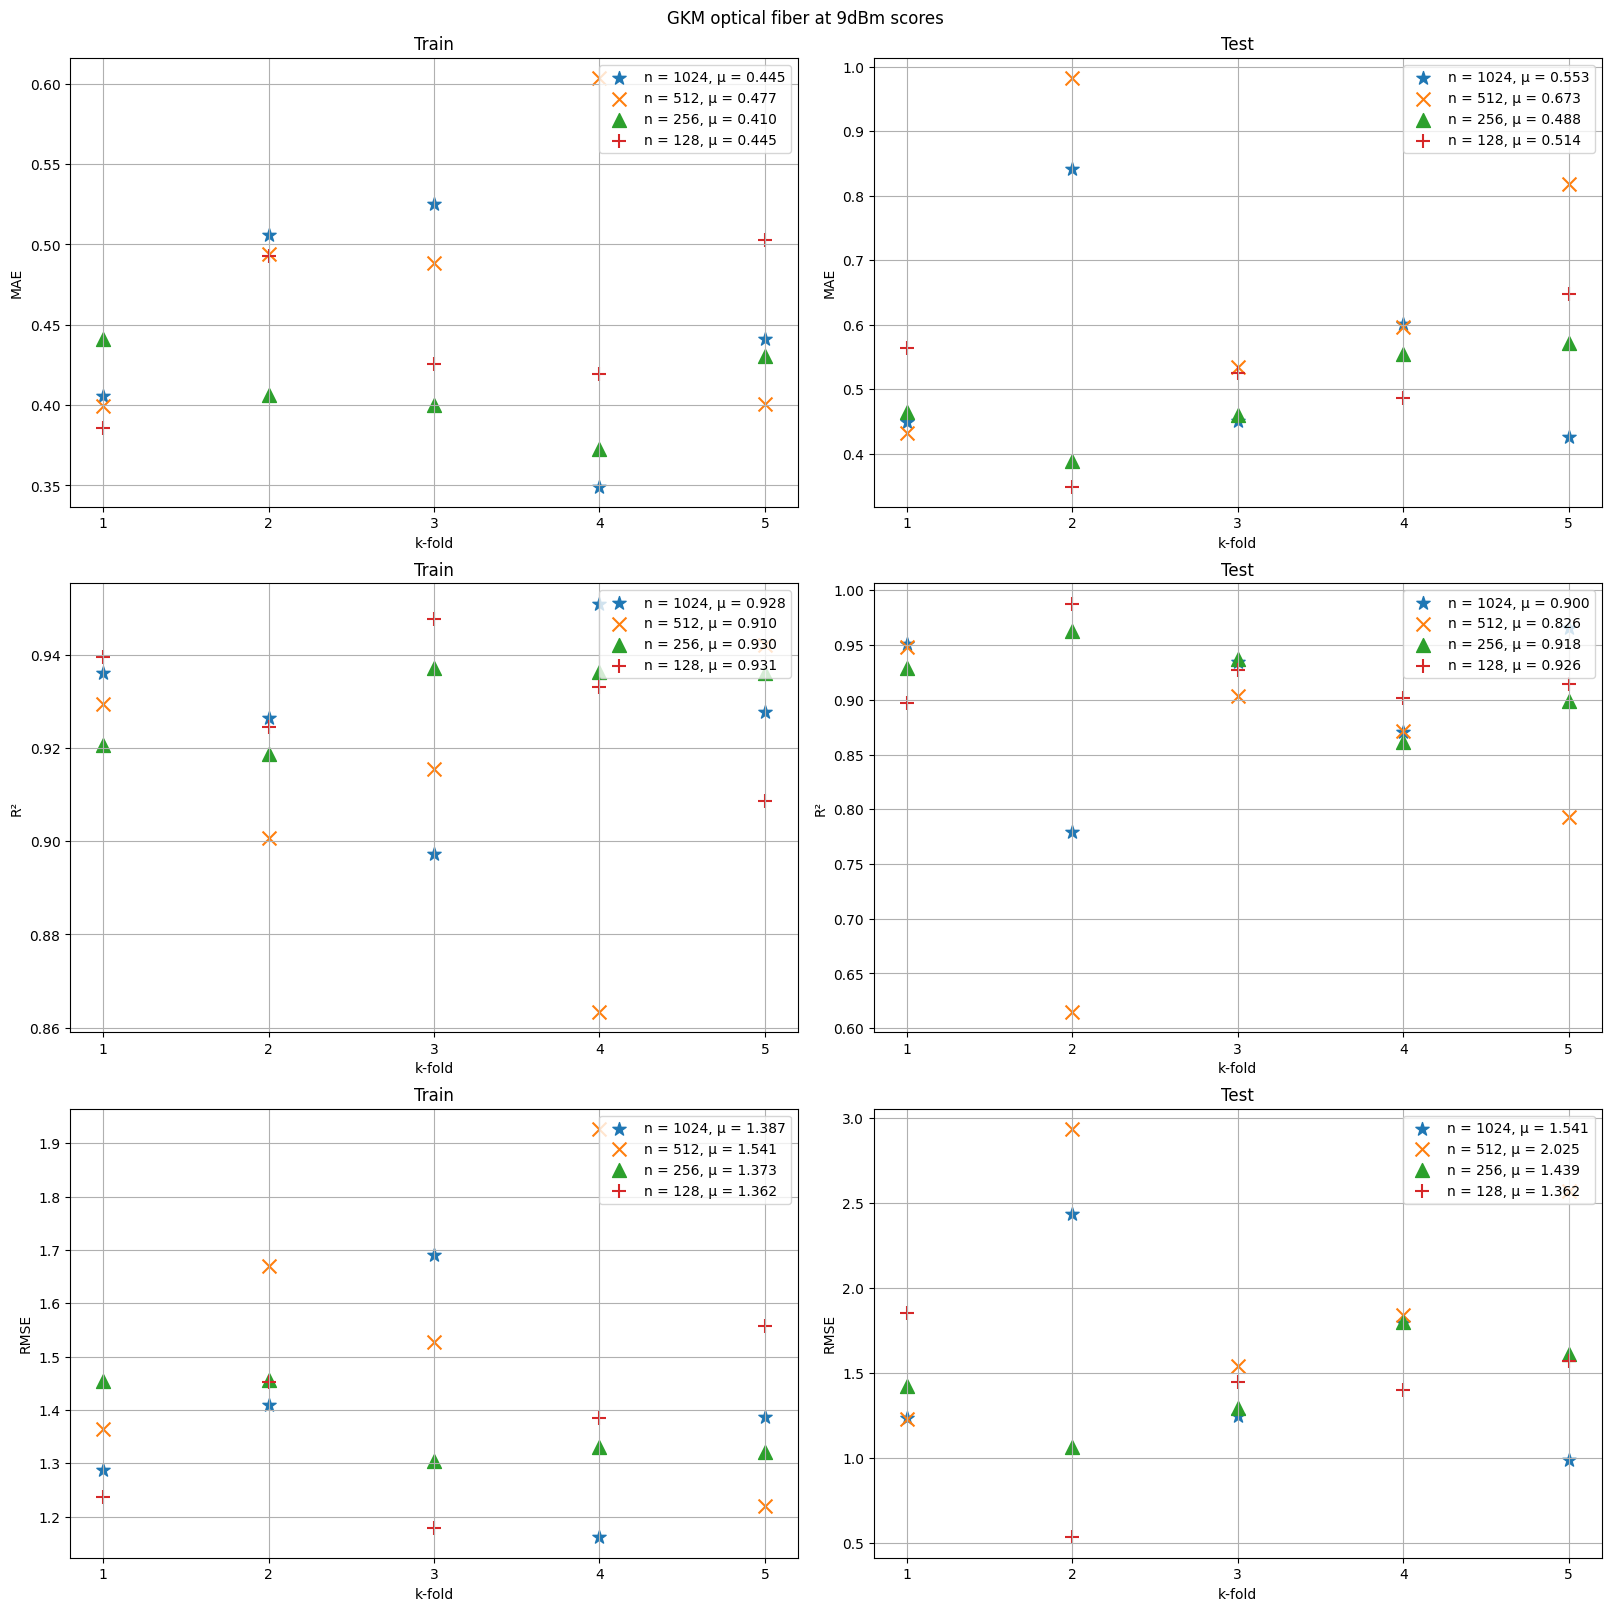

In [41]:
scores = [scores_GKM_1024_fiber9, scores_GKM_512_fiber9, scores_GKM_256_fiber9, scores_GKM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 9dBm")

## FCM y GKM usando 512 máximo número de neuronas y cambiando ReLu por Swish

### Crosvalidación para B2B variando la función ReLu por Swish

In [42]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_B2B = calc_once("scores_FCM_relu_B2B", test_model, args)

In [43]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_B2B = calc_once("scores_GKM_relu_B2B", test_model, args)

In [44]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_B2B = calc_once("scores_FCM_swish_B2B", test_model, args)

In [45]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_B2B = calc_once("scores_GKM_swish_B2B", test_model, args)

In [46]:
%store scores_FCM_relu_B2B
%store scores_GKM_relu_B2B
%store scores_FCM_swish_B2B
%store scores_GKM_swish_B2B

Stored 'scores_FCM_relu_B2B' (dict)
Stored 'scores_GKM_relu_B2B' (dict)
Stored 'scores_FCM_swish_B2B' (dict)
Stored 'scores_GKM_swish_B2B' (dict)


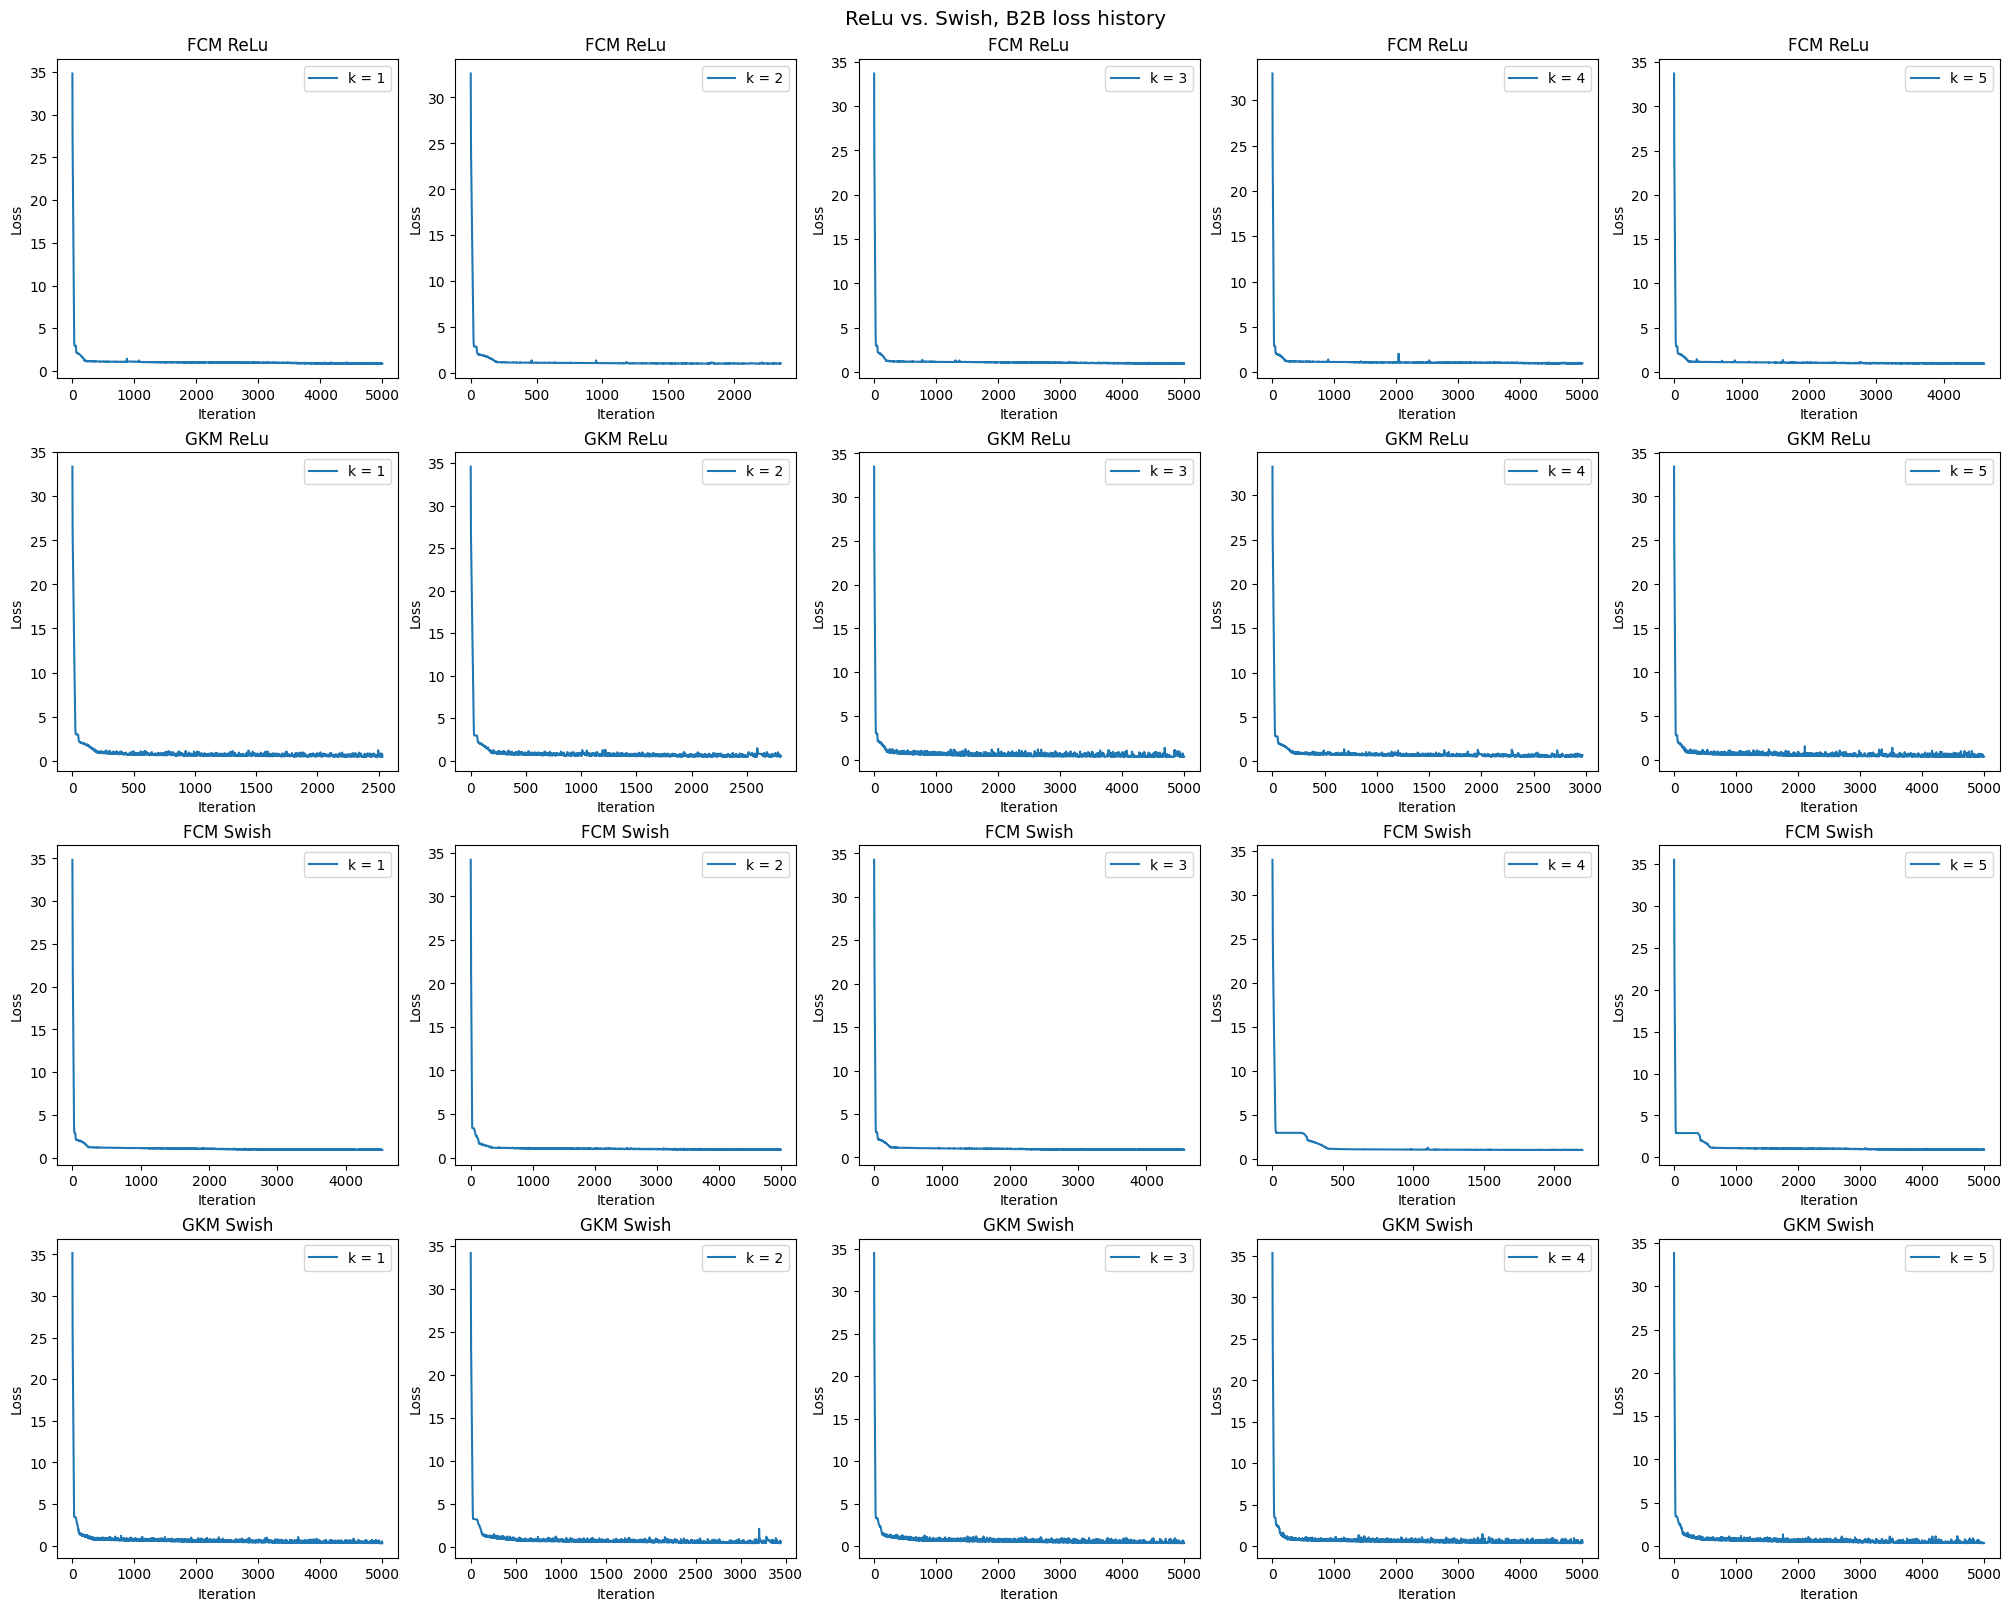

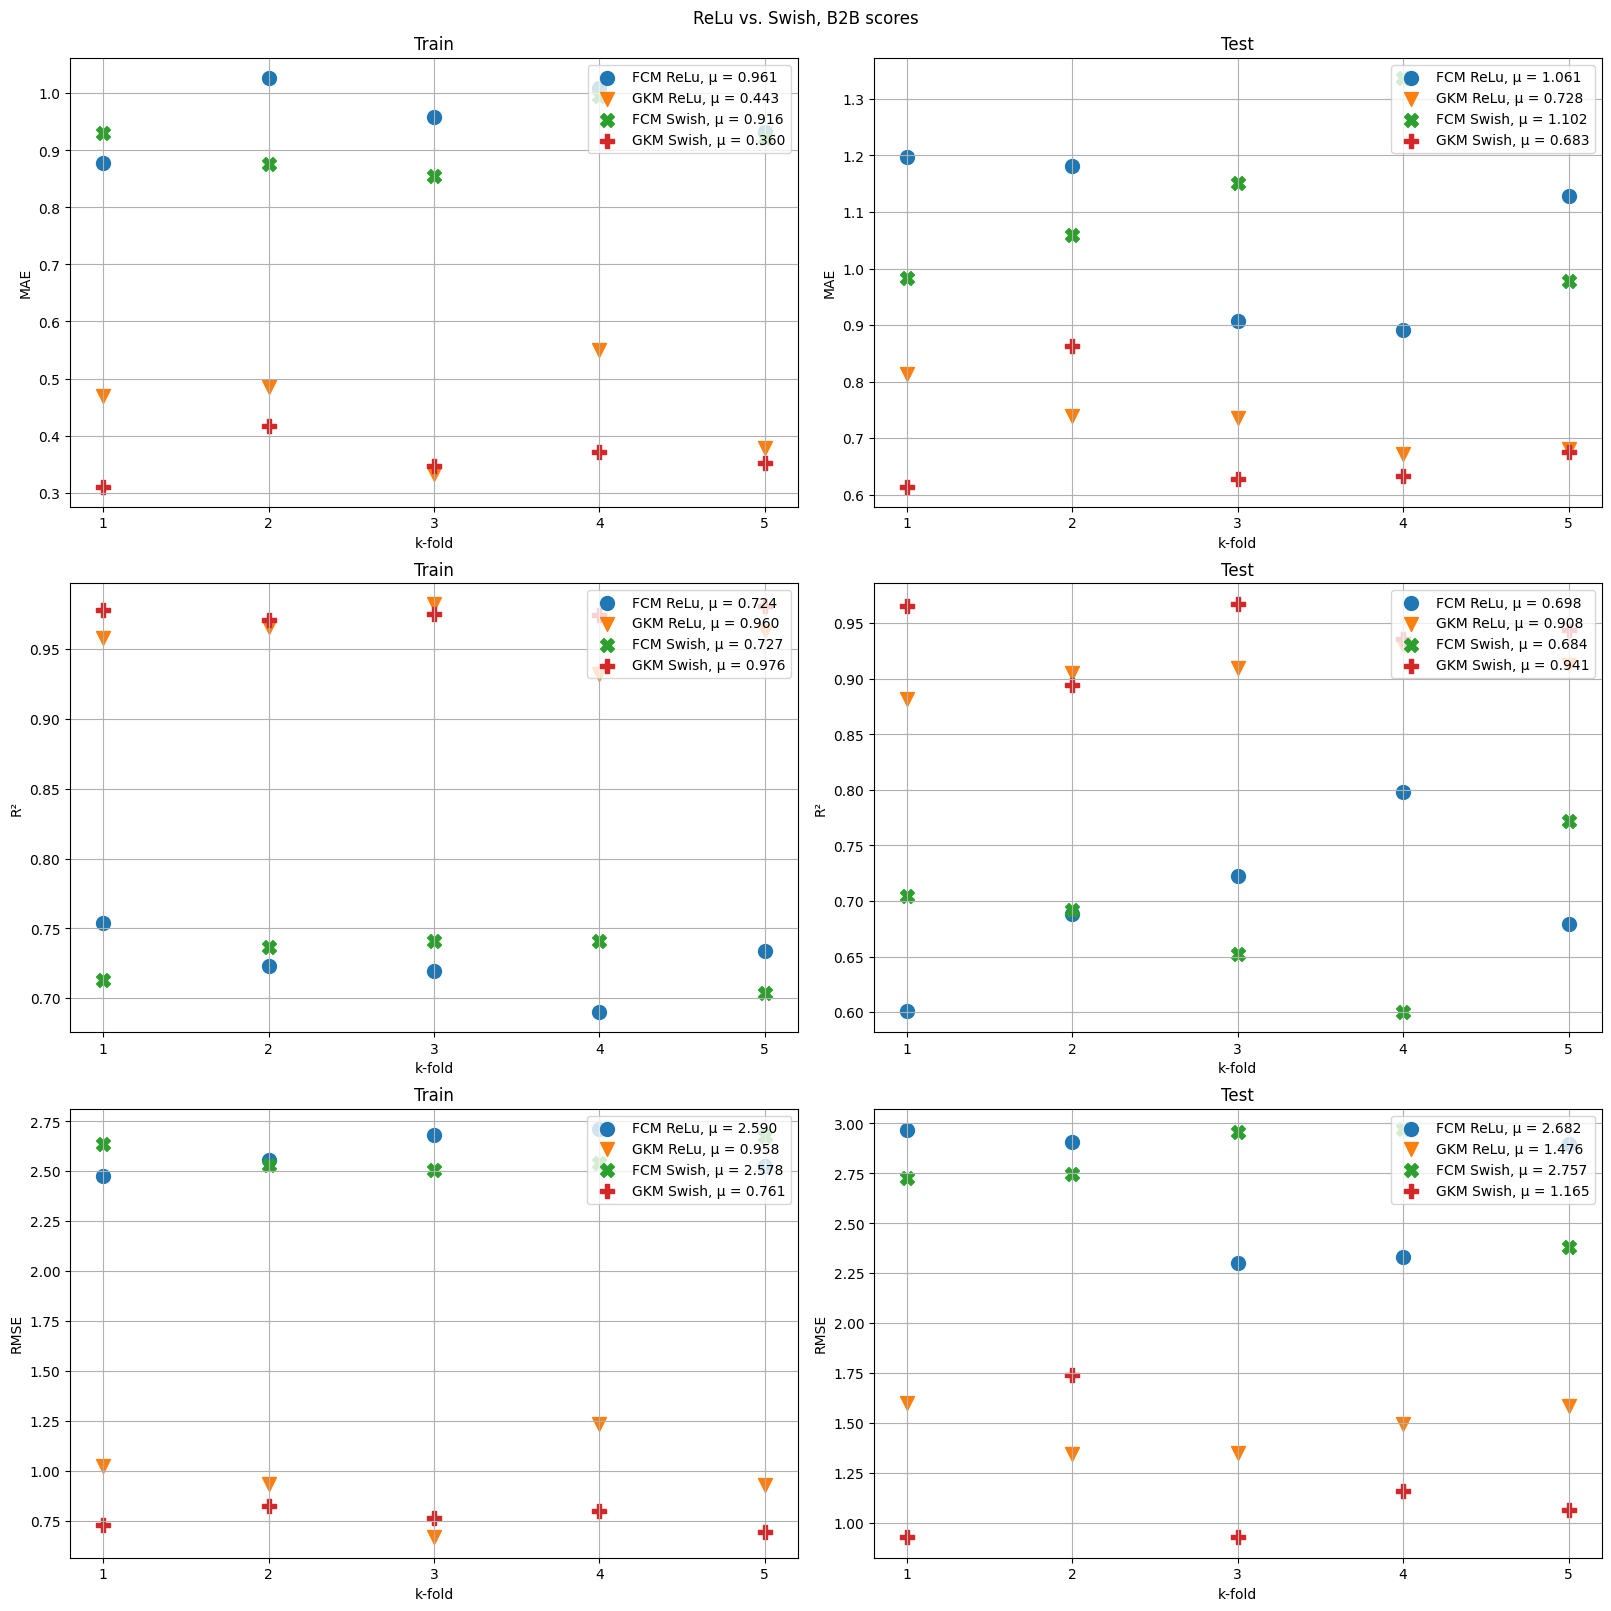

In [47]:
scores = [scores_FCM_relu_B2B, scores_GKM_relu_B2B, scores_FCM_swish_B2B, scores_GKM_swish_B2B]
plot_activations_scores(scores, "ReLu vs. Swish, B2B")

### Crosvalidación para fibra óptica a 0dBm variando la función ReLu por Swish

In [48]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber0 = calc_once("scores_FCM_relu_fiber0", test_model, args)

In [49]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber0 = calc_once("scores_GKM_relu_fiber0", test_model, args)

In [50]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber0 = calc_once("scores_FCM_swish_fiber0", test_model, args)

In [51]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber0 = calc_once("scores_GKM_swish_fiber0", test_model, args)

In [52]:
%store scores_FCM_relu_fiber0
%store scores_GKM_relu_fiber0
%store scores_FCM_swish_fiber0
%store scores_GKM_swish_fiber0

Stored 'scores_FCM_relu_fiber0' (dict)
Stored 'scores_GKM_relu_fiber0' (dict)
Stored 'scores_FCM_swish_fiber0' (dict)
Stored 'scores_GKM_swish_fiber0' (dict)


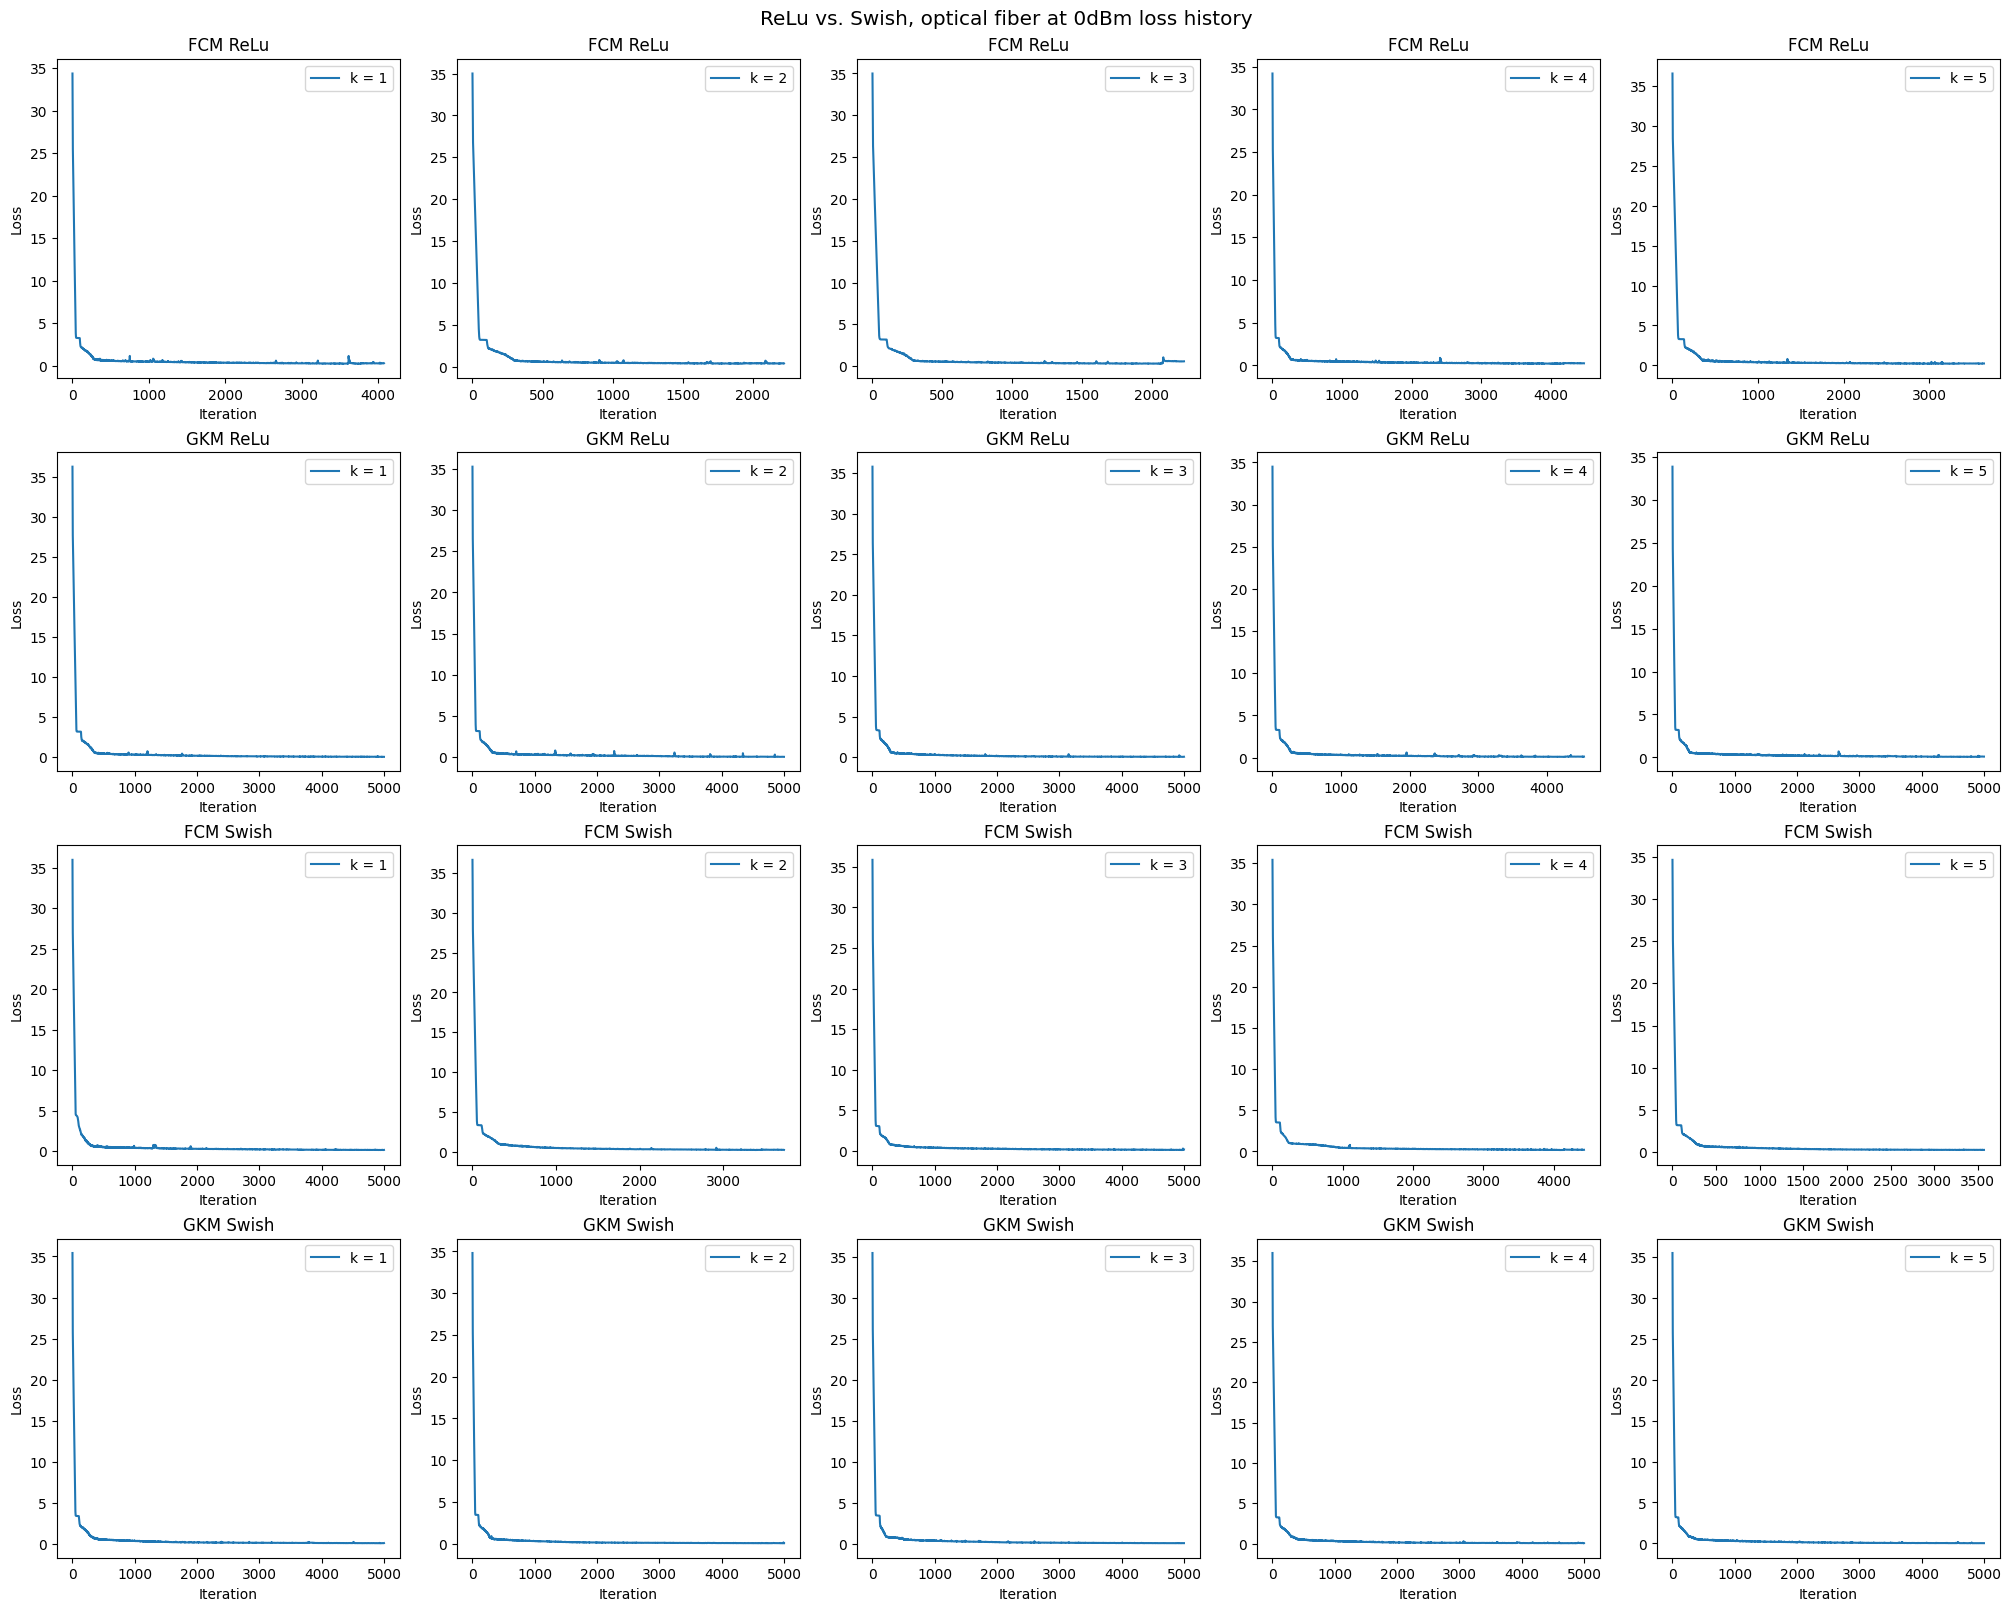

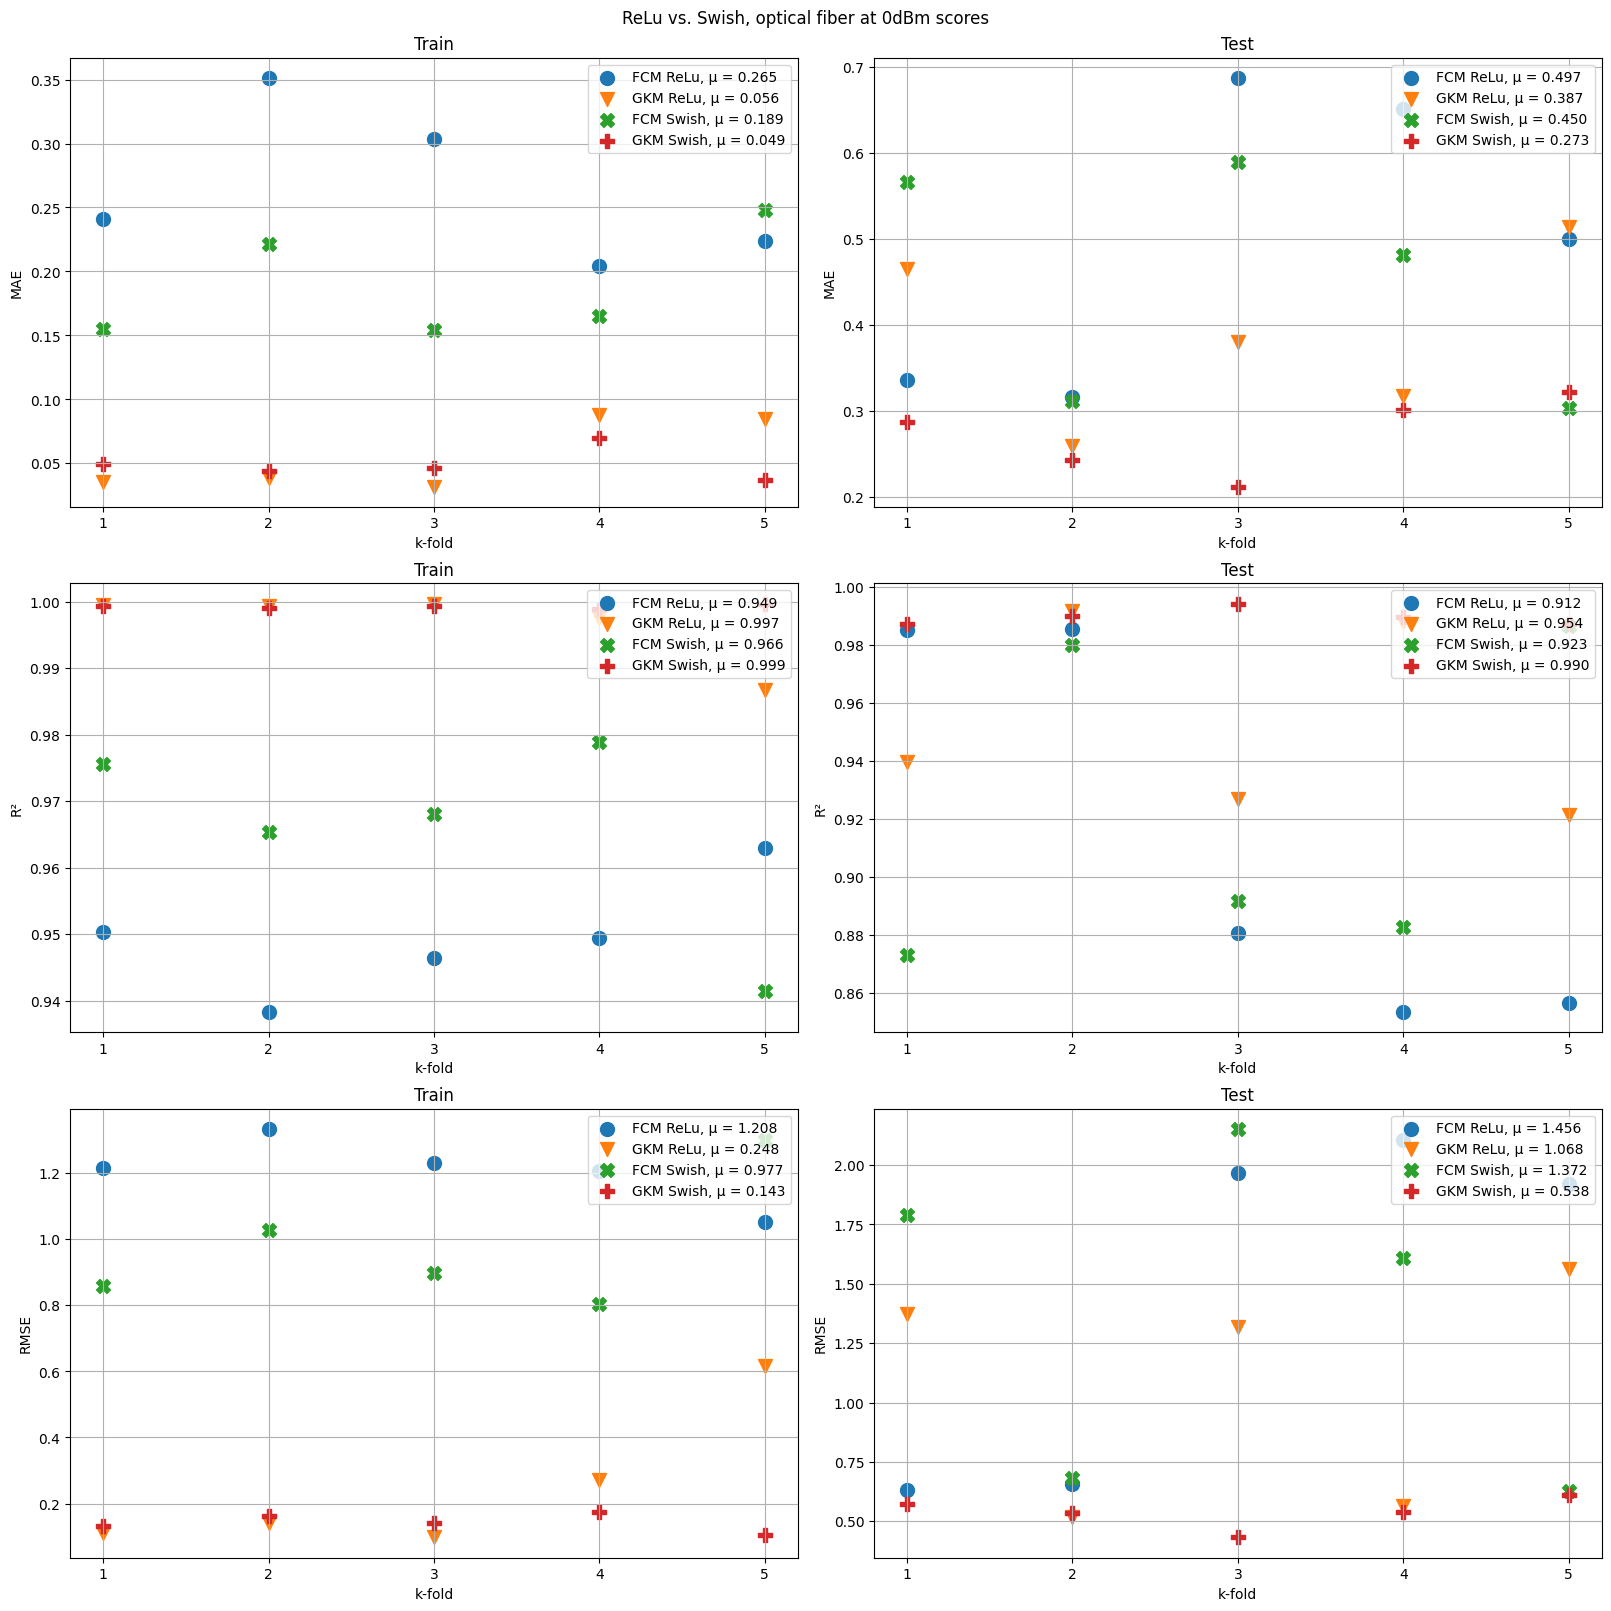

In [53]:
scores = [scores_FCM_relu_fiber0, scores_GKM_relu_fiber0, scores_FCM_swish_fiber0, scores_GKM_swish_fiber0]
plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 0dBm")

### Crosvalidación para fibra óptica a 9dBm variando la función ReLu por Swish

In [54]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber9 = calc_once("scores_FCM_relu_fiber9", test_model, args)

In [55]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber9 = calc_once("scores_GKM_relu_fiber9", test_model, args)

In [56]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber9 = calc_once("scores_FCM_swish_fiber9", test_model, args)

In [57]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber9 = calc_once("scores_GKM_swish_fiber9", test_model, args)

In [58]:
%store scores_FCM_relu_fiber9
%store scores_GKM_relu_fiber9
%store scores_FCM_swish_fiber9
%store scores_GKM_swish_fiber9

Stored 'scores_FCM_relu_fiber9' (dict)
Stored 'scores_GKM_relu_fiber9' (dict)
Stored 'scores_FCM_swish_fiber9' (dict)
Stored 'scores_GKM_swish_fiber9' (dict)


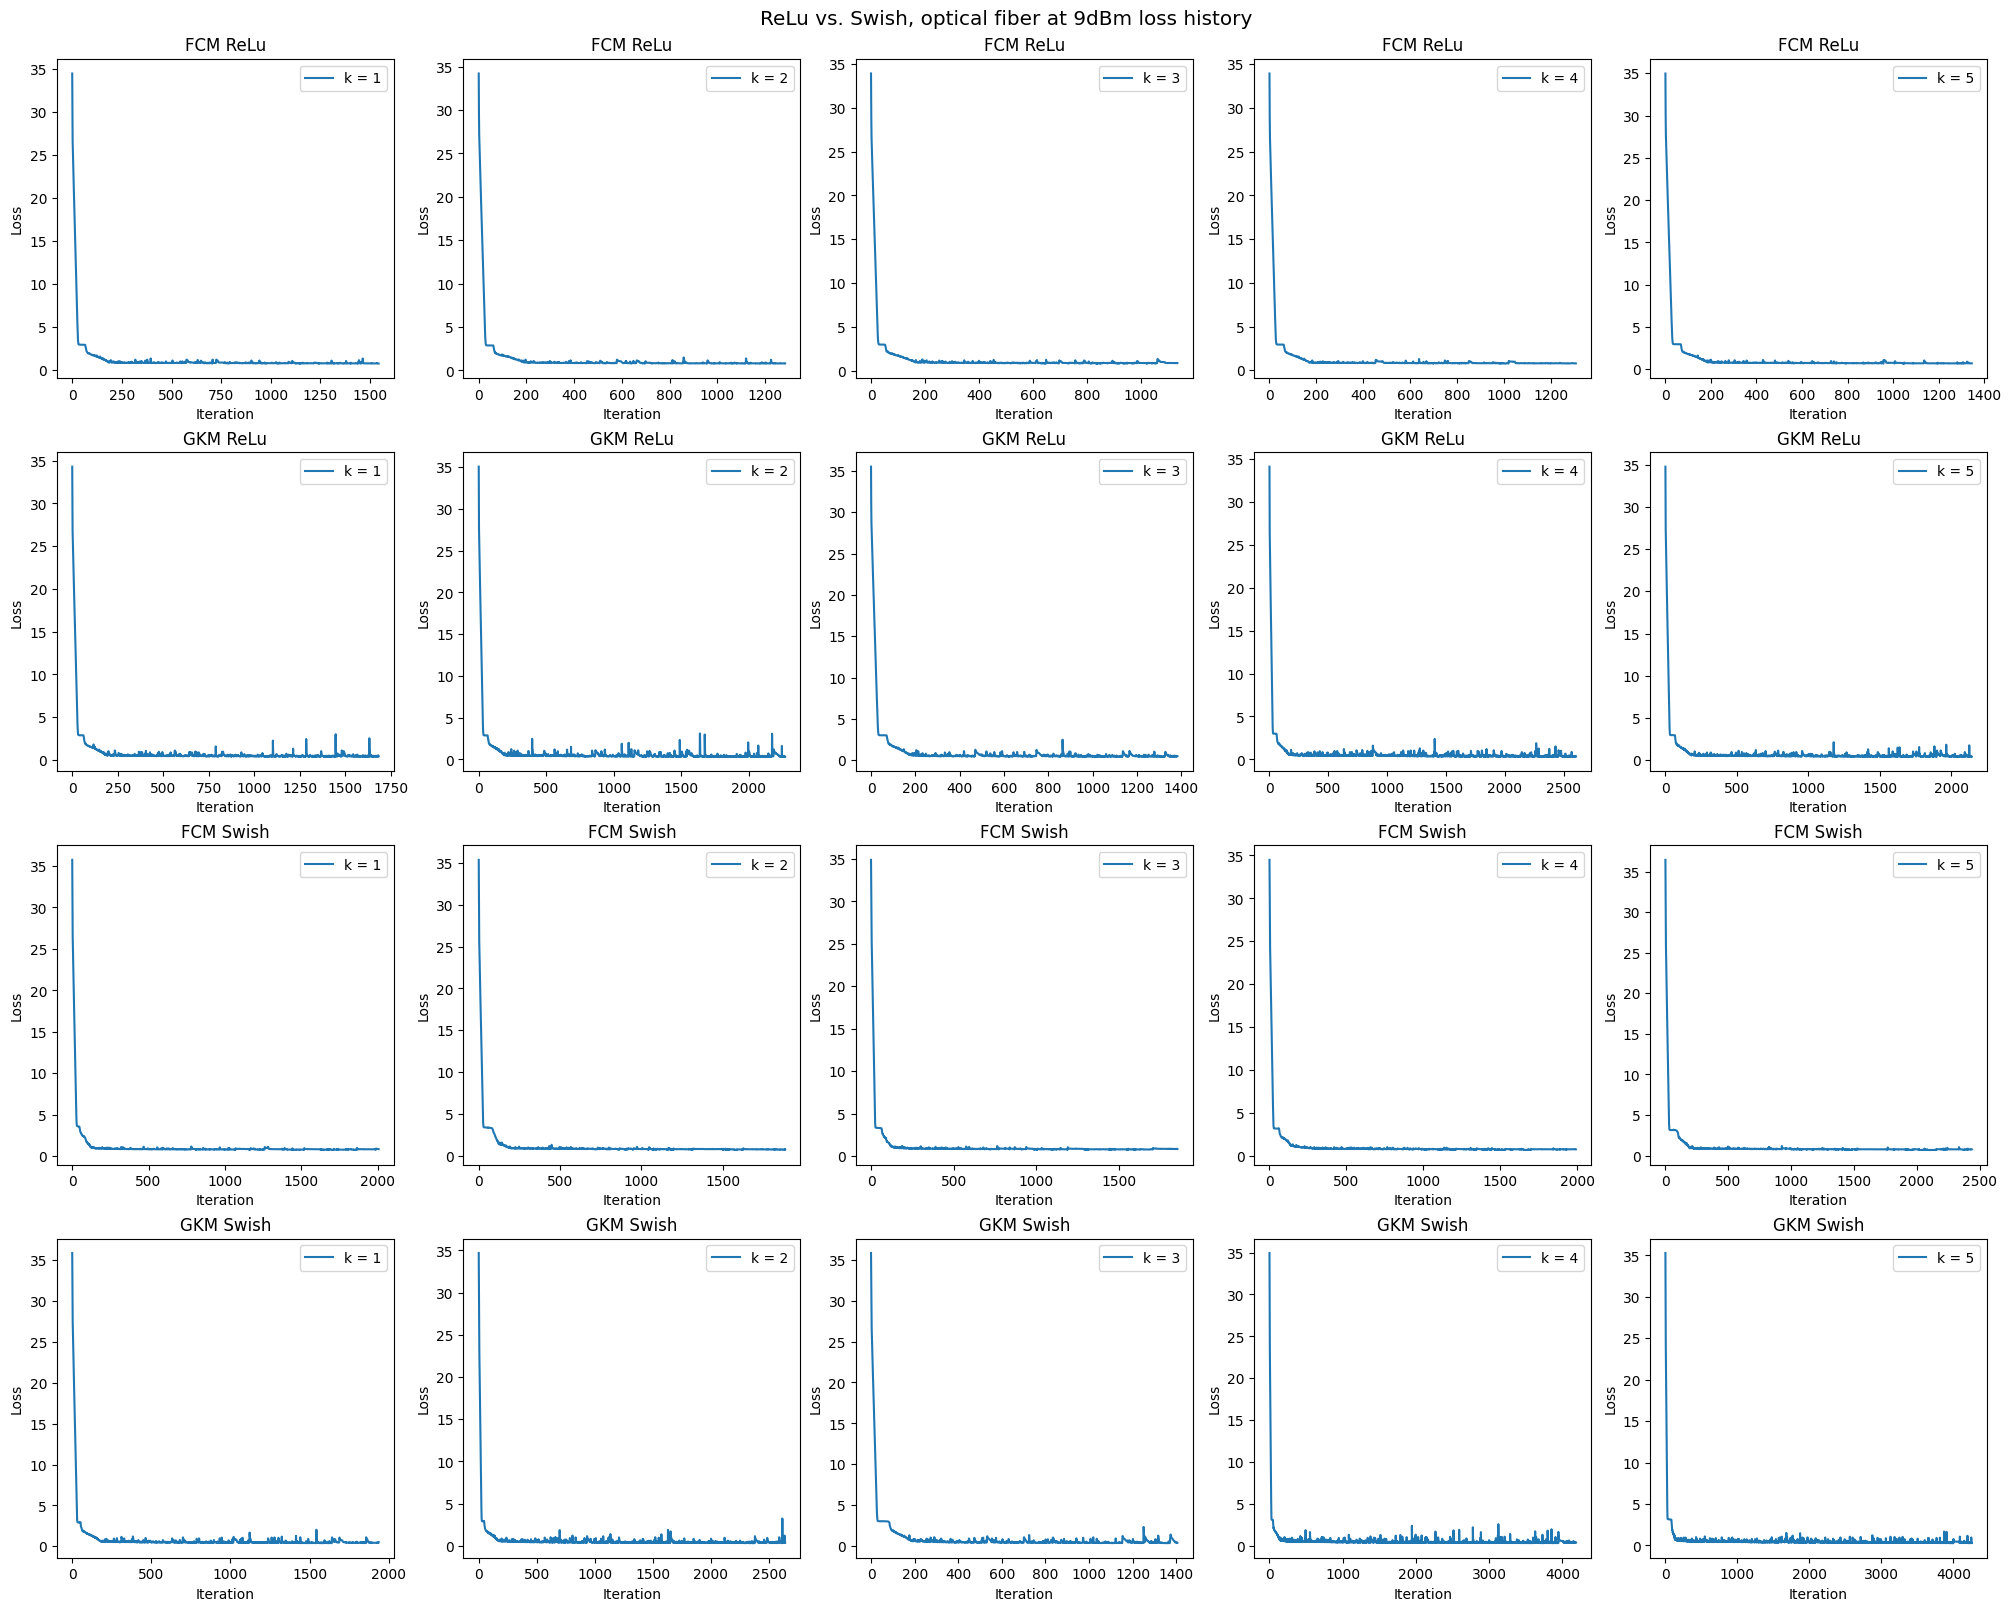

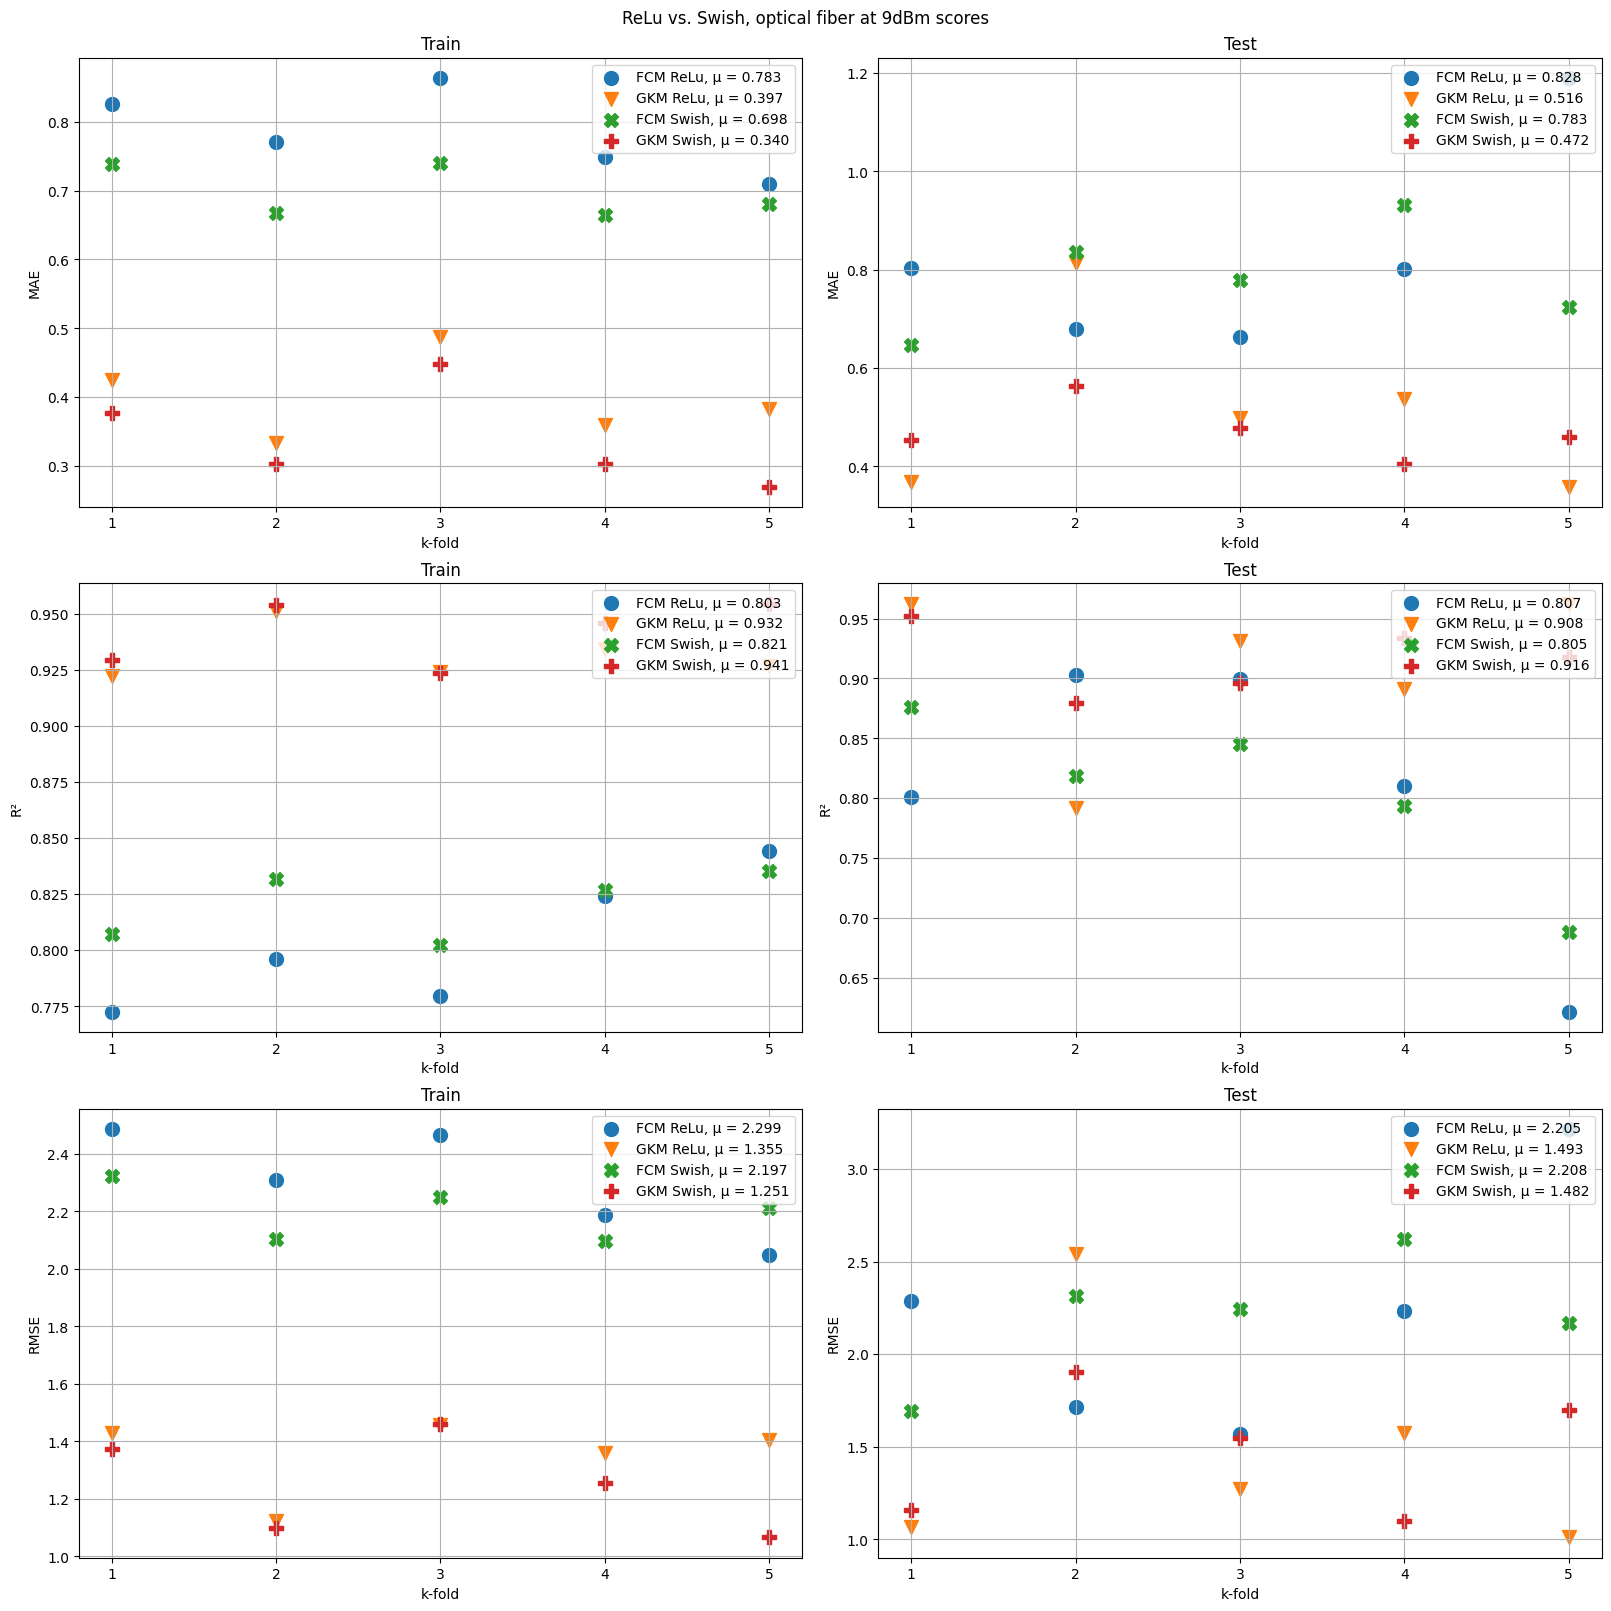

In [59]:
scores = [scores_FCM_relu_fiber9, scores_GKM_relu_fiber9, scores_FCM_swish_fiber9, scores_GKM_swish_fiber9]
plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 9dBm")

## FCM y GKM usando 512 máximo número de neuronas y evaluando el número de capas ocultas

### FCM y GKM en escenario B2B variando el número de capas ocultas

In [60]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_B2B_1HL = calc_once("scores_FCM_B2B_1HL", test_model, args)

In [61]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_B2B_2HL = calc_once("scores_FCM_B2B_2HL", test_model, args)

In [62]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_B2B_3HL = calc_once("scores_FCM_B2B_3HL", test_model, args)

In [63]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_B2B_4HL = calc_once("scores_FCM_B2B_4HL", test_model, args)

In [64]:
%store scores_FCM_B2B_1HL
%store scores_FCM_B2B_2HL
%store scores_FCM_B2B_3HL
%store scores_FCM_B2B_4HL

Stored 'scores_FCM_B2B_1HL' (dict)
Stored 'scores_FCM_B2B_2HL' (dict)
Stored 'scores_FCM_B2B_3HL' (dict)
Stored 'scores_FCM_B2B_4HL' (dict)


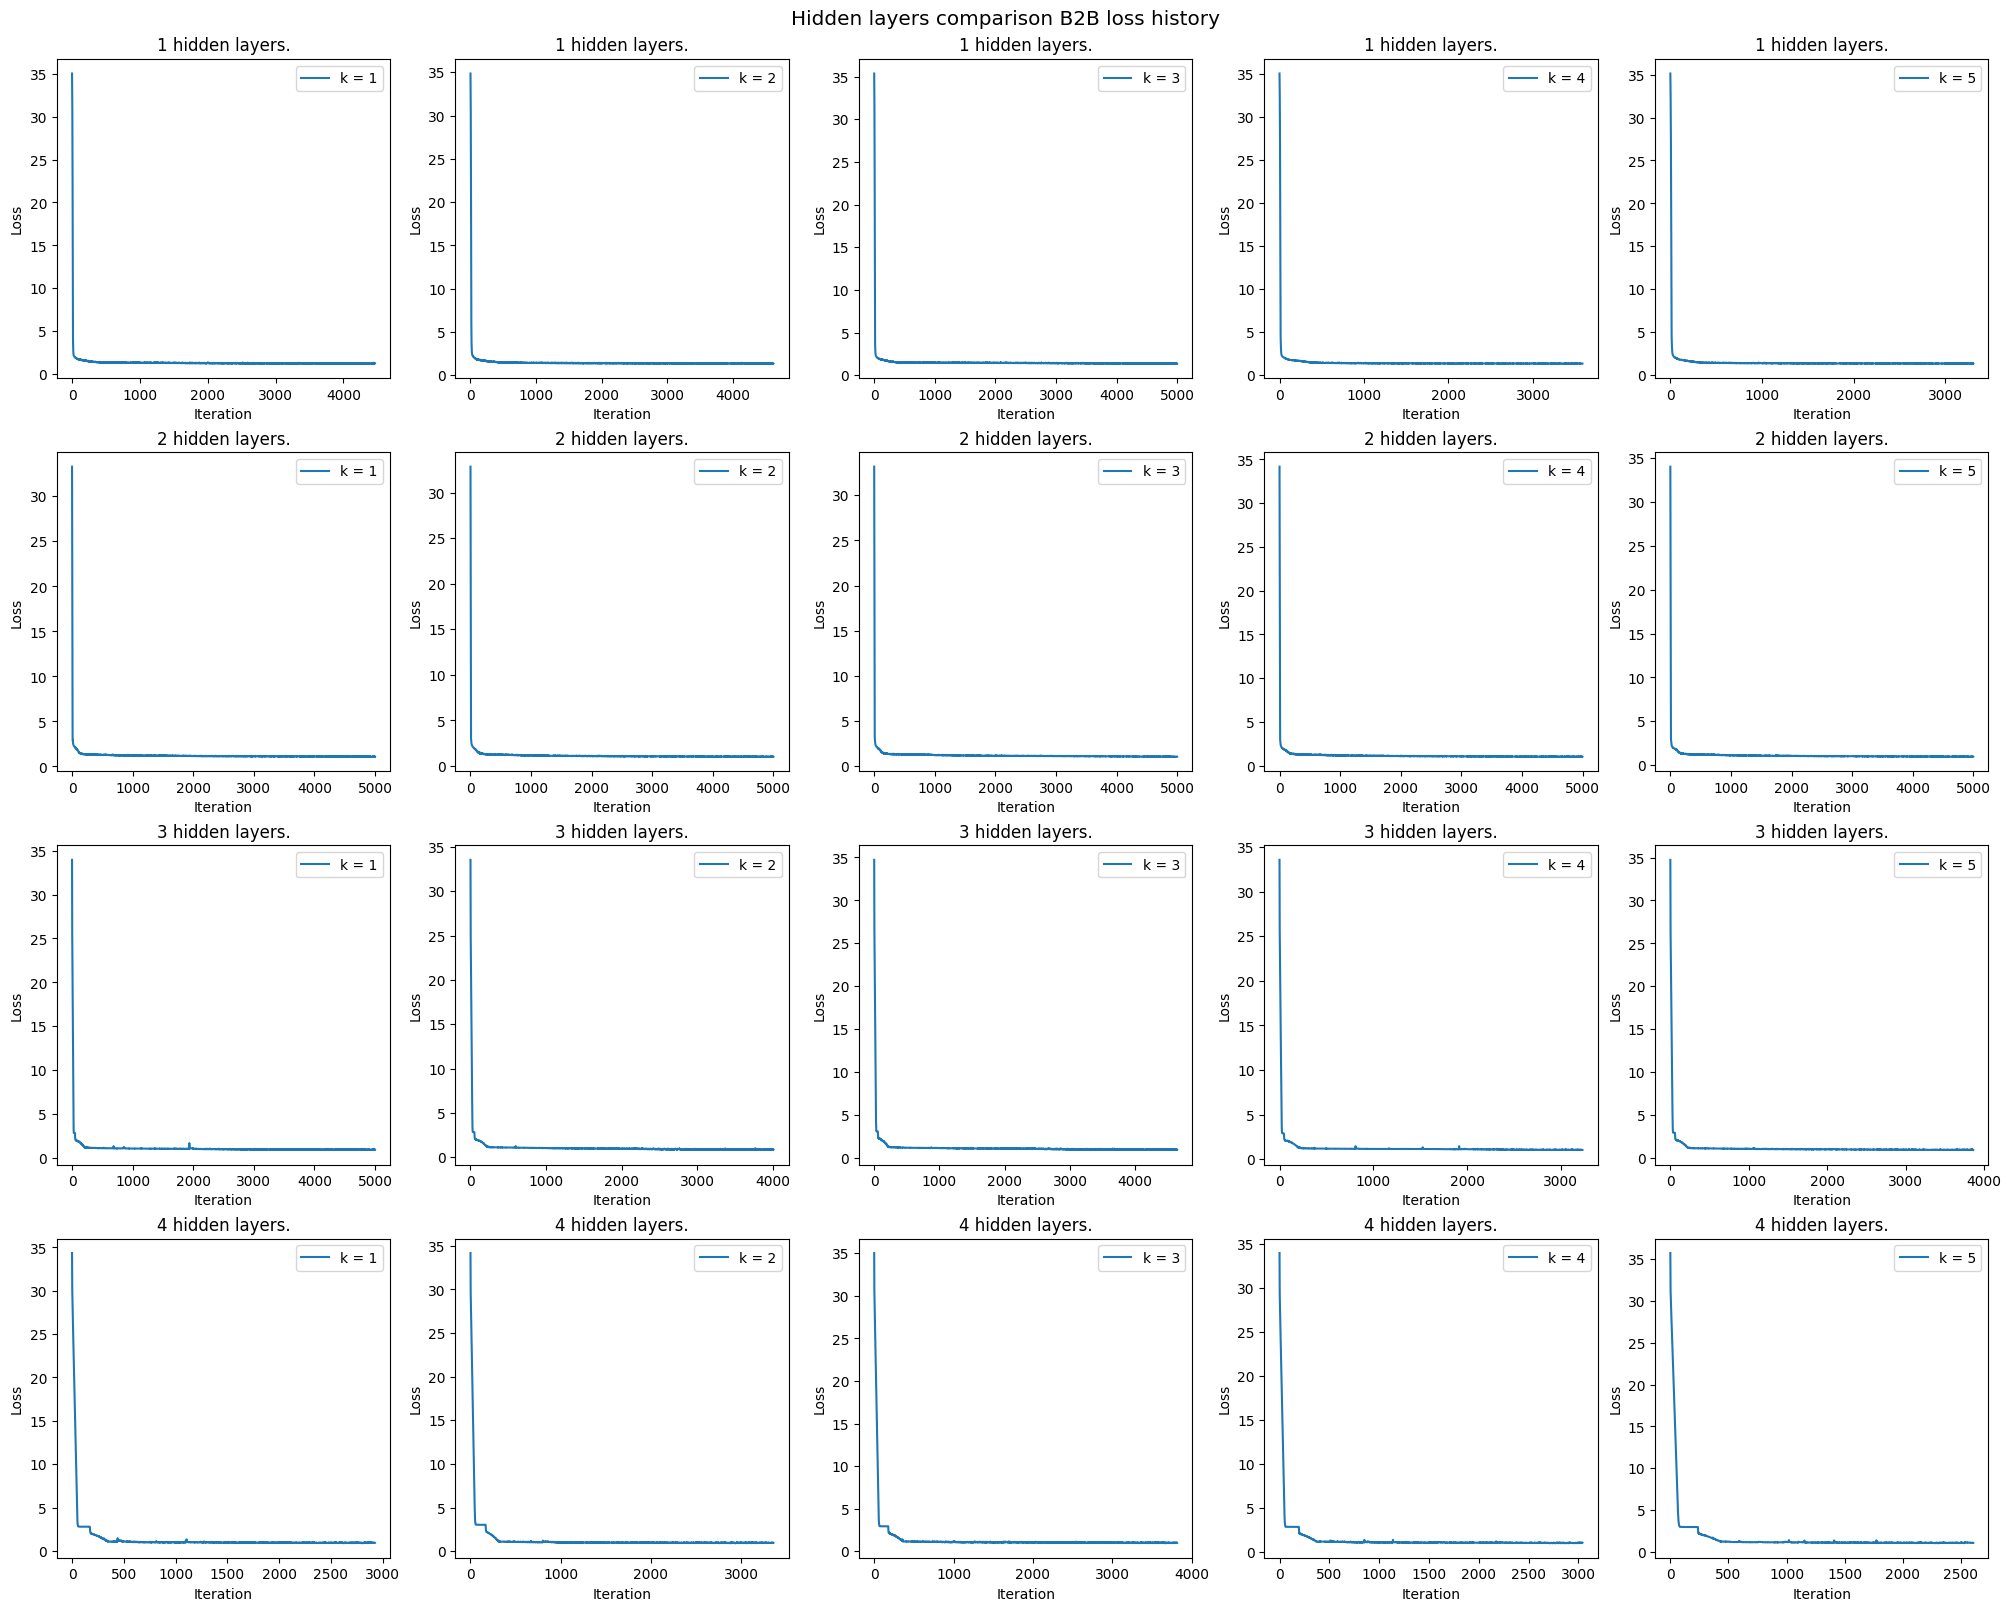

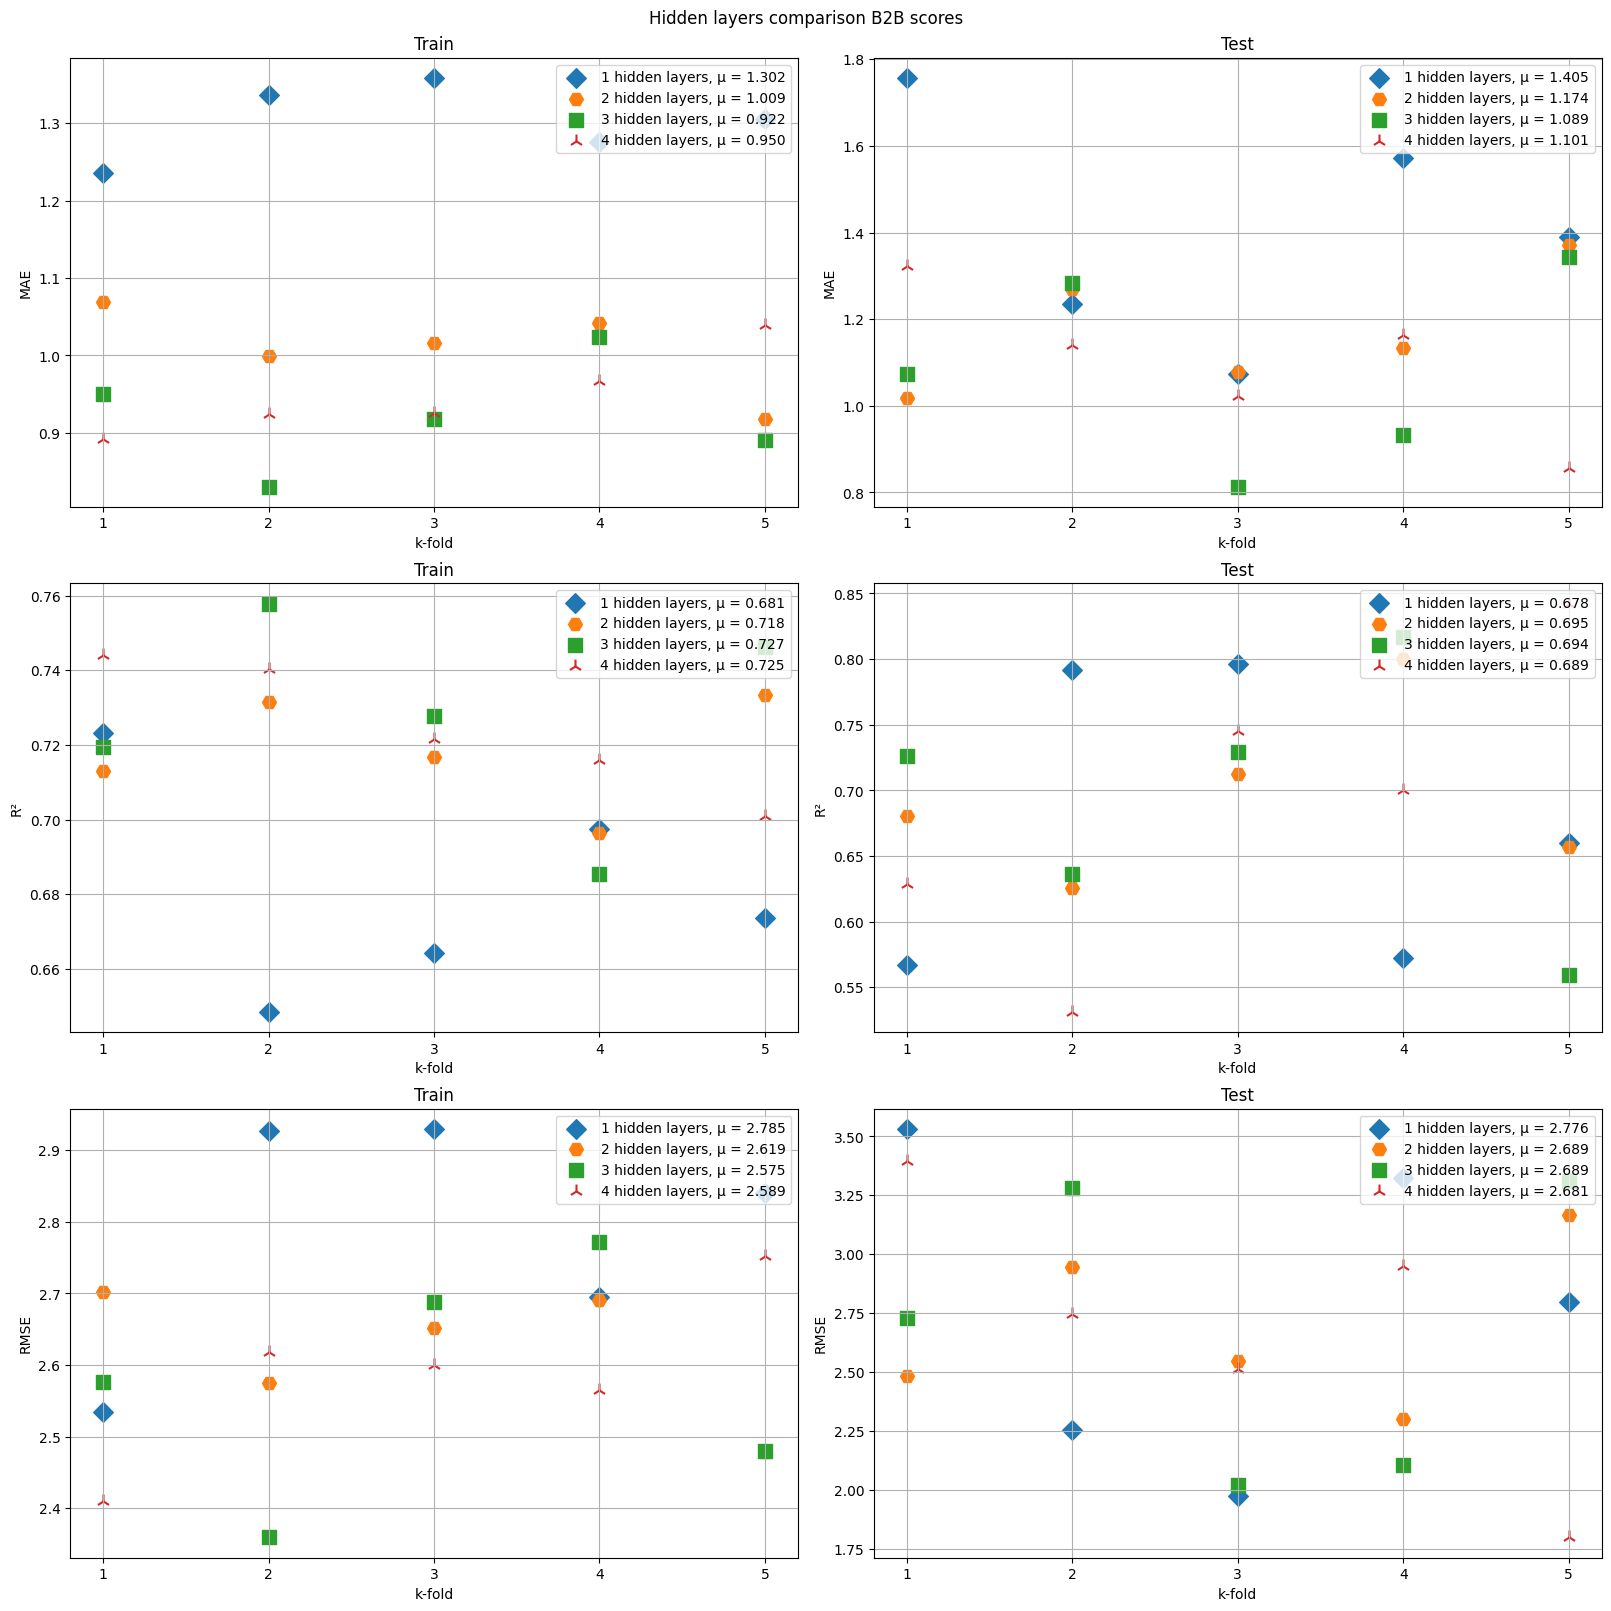

In [65]:
scores = [scores_FCM_B2B_1HL, scores_FCM_B2B_2HL, scores_FCM_B2B_3HL, scores_FCM_B2B_4HL]
plot_layers_scores(scores, "Hidden layers comparison B2B")

### FCM y GKM en escenario con fibra óptica a 0dBm variando el número de capas ocultas

In [66]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber0_1HL = calc_once("scores_FCM_fiber0_1HL", test_model, args)

In [67]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber0_2HL = calc_once("scores_FCM_fiber0_2HL", test_model, args)

In [68]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_3HL = calc_once("scores_FCM_fiber0_3HL", test_model, args)

In [69]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_4HL = calc_once("scores_FCM_fiber0_4HL", test_model, args)

In [70]:
%store scores_FCM_fiber0_1HL
%store scores_FCM_fiber0_2HL
%store scores_FCM_fiber0_3HL
%store scores_FCM_fiber0_4HL

Stored 'scores_FCM_fiber0_1HL' (dict)
Stored 'scores_FCM_fiber0_2HL' (dict)
Stored 'scores_FCM_fiber0_3HL' (dict)
Stored 'scores_FCM_fiber0_4HL' (dict)


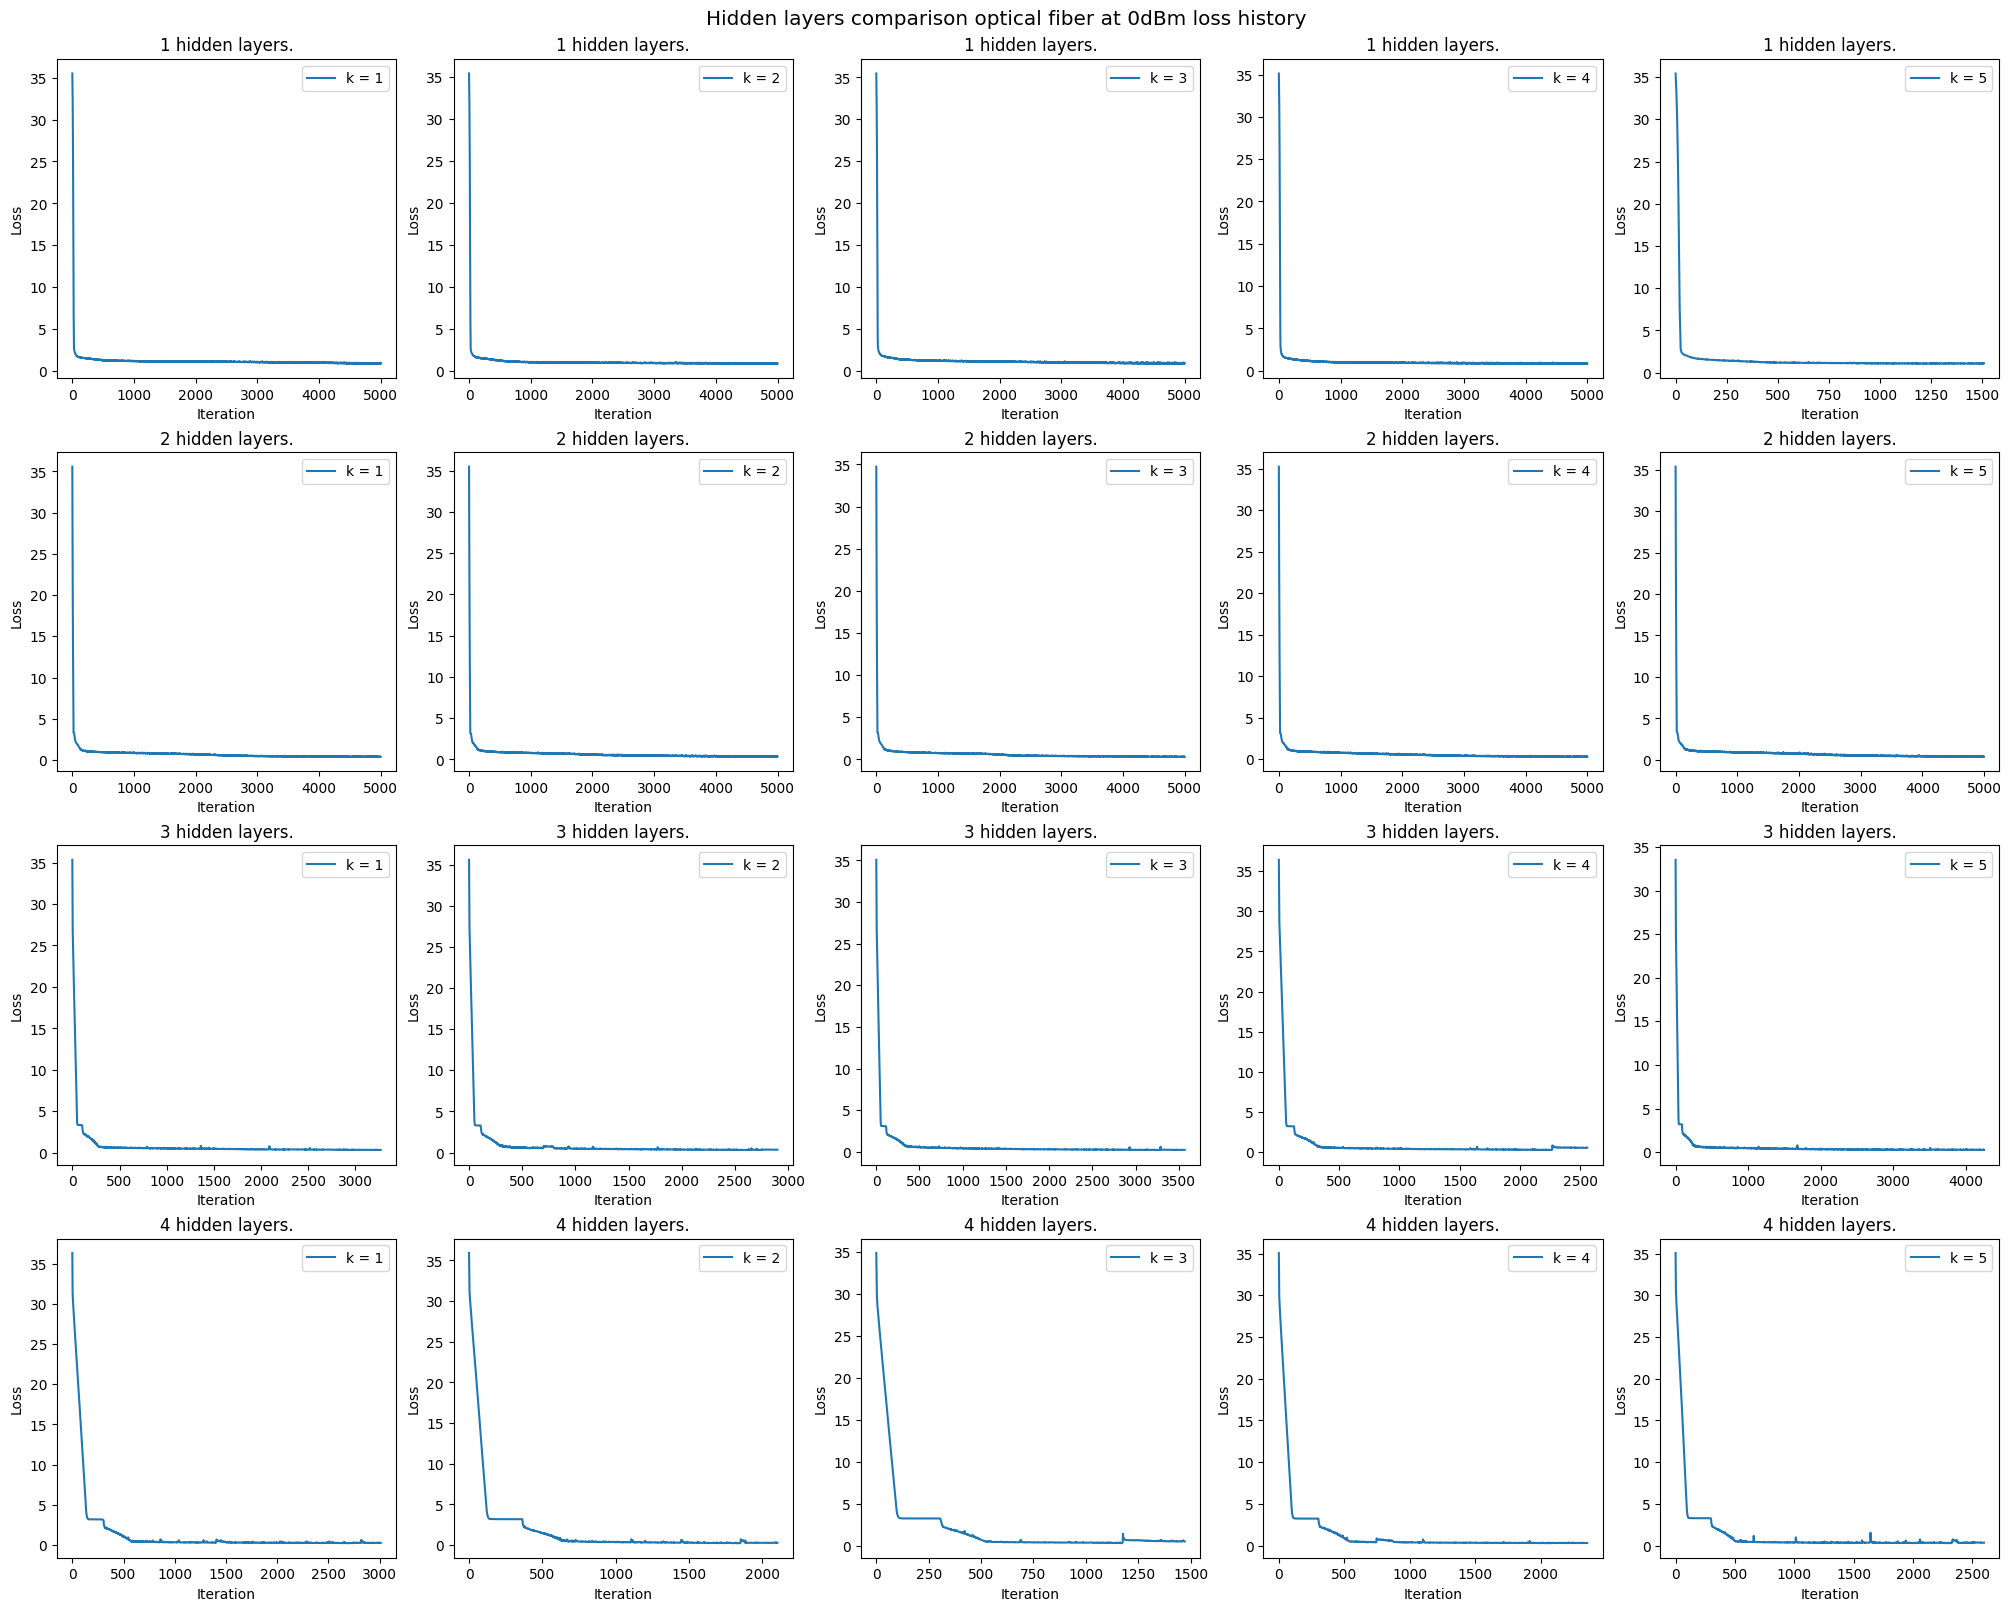

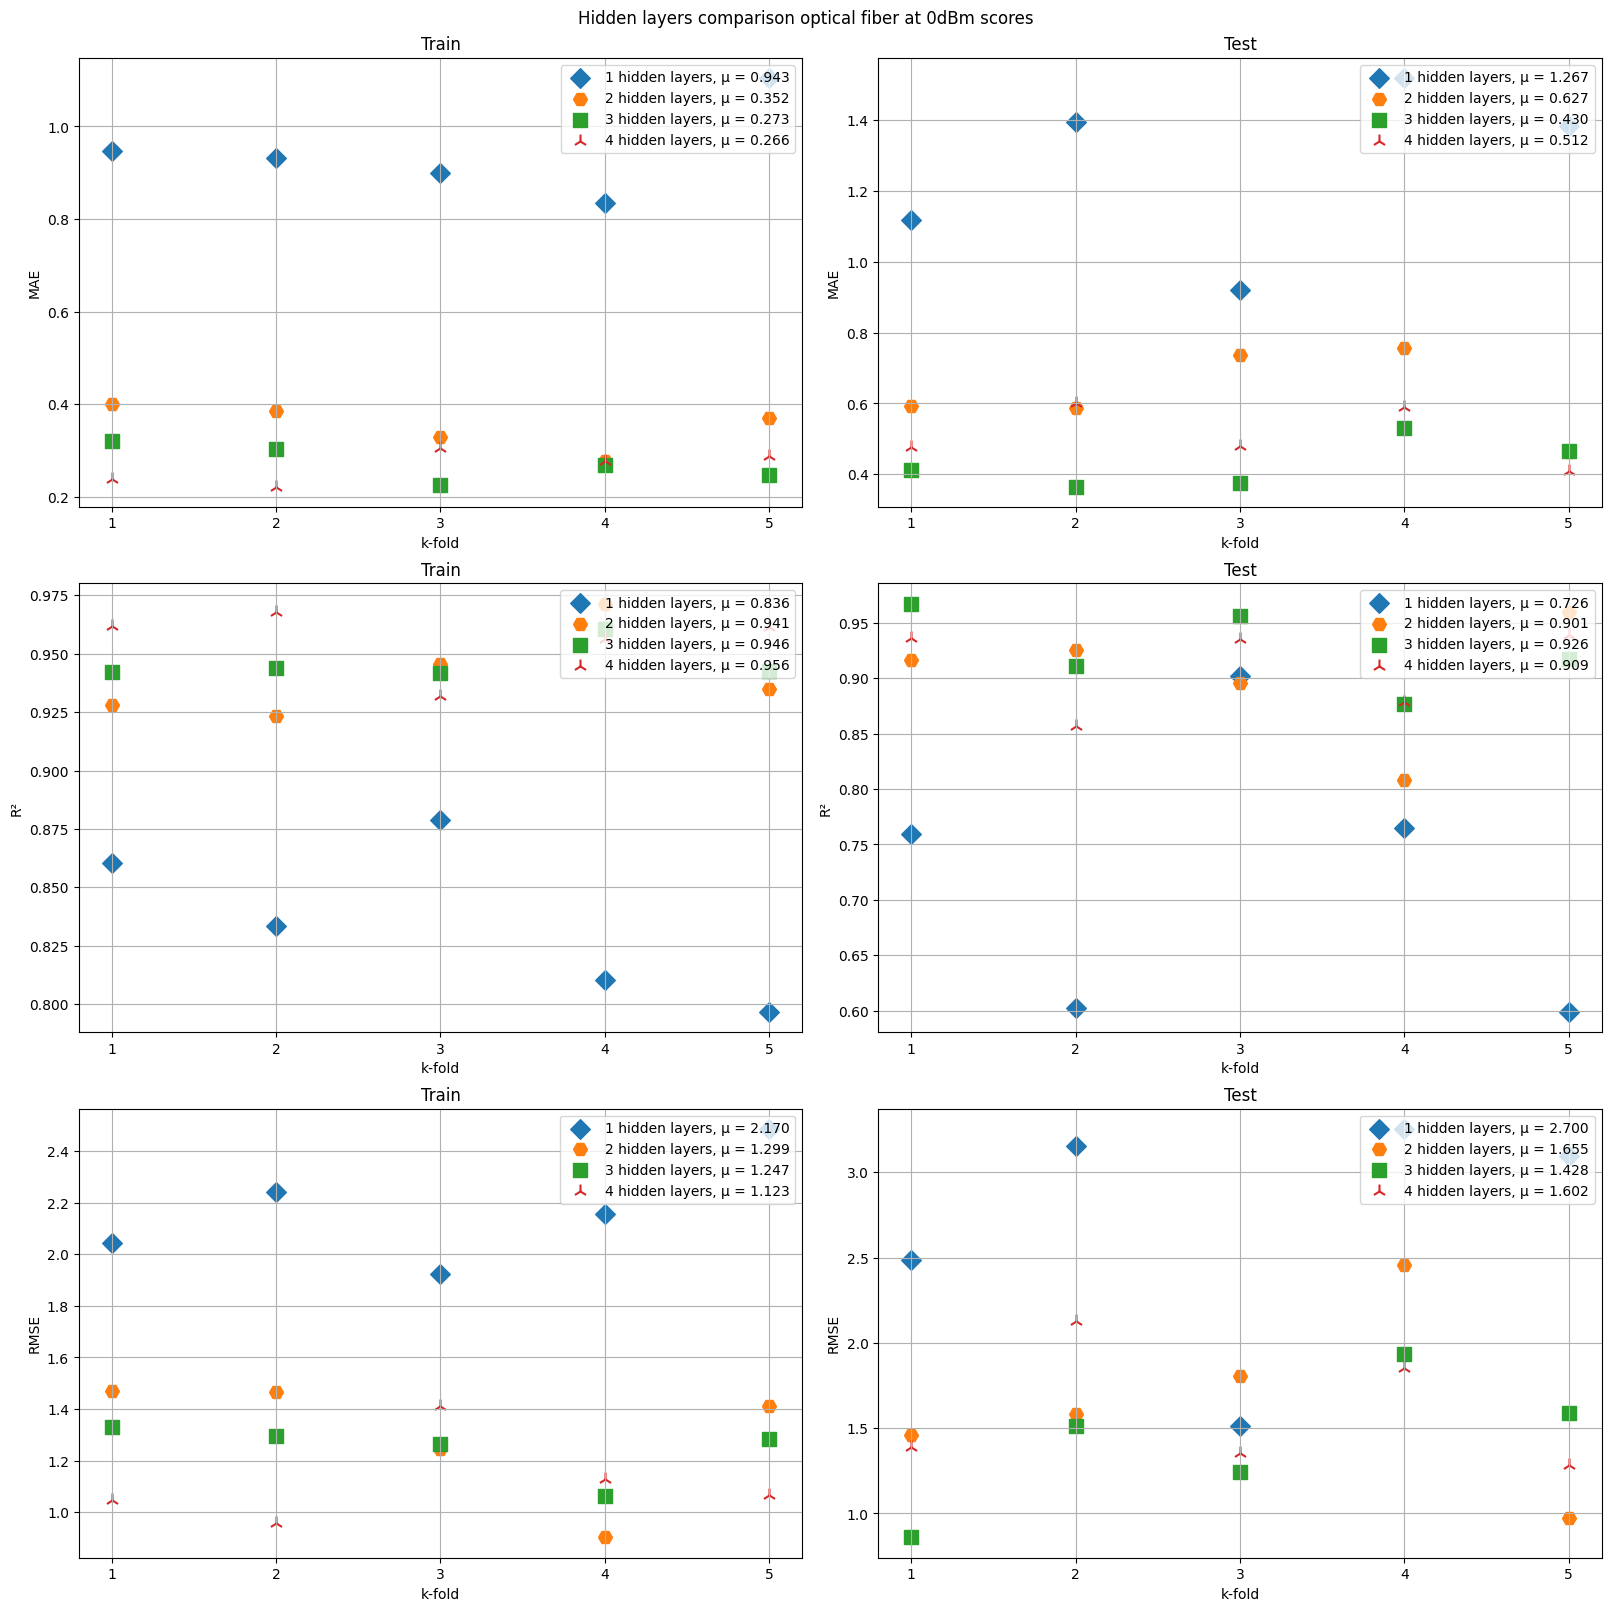

In [71]:
scores = [scores_FCM_fiber0_1HL, scores_FCM_fiber0_2HL, scores_FCM_fiber0_3HL, scores_FCM_fiber0_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 0dBm")

### FCM y GKM en escenario con fibra óptica a 9dBm variando el número de capas ocultas

In [72]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber9_1HL = calc_once("scores_FCM_fiber9_1HL", test_model, args)

In [73]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber9_2HL = calc_once("scores_FCM_fiber9_2HL", test_model, args)

In [74]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_3HL = calc_once("scores_FCM_fiber9_3HL", test_model, args)

In [75]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_4HL = calc_once("scores_FCM_fiber9_4HL", test_model, args)

In [76]:
%store scores_FCM_fiber9_1HL
%store scores_FCM_fiber9_2HL
%store scores_FCM_fiber9_3HL
%store scores_FCM_fiber9_4HL

Stored 'scores_FCM_fiber9_1HL' (dict)
Stored 'scores_FCM_fiber9_2HL' (dict)
Stored 'scores_FCM_fiber9_3HL' (dict)
Stored 'scores_FCM_fiber9_4HL' (dict)


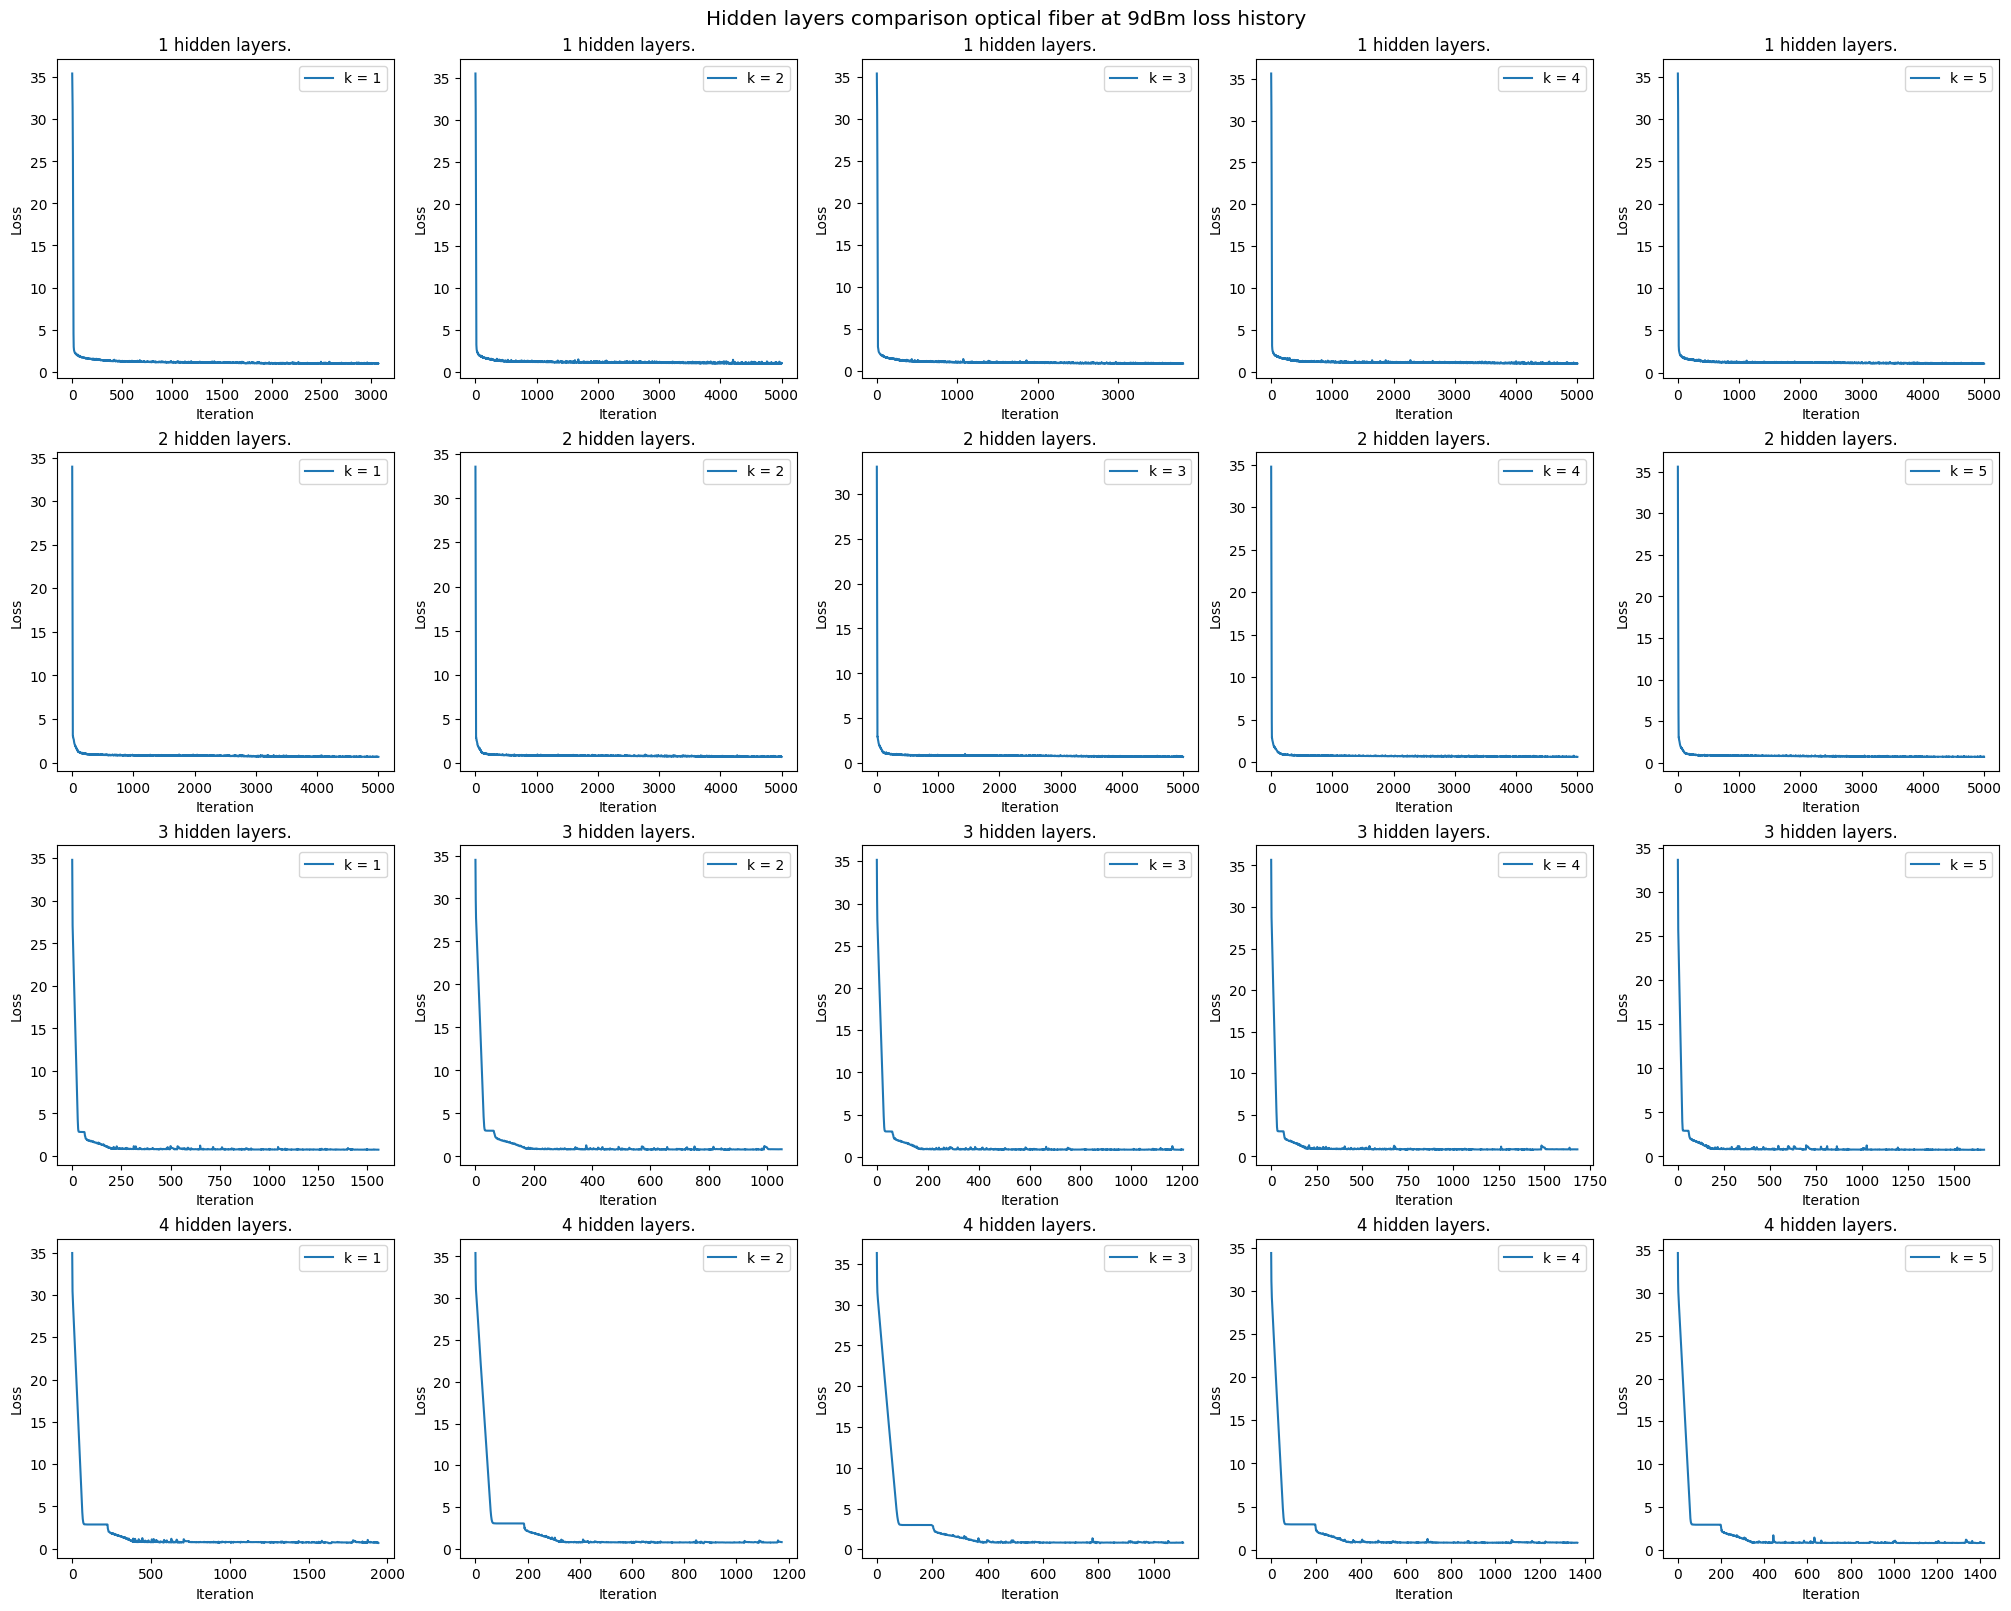

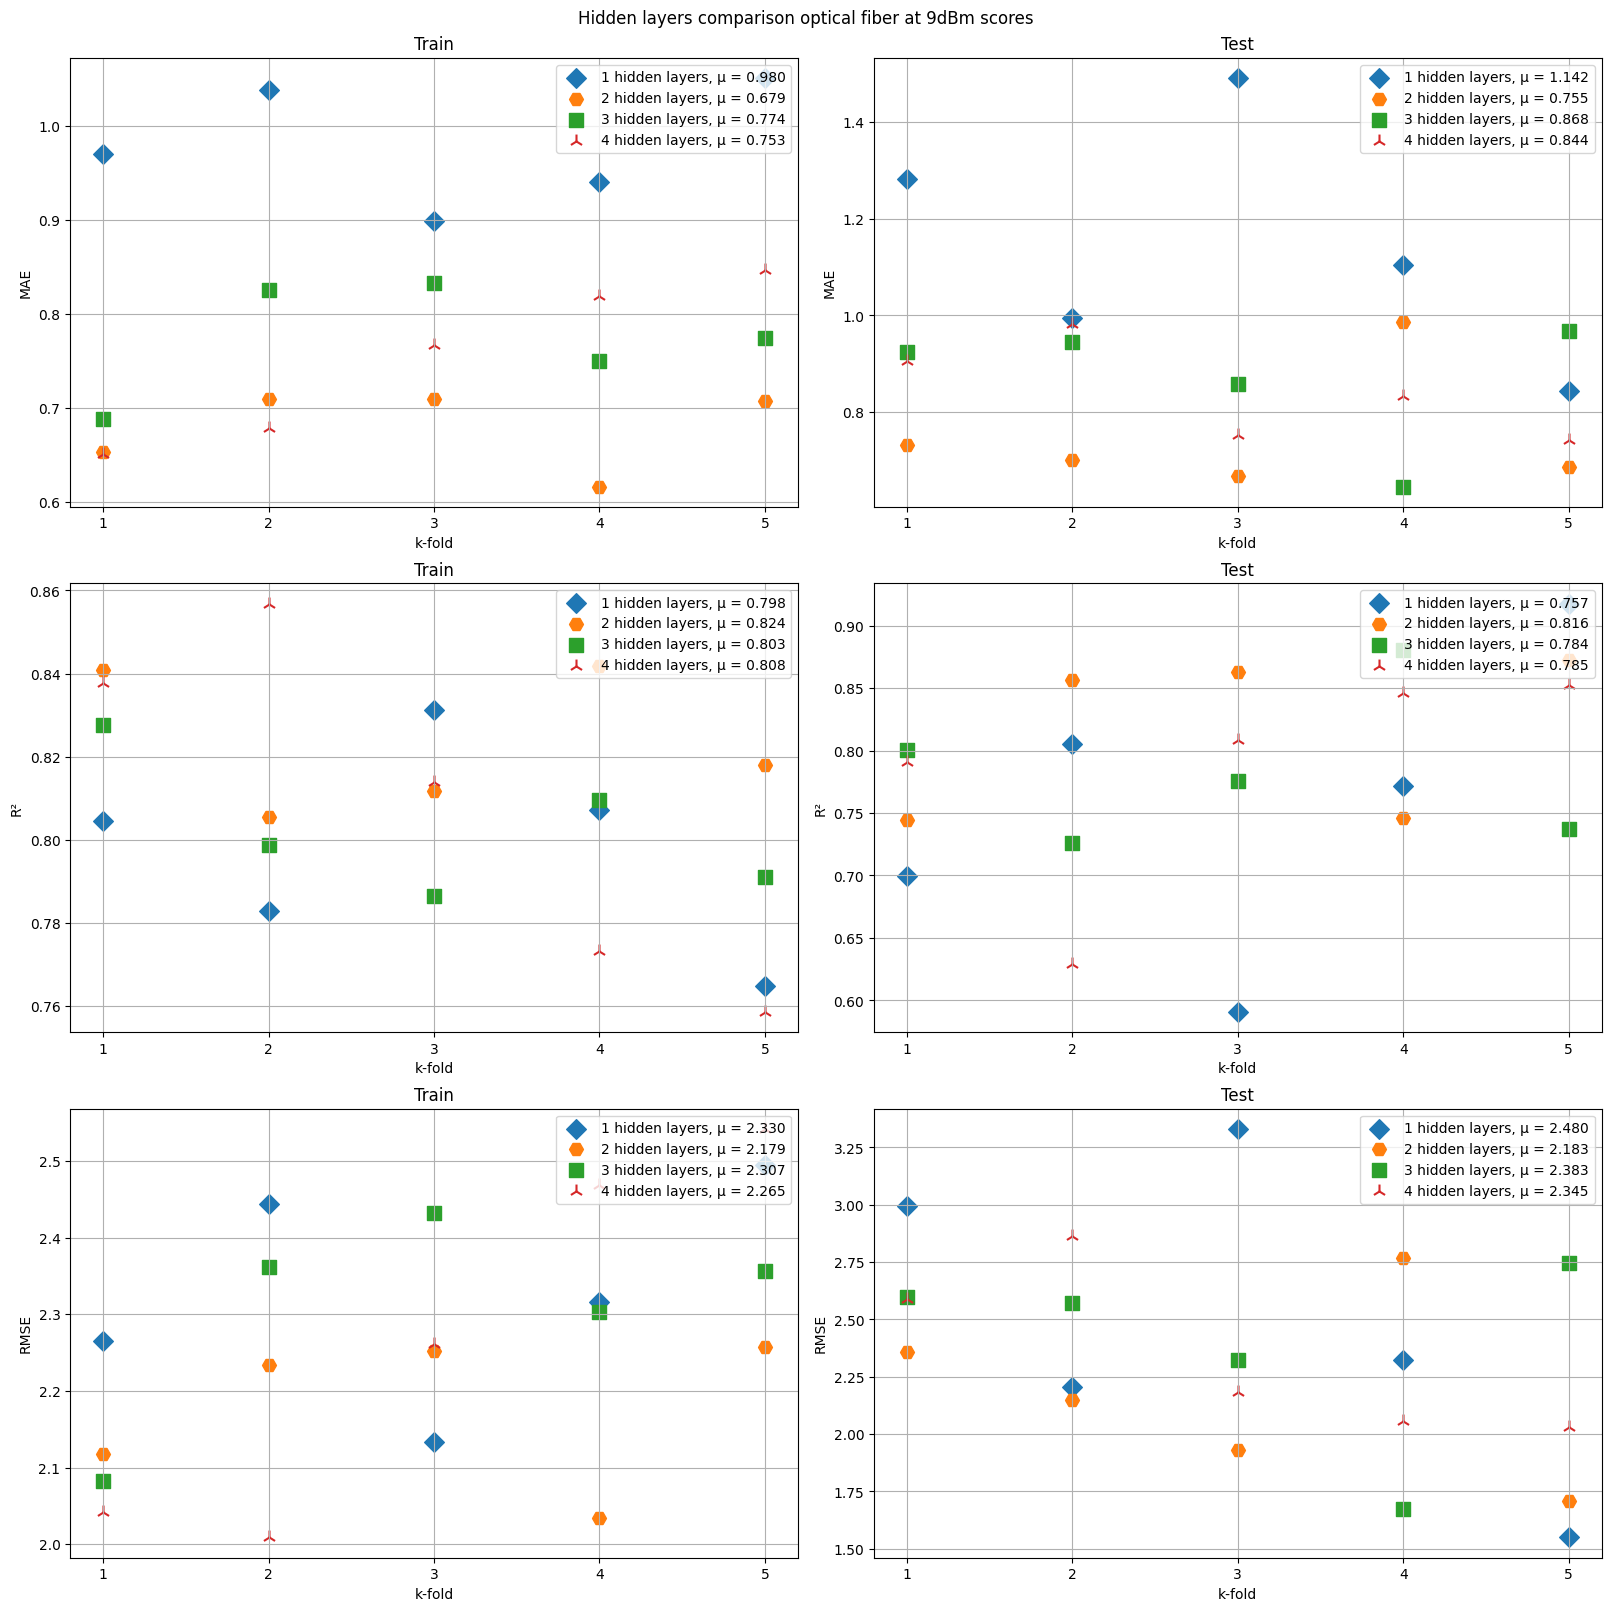

In [77]:
scores = [scores_FCM_fiber9_1HL, scores_FCM_fiber9_2HL, scores_FCM_fiber9_3HL, scores_FCM_fiber9_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 9dBm")

## FCM y GKM usando 256 máximo número de neuronas variando la función de pérdida (MAE vs. RMSE)

### FCM y GKM en escenario B2B variando la función de pérdida

In [93]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_B2B = calc_once("scores_FCM_MAE_B2B", test_model, args)

In [94]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_B2B = calc_once("scores_FCM_MSE_B2B", test_model, args)

In [95]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber0 = calc_once("scores_FCM_MAE_fiber0", test_model, args)

In [96]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber0 = calc_once("scores_FCM_MSE_fiber0", test_model, args)

In [97]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber9 = calc_once("scores_FCM_MAE_fiber9", test_model, args)

In [98]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber9 = calc_once("scores_FCM_MSE_fiber9", test_model, args)

In [99]:
%store scores_FCM_MAE_B2B
%store scores_FCM_MSE_B2B
%store scores_FCM_MAE_fiber0
%store scores_FCM_MSE_fiber0
%store scores_FCM_MAE_fiber9
%store scores_FCM_MSE_fiber9

Stored 'scores_FCM_MAE_B2B' (dict)
Stored 'scores_FCM_MSE_B2B' (dict)
Stored 'scores_FCM_MAE_fiber0' (dict)
Stored 'scores_FCM_MSE_fiber0' (dict)
Stored 'scores_FCM_MAE_fiber9' (dict)
Stored 'scores_FCM_MSE_fiber9' (dict)


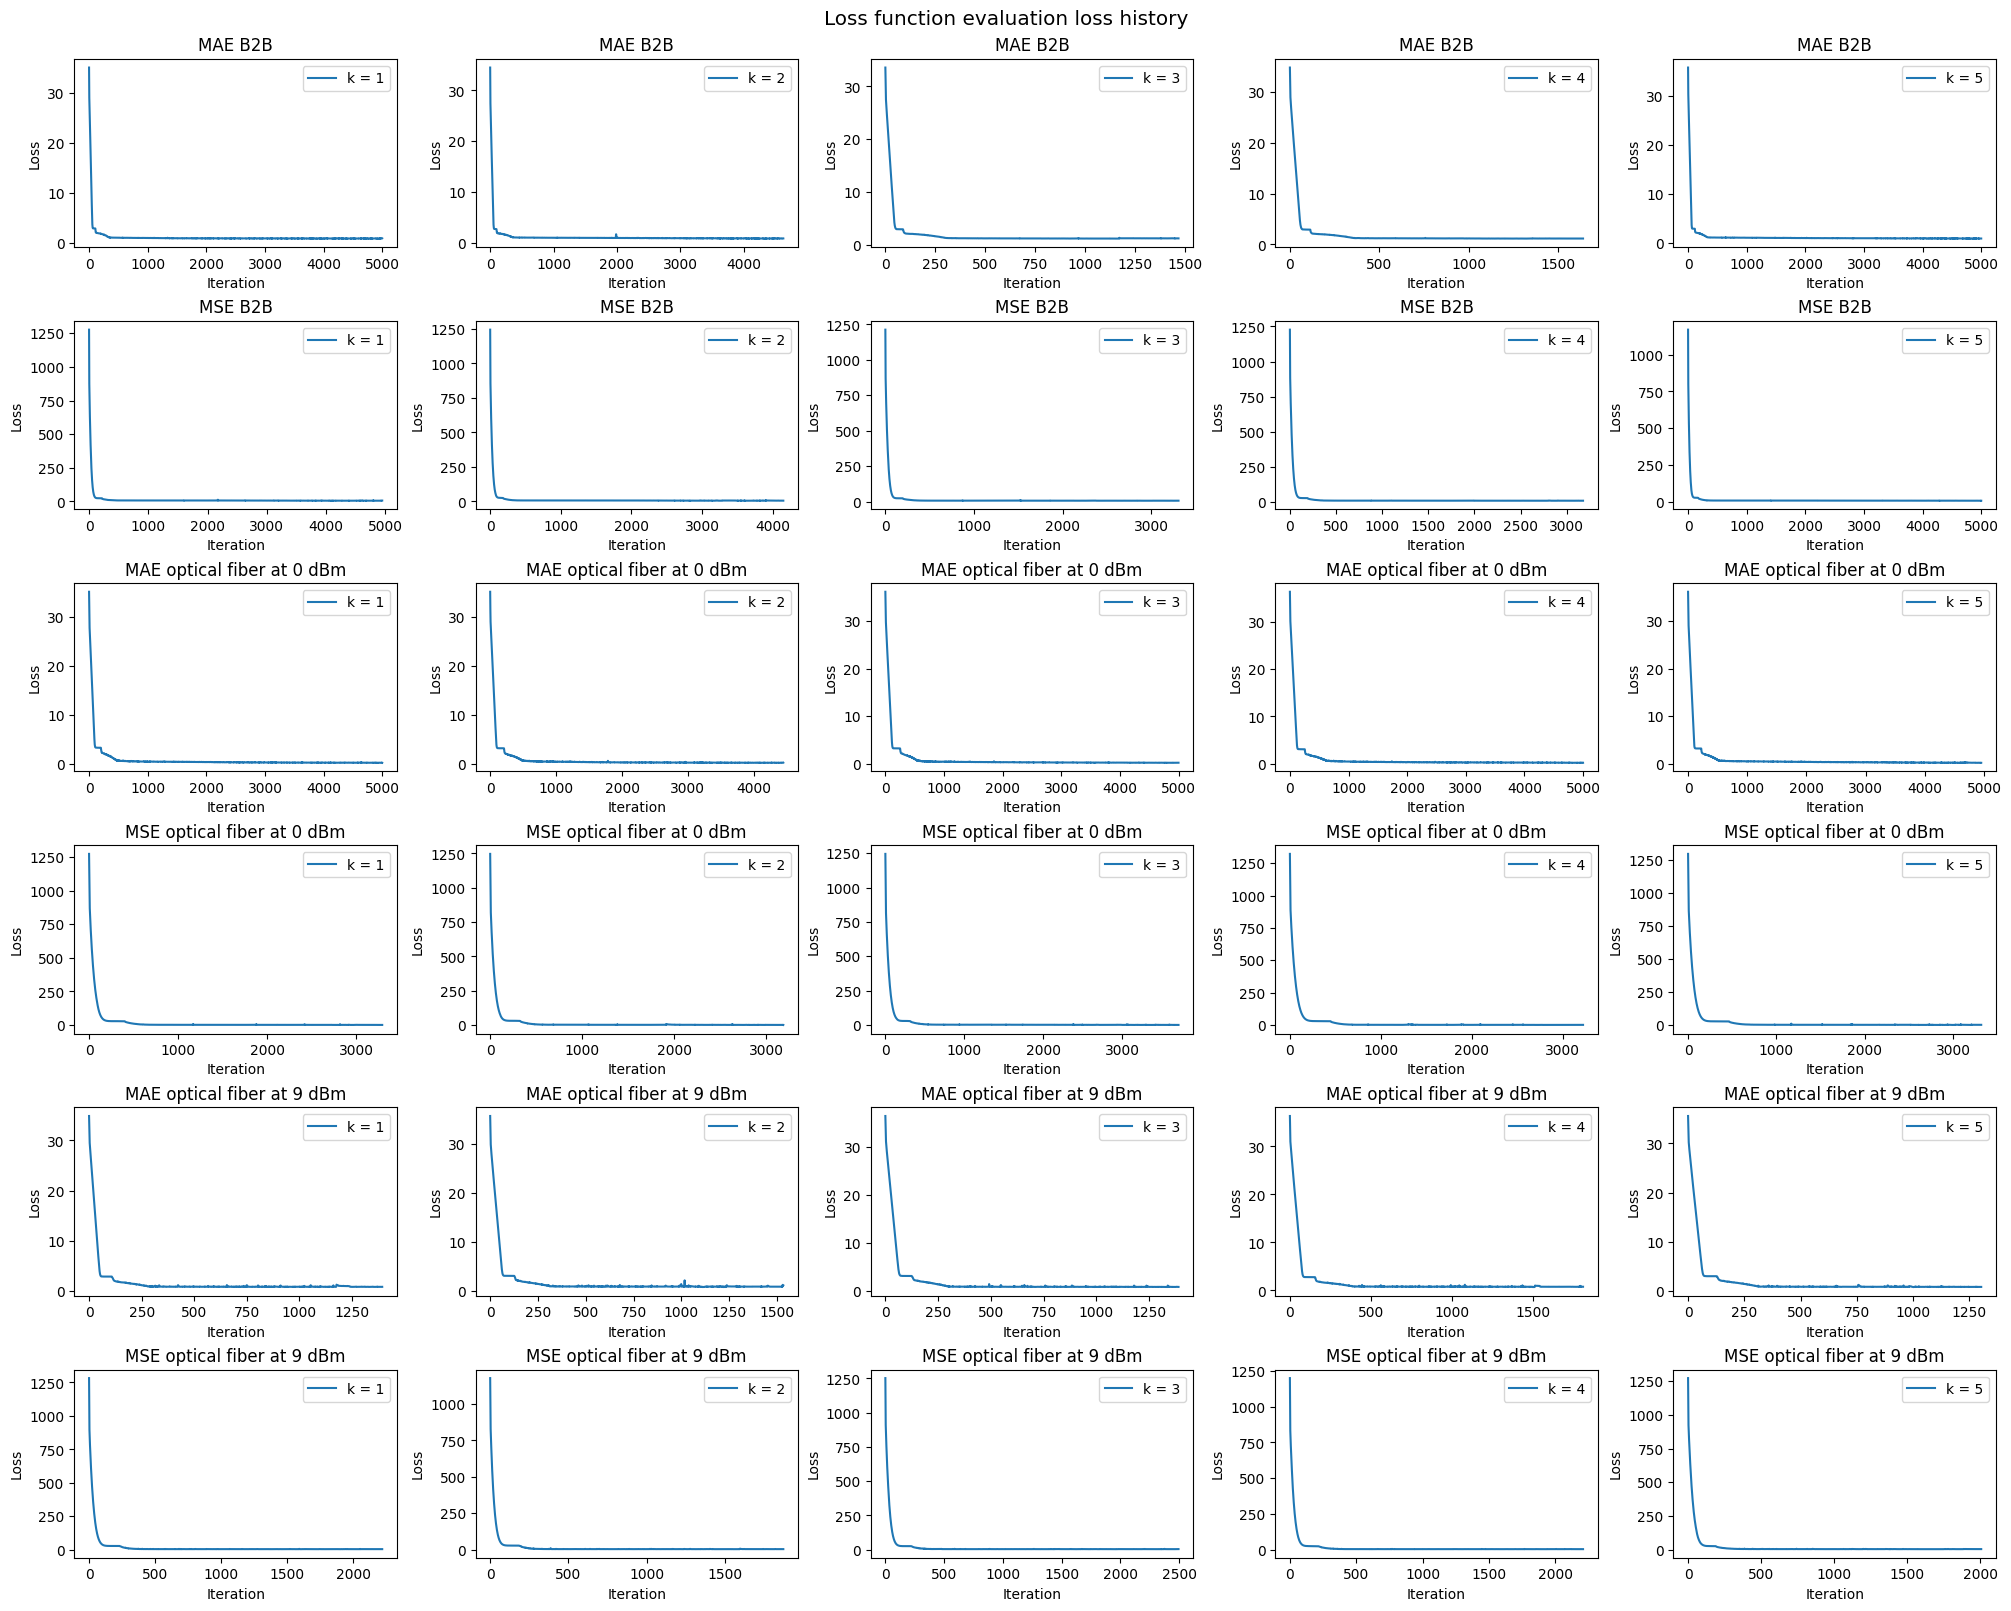

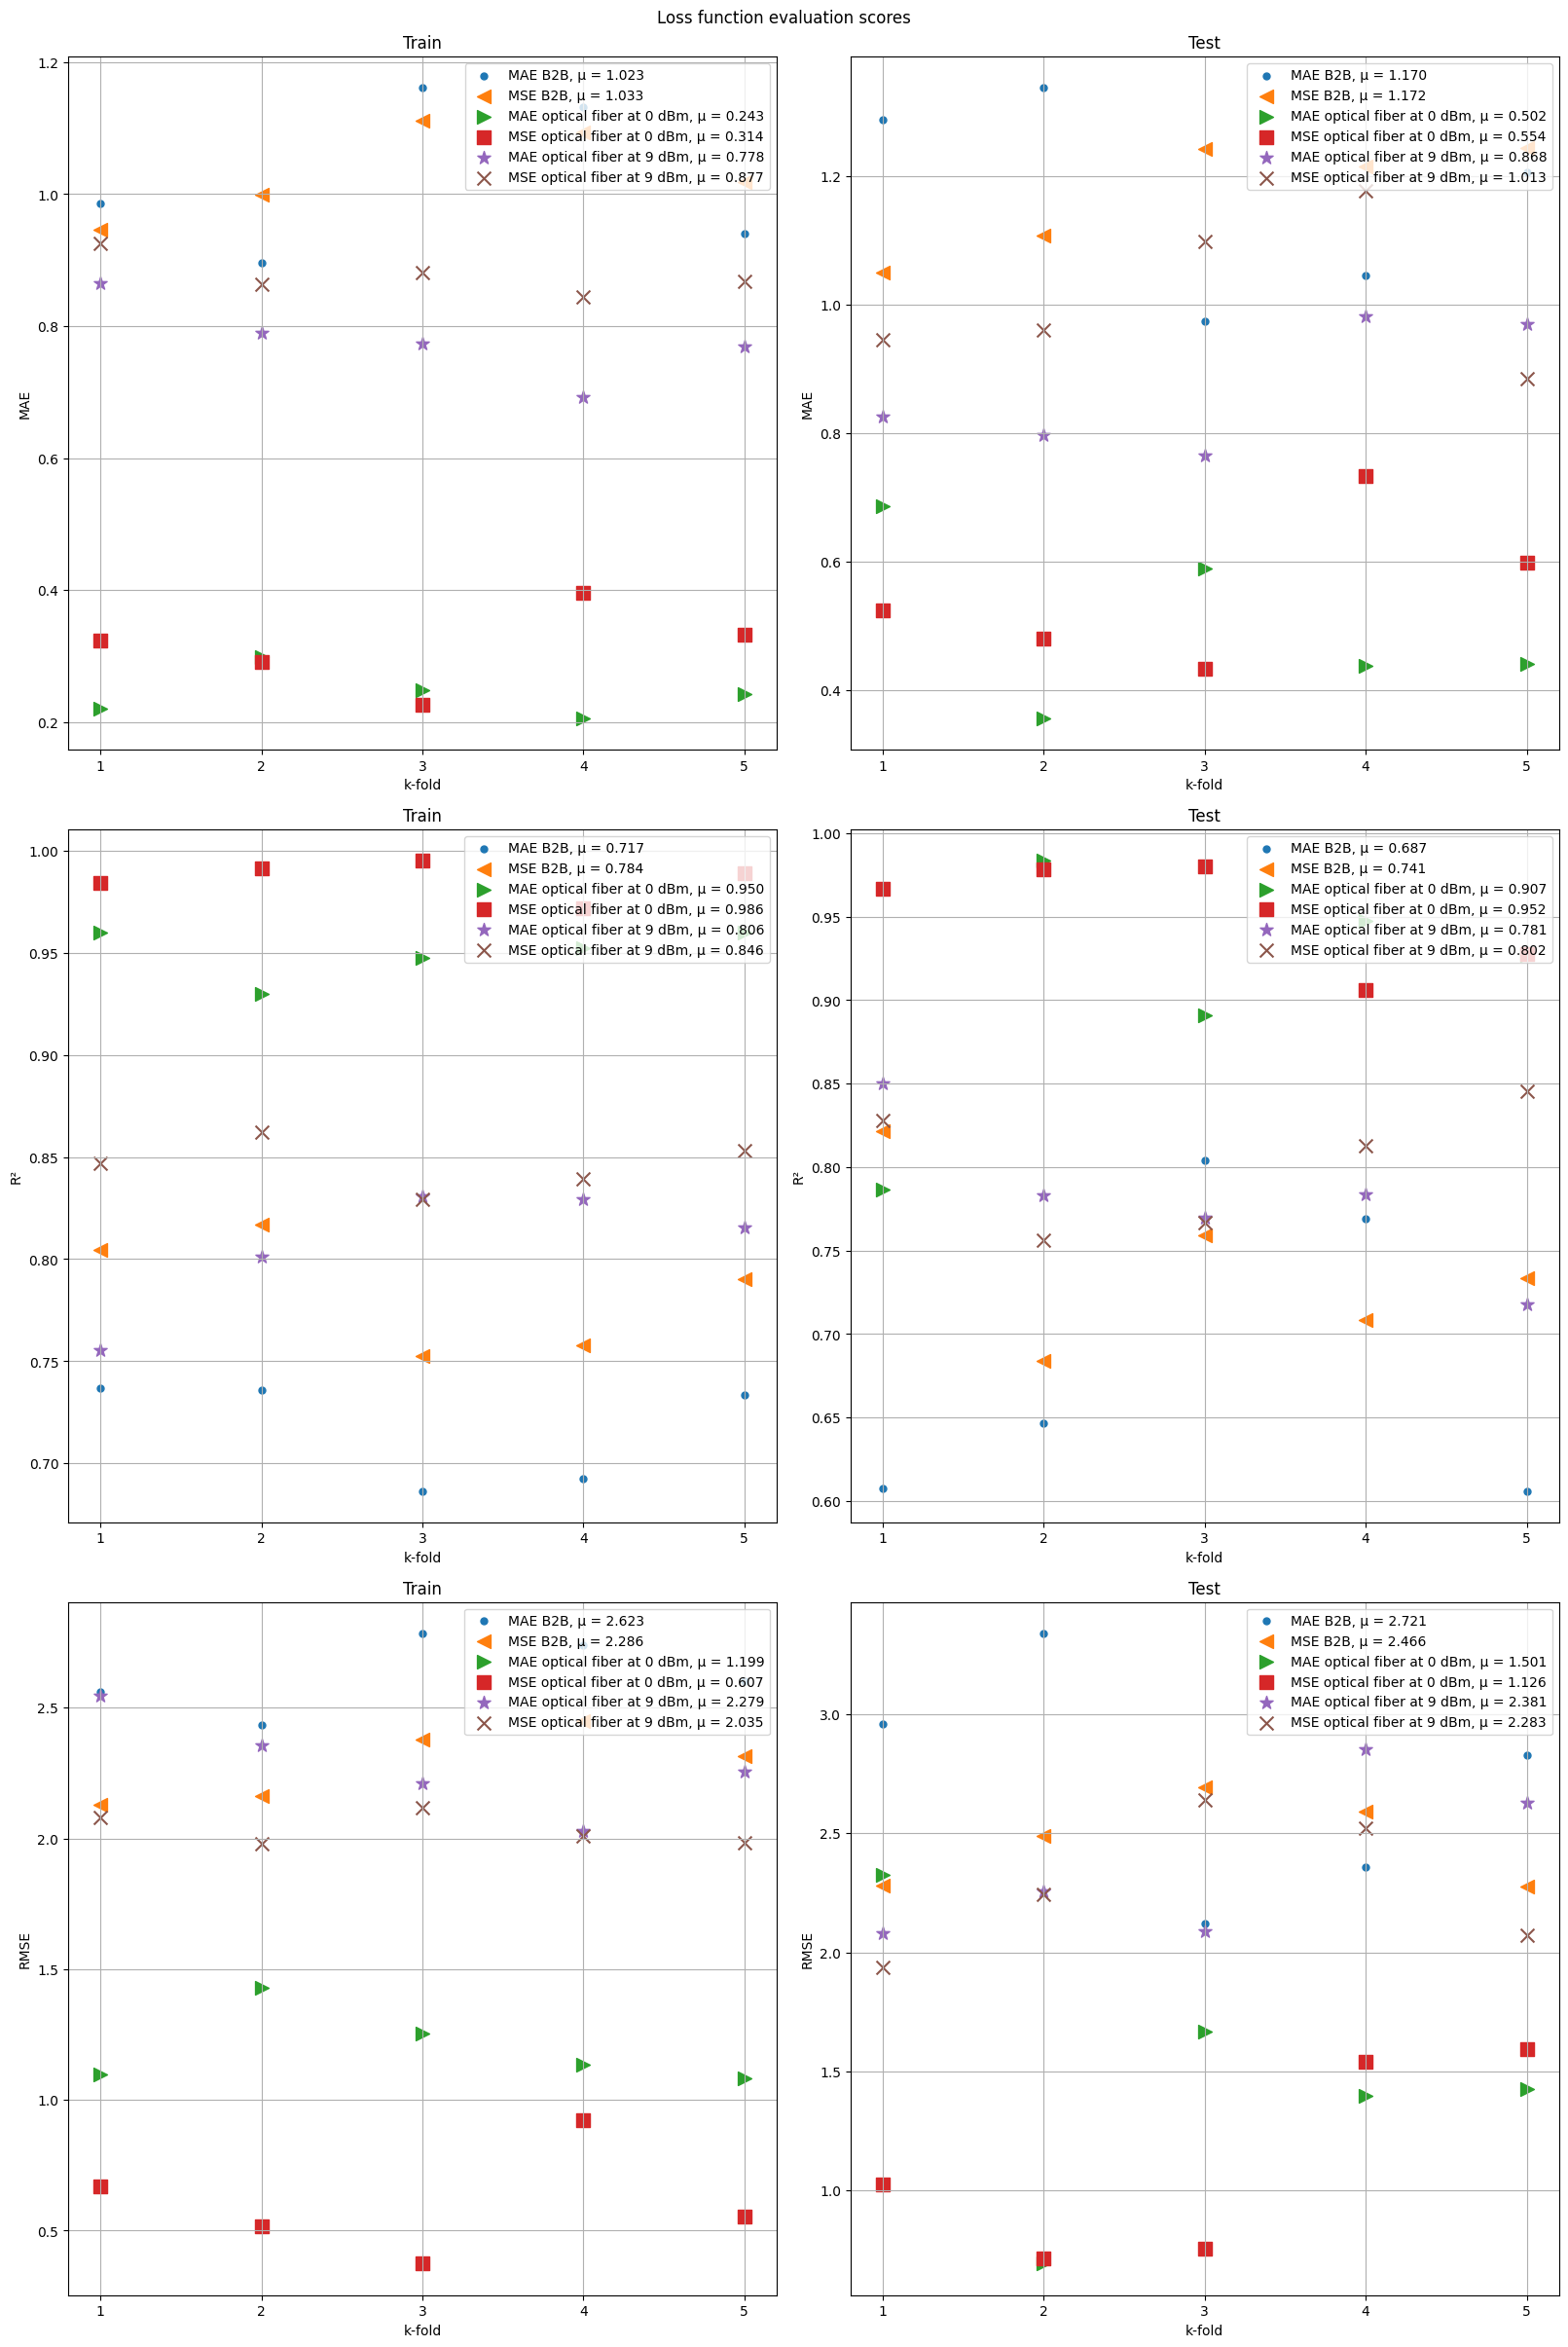

In [102]:
scores = [scores_FCM_MAE_B2B, scores_FCM_MSE_B2B, scores_FCM_MAE_fiber0, scores_FCM_MSE_fiber0, scores_FCM_MAE_fiber9, scores_FCM_MSE_fiber9]
plot_loss_scores(scores, "Loss function evaluation")